In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): 

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)


        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        
        L2_grad = -2 * (target - pred) / (input_data.size(-1) * target.size(0))
        # L2_grad = -2 * (target - pred) 
        L2_G_grad = -2 * (target_grad - pred_grad) / (input_data.size(-1) * target.size(0))
        # L2_G_grad = -2 * (target_grad - pred_grad)

        deltaWeight1 = torch.matmul(L2_grad, R.T)
        deltaweight2 = torch.matmul(L2_G_grad, self.L2_2_derivateive_weight(input_data, R).T)
        deltaWeight = deltaWeight1 + deltaweight2

        
        deltaCenter1 = torch.mean(torch.matmul(L2_grad, self.rbf_gaussian_derivative_centers(input_data).T) *
                                   self.weights , dim = 0).reshape(self.add_rbf_num, 1) # done
        deltaCenter2 = torch.mean(torch.matmul(L2_G_grad, (self.L2_F(input_) *
                                                            self.rbf_gaussian_derivative_centers(input_data)).T) *
                                                            self.weights, dim = 0).reshape(self.add_rbf_num, 1) # done
        
        deltaCenter = deltaCenter1 + deltaCenter2

        deltaSigma1 = torch.mean(torch.matmul(L2_grad, self.rbf_gaussian_derivative_sigma(input_data).T) * 
                                  self.weights , dim = 0).reshape(self.add_rbf_num,1)
        deltaSigma2 = torch.mean(torch.matmul(L2_G_grad, (self.L2_F(input_) *
                                                            self.rbf_gaussian_derivative_sigma(input_data)).T) * 
                                                            self.weights, dim = 0).reshape(self.add_rbf_num, 1) # dome
        deltaSigma = deltaSigma1 + deltaSigma2

        self.centers -= self.lr * deltaCenter
        self.sigma -= self.lr * deltaSigma
        self.weights -= self.lr * deltaWeight

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [124]:
r_c = torch.tensor([1.32141, 6.1256142, 4.21512, 3.16512, 7.1626, 8.735, 12.1624], dtype = float ,device= device).reshape(7,1)
r_s = torch.tensor([1.1, 0.6142, 2.21512, 1.162, 0.626, 2.735, 1.1624], dtype = float ,device= device).reshape(7,1)
r_w = torch.tensor([[-10, 12, 32, -33, 12, -20, 3],
                    [12, -1, -22, 3, 32, -20, 4],
                    [-10, 3, 23, -13, 23, 17, 2]], dtype = float, device = device)

In [125]:
def rbf_gaussian(input_data):
    out = torch.exp(-1 *(torch.pow((input_data - r_c), 2)) / (torch.pow(r_s, 2)))

    return out

In [126]:
a = np.arange(0,15,0.05)
input_ = torch.tensor(a, device = device)

In [127]:
target = rbf_gaussian(input_)
target = torch.matmul(r_w, target)

In [128]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

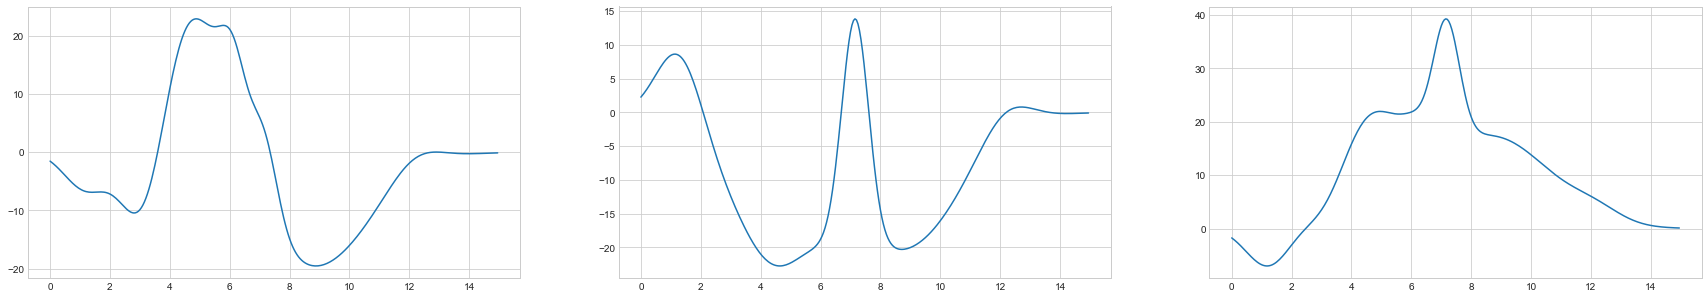

In [129]:
plot_data(input_, 3, target)

In [40]:
target.size()

torch.Size([3, 300])

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 395714.31452294067
0th additional RBFlayer 999th epoch MSE Loss: 235.76885543520942
0th additional RBFlayer 1999th epoch MSE Loss: 235.76848950921325
0th additional RBFlayer 2999th epoch MSE Loss: 235.76812336765093
0th additional RBFlayer best loss : 235.76812336765093


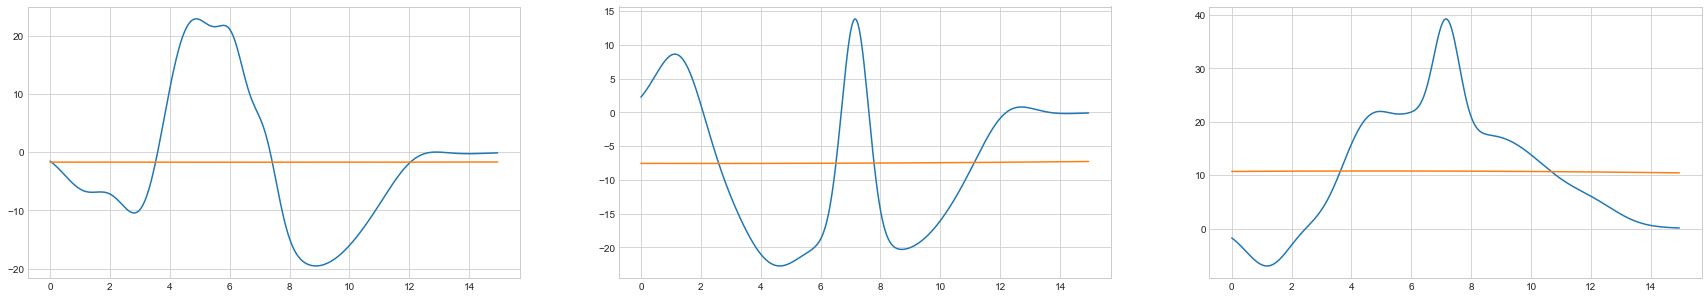

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 181691.40399719108
1th additional RBFlayer 999th epoch MSE Loss: 235.64327858598912
1th additional RBFlayer 1999th epoch MSE Loss: 235.6431888467351
1th additional RBFlayer 2999th epoch MSE Loss: 235.643099108553
1th additional RBFlayer best loss : 235.643099108553


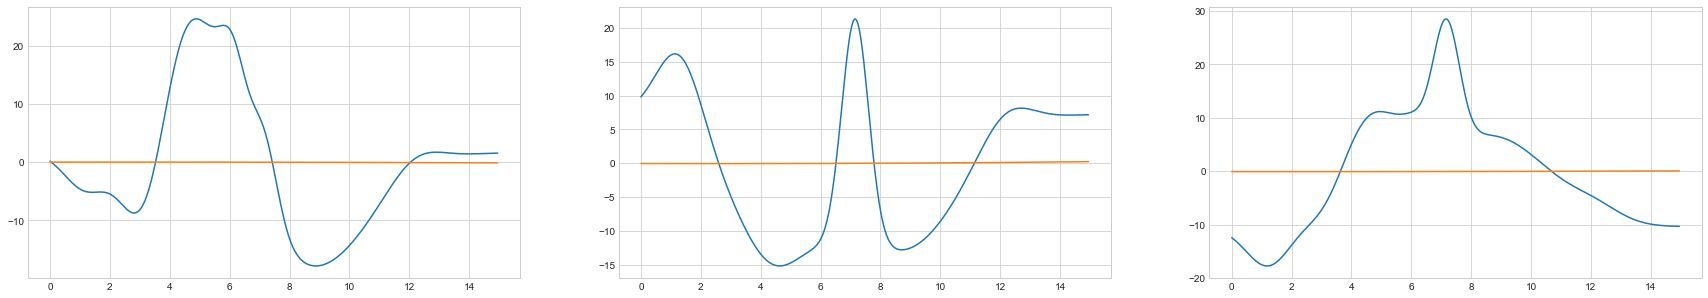

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 178949.06437702107


KeyboardInterrupt: 

In [41]:
model = MultiRBFnn(target.size(0), 30, device)
model.train(input_, target, 3000, 0.001, 5, 10)

In [7]:
single_target1 = target[0].reshape(1, target.size(-1))
single_target2 = target[1].reshape(1, target.size(-1))
single_target3 = target[2].reshape(1, target.size(-1))

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 65341.18999377226
0th additional RBFlayer 999th epoch MSE Loss: 245.03224567917022
0th additional RBFlayer 1999th epoch MSE Loss: 207.4571718261538
0th additional RBFlayer 2999th epoch MSE Loss: 11.223512761194486
0th additional RBFlayer best loss : 11.223512761194486


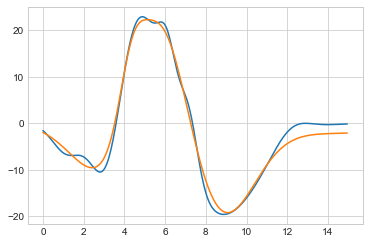

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 998.3306138192924
1th additional RBFlayer 999th epoch MSE Loss: 10.675780277963256
1th additional RBFlayer 1999th epoch MSE Loss: 10.61437980337913
1th additional RBFlayer 2999th epoch MSE Loss: 10.556732959354255
1th additional RBFlayer best loss : 10.556732959354255


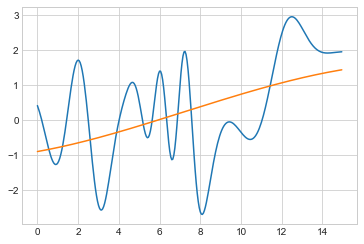

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 626.1677639949799
2th additional RBFlayer 999th epoch MSE Loss: 10.051615552756324
2th additional RBFlayer 1999th epoch MSE Loss: 9.95298713235823
2th additional RBFlayer 2999th epoch MSE Loss: 9.912486723953071
2th additional RBFlayer best loss : 9.912486723953071
change lr  0.1
----------------------------------------------


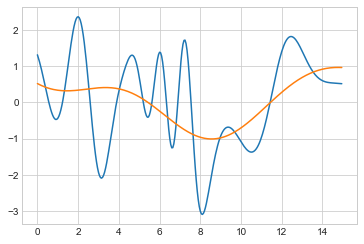

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 120.06292407100769
3th additional RBFlayer 999th epoch MSE Loss: 9.948329194141305
3th additional RBFlayer 1999th epoch MSE Loss: 9.932005926152943
3th additional RBFlayer 2999th epoch MSE Loss: 9.925855070218702
3th additional RBFlayer best loss : 9.925855070218702


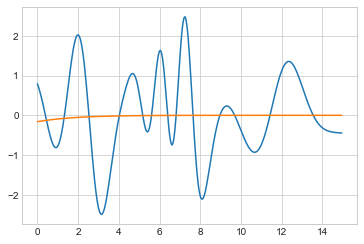

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 67.4406812150662
4th additional RBFlayer 999th epoch MSE Loss: 9.986070803099196
4th additional RBFlayer 1999th epoch MSE Loss: 9.944019368963696
4th additional RBFlayer 2999th epoch MSE Loss: 9.935954774360571
4th additional RBFlayer best loss : 9.935954774360571


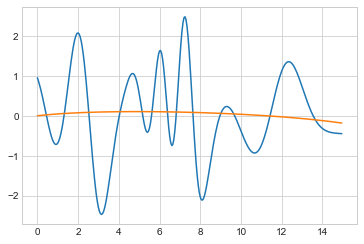

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 58.68577232943813
5th additional RBFlayer 999th epoch MSE Loss: 9.935008093879114
5th additional RBFlayer 1999th epoch MSE Loss: 9.886339757514637
5th additional RBFlayer 2999th epoch MSE Loss: 9.866748031876536
5th additional RBFlayer best loss : 9.866748031876536


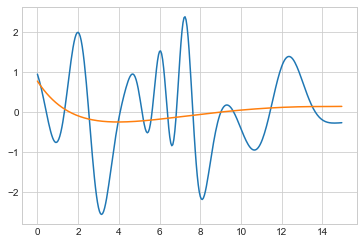

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 29.258878159964553
6th additional RBFlayer 999th epoch MSE Loss: 7.147589679159419
6th additional RBFlayer 1999th epoch MSE Loss: 7.143200082841666
6th additional RBFlayer 2999th epoch MSE Loss: 7.184157438883398
6th additional RBFlayer best loss : 7.102968946780393


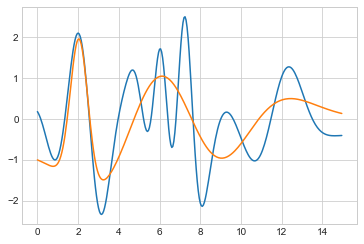

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 106.45955450336147
7th additional RBFlayer 999th epoch MSE Loss: 11.953227737049582
7th additional RBFlayer 1999th epoch MSE Loss: 10.317937320641507
7th additional RBFlayer 2999th epoch MSE Loss: 9.21047789529159
7th additional RBFlayer best loss : 9.21047789529159


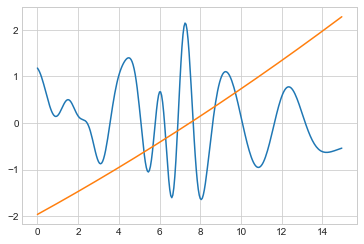

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 433.4574685856614
8th additional RBFlayer 999th epoch MSE Loss: 6.818103010273997
8th additional RBFlayer 1999th epoch MSE Loss: 6.390849505313412
8th additional RBFlayer 2999th epoch MSE Loss: 6.349252085858516
8th additional RBFlayer best loss : 6.349252085858516


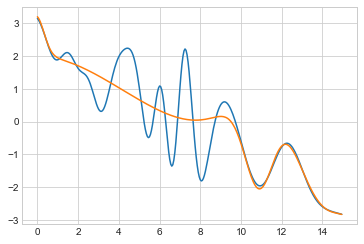

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 30.050551811806443
9th additional RBFlayer 999th epoch MSE Loss: 31.622659129707415
9th additional RBFlayer 1999th epoch MSE Loss: 4.825252022810138
9th additional RBFlayer 2999th epoch MSE Loss: 3.7214915699549227
9th additional RBFlayer best loss : 1.07605875969642


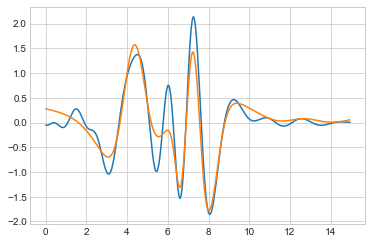

In [45]:
model_single1 = MultiRBFnn(single_target1.size(0), 30, device)
model_single1.train(input_, single_target1, 3000, 0.01, 5, 10)

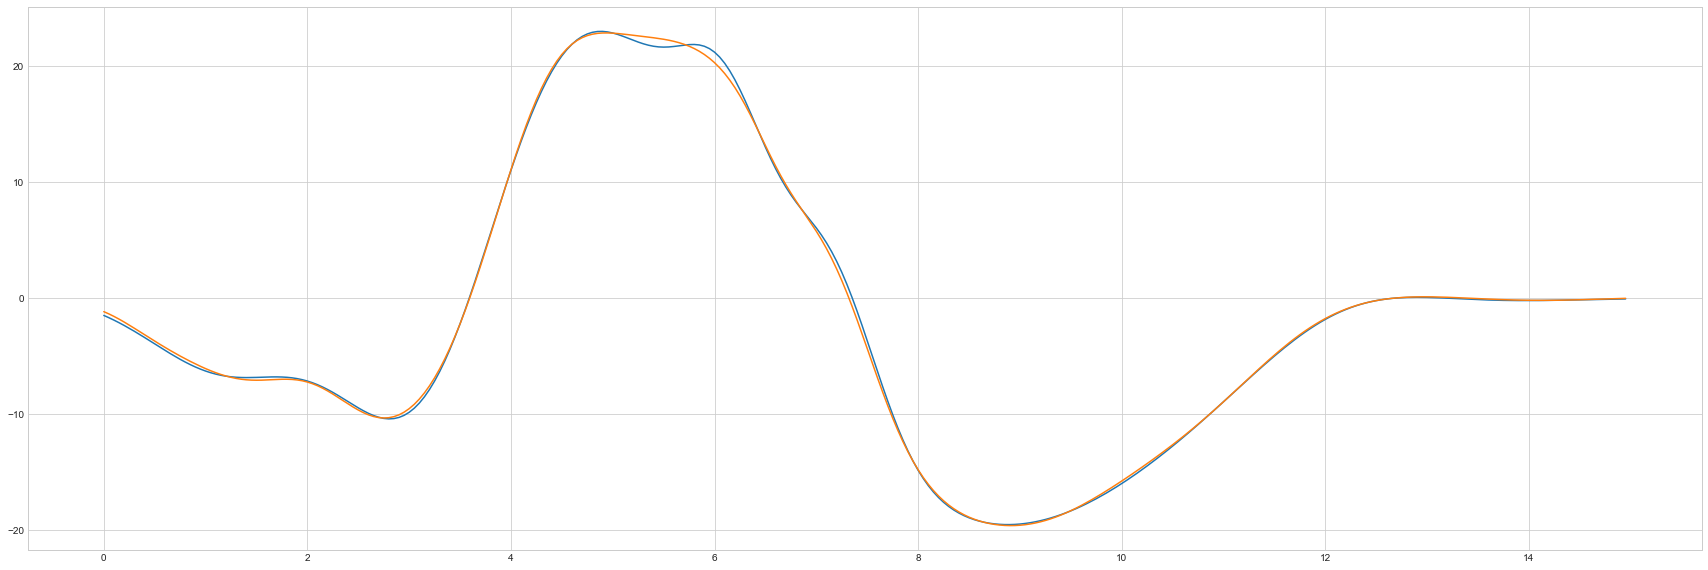

In [46]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target1[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single1.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 69598.89046042005
0th additional RBFlayer 999th epoch MSE Loss: 297.10351384455373
0th additional RBFlayer 1999th epoch MSE Loss: 297.09017531589024
0th additional RBFlayer 2999th epoch MSE Loss: 297.0768431243571
0th additional RBFlayer best loss : 297.0768431243571


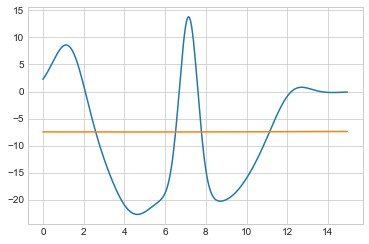

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 45094.06263344197
1th additional RBFlayer 999th epoch MSE Loss: 228.74439652725542
1th additional RBFlayer 1999th epoch MSE Loss: 192.85196079858716
1th additional RBFlayer 2999th epoch MSE Loss: 189.6288452955599
1th additional RBFlayer best loss : 136.53665577499706


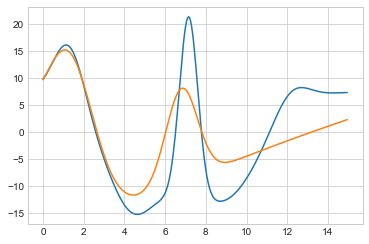

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 2363.774493710744
2th additional RBFlayer 999th epoch MSE Loss: 120.84424550326013
2th additional RBFlayer 1999th epoch MSE Loss: 120.70337571171605
2th additional RBFlayer 2999th epoch MSE Loss: 119.92694792146574
2th additional RBFlayer best loss : 119.92694792146574


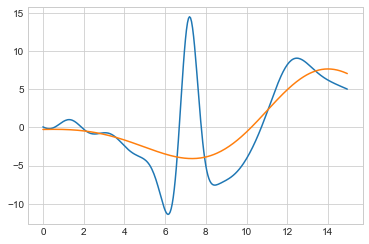

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 33736.80943659455
3th additional RBFlayer 999th epoch MSE Loss: 119.9096063756024
3th additional RBFlayer 1999th epoch MSE Loss: 119.90653884841804
3th additional RBFlayer 2999th epoch MSE Loss: 119.90590614621676
3th additional RBFlayer best loss : 119.90590614621676


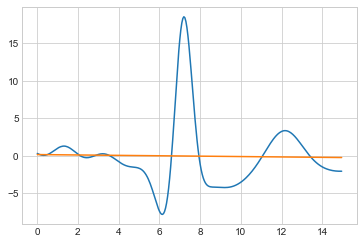

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 34820.752219297116
4th additional RBFlayer 999th epoch MSE Loss: 119.90635163167043
4th additional RBFlayer 1999th epoch MSE Loss: 119.9063516285565
4th additional RBFlayer 2999th epoch MSE Loss: 119.90635162544255
4th additional RBFlayer best loss : 119.90635162544255


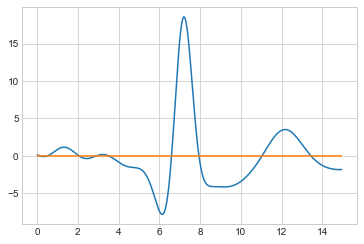

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 34860.21386334112
5th additional RBFlayer 999th epoch MSE Loss: 119.90710135753564
5th additional RBFlayer 1999th epoch MSE Loss: 119.90710134029327
5th additional RBFlayer 2999th epoch MSE Loss: 119.90710132305135
5th additional RBFlayer best loss : 119.90710132305135


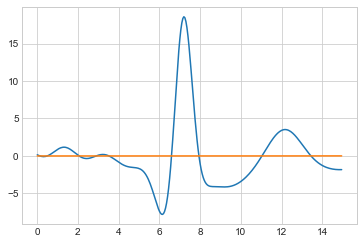

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 10440.246573957807
6th additional RBFlayer 999th epoch MSE Loss: 119.90721805059633
6th additional RBFlayer 1999th epoch MSE Loss: 119.90721803216299
6th additional RBFlayer 2999th epoch MSE Loss: 119.90721801373007
6th additional RBFlayer best loss : 119.90721801373007


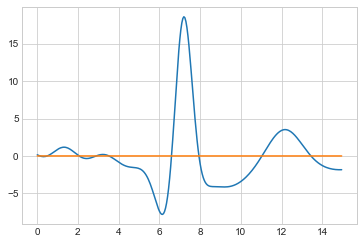

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 1230.023918196164
7th additional RBFlayer 999th epoch MSE Loss: 119.92607926148703
7th additional RBFlayer 1999th epoch MSE Loss: 119.92591450991837
7th additional RBFlayer 2999th epoch MSE Loss: 119.92575143579346
7th additional RBFlayer best loss : 119.92575143579346


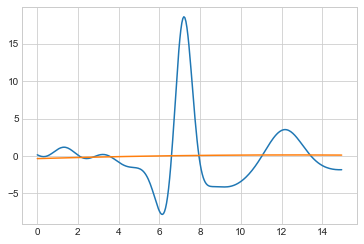

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 143.15647134856457
8th additional RBFlayer 999th epoch MSE Loss: 120.72518378681136
8th additional RBFlayer 1999th epoch MSE Loss: 120.06542964858508
8th additional RBFlayer 2999th epoch MSE Loss: 119.93172844836099
8th additional RBFlayer best loss : 119.93172844836099


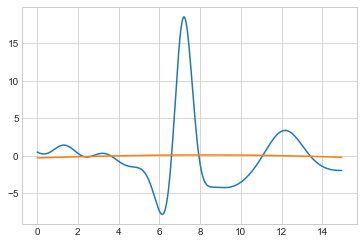

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 184.1608819414405
9th additional RBFlayer 999th epoch MSE Loss: 119.51307500805677
9th additional RBFlayer 1999th epoch MSE Loss: 118.64083794605769
9th additional RBFlayer 2999th epoch MSE Loss: 116.31763748134523
9th additional RBFlayer best loss : 116.31763748134523


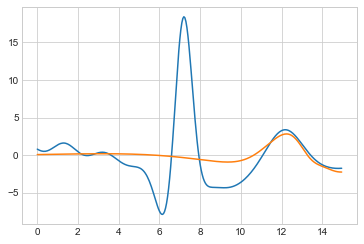

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 10639.186733870216
10th additional RBFlayer 999th epoch MSE Loss: 74.5025500991698
10th additional RBFlayer 1999th epoch MSE Loss: 74.5297354192005
10th additional RBFlayer 2999th epoch MSE Loss: 74.69671700049375
10th additional RBFlayer best loss : 39.72252679534959


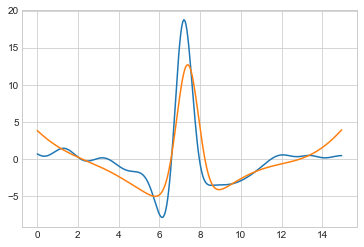

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 159.16559659990895
11th additional RBFlayer 999th epoch MSE Loss: 25.74816730705154
11th additional RBFlayer 1999th epoch MSE Loss: 26.66864312220493
11th additional RBFlayer 2999th epoch MSE Loss: 26.860536150481764
11th additional RBFlayer best loss : 13.177928969571282


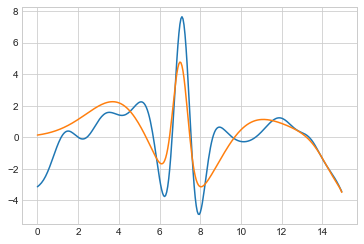

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 534.4077713572816
12th additional RBFlayer 999th epoch MSE Loss: 12.197397188089226
12th additional RBFlayer 1999th epoch MSE Loss: 12.206968274493605
12th additional RBFlayer 2999th epoch MSE Loss: 12.104332772159967
12th additional RBFlayer best loss : 12.104332772159967


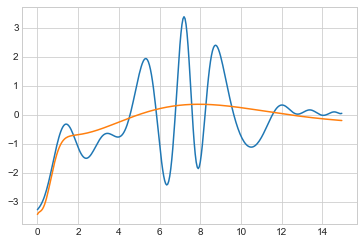

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 61.805341264649094
13th additional RBFlayer 999th epoch MSE Loss: 0.4454437701484014
13th additional RBFlayer 1999th epoch MSE Loss: 0.30810430602303657
13th additional RBFlayer 2999th epoch MSE Loss: 0.29882573447674443
13th additional RBFlayer best loss : 0.29801880869656977
change lr  0.1
----------------------------------------------
change round number 6
----------------------------------------------


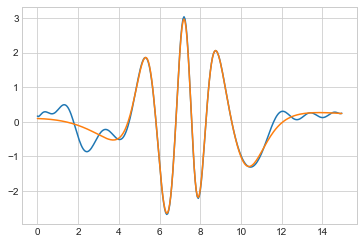

In [47]:
model_single2 = MultiRBFnn(single_target2.size(0), 30, device)
model_single2.train(input_, single_target2, 3000, 0.01, 5, 10)

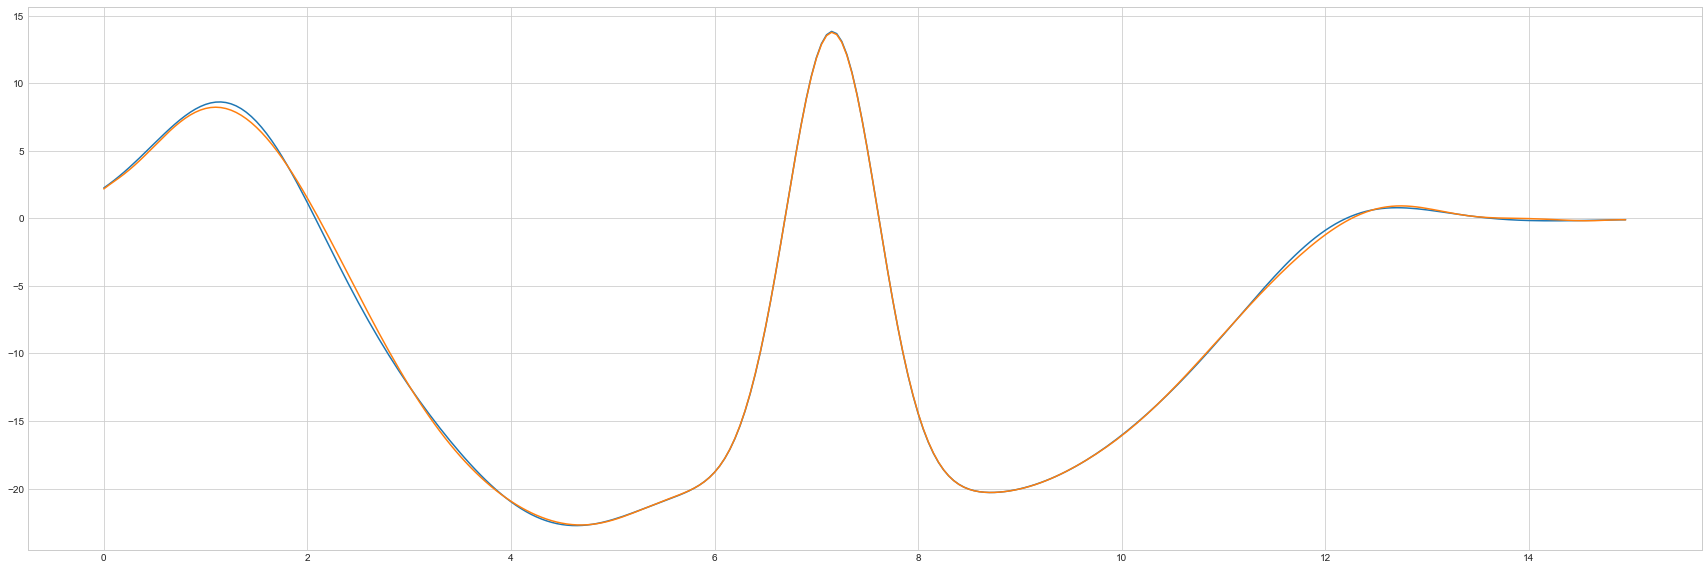

In [48]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single2.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 151874.12073219678
0th additional RBFlayer 999th epoch MSE Loss: 210.93473344357176
0th additional RBFlayer 1999th epoch MSE Loss: 210.77777016816702
0th additional RBFlayer 2999th epoch MSE Loss: 210.63116388953694
0th additional RBFlayer best loss : 210.63116388953694


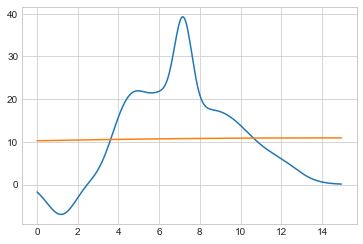

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 176179.98696012463
1th additional RBFlayer 999th epoch MSE Loss: 64.76412527235779
1th additional RBFlayer 1999th epoch MSE Loss: 64.92640329876178
1th additional RBFlayer 2999th epoch MSE Loss: 63.7486050333285
1th additional RBFlayer best loss : 17.10880078080871


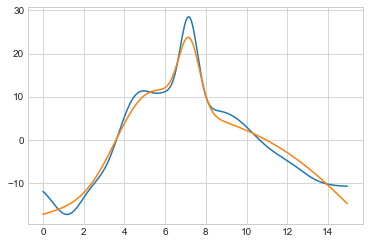

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 2830.8549420348168
2th additional RBFlayer 999th epoch MSE Loss: 11.60352456427247
2th additional RBFlayer 1999th epoch MSE Loss: 10.861485399103044
2th additional RBFlayer 2999th epoch MSE Loss: 10.607325566976964
2th additional RBFlayer best loss : 10.607325566976964


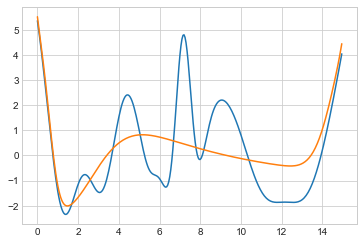

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 976.3027894044621
3th additional RBFlayer 999th epoch MSE Loss: 2.387312071267005
3th additional RBFlayer 1999th epoch MSE Loss: 1.6103931728467429
3th additional RBFlayer 2999th epoch MSE Loss: 1.5598926395146153
3th additional RBFlayer best loss : 1.5598926395146153
change lr  0.1
----------------------------------------------


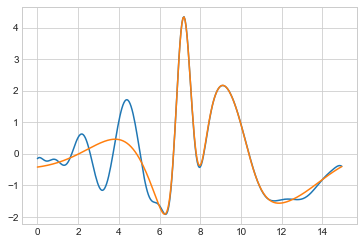

In [49]:
model_single3 = MultiRBFnn(single_target3.size(0), 30, device)
model_single3.train(input_, single_target3, 3000, 0.01, 5, 10)

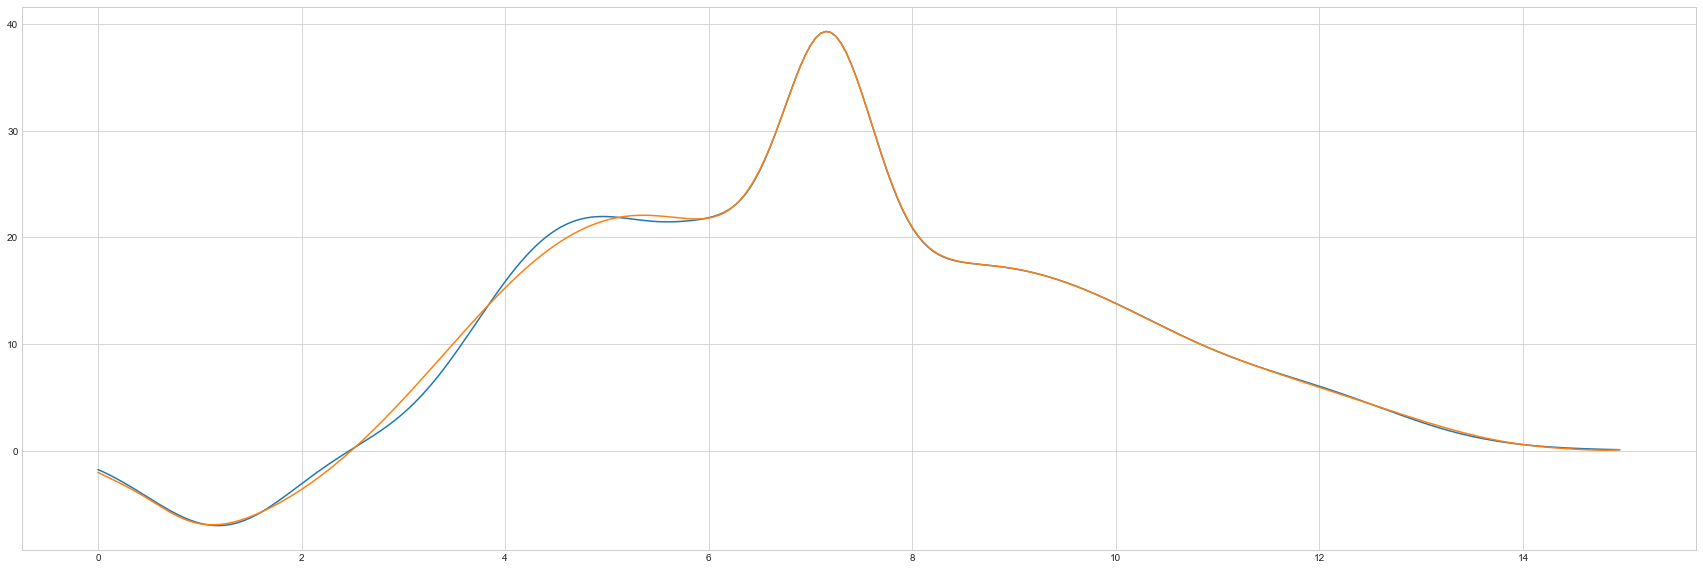

In [50]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target3[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single3.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 265516.4479042254
0th additional RBFlayer 999th epoch MSE Loss: 235.76595218789123
0th additional RBFlayer 1999th epoch MSE Loss: 235.76224942408317
0th additional RBFlayer 2999th epoch MSE Loss: 235.758519892121
0th additional RBFlayer best loss : 235.758519892121


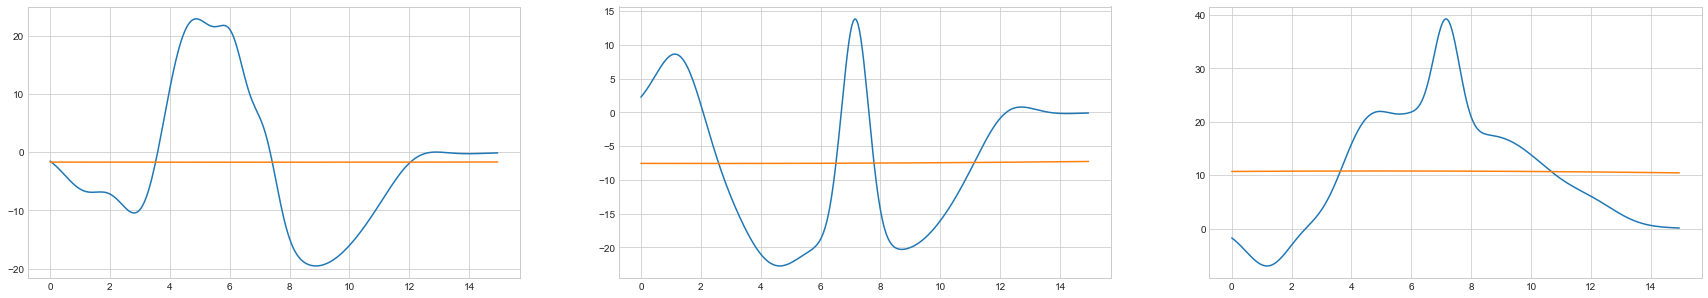

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 181660.34457852072
1th additional RBFlayer 999th epoch MSE Loss: 235.5763678498472
1th additional RBFlayer 1999th epoch MSE Loss: 235.57517027861368
1th additional RBFlayer 2999th epoch MSE Loss: 235.5739729485548
1th additional RBFlayer best loss : 235.5739729485548


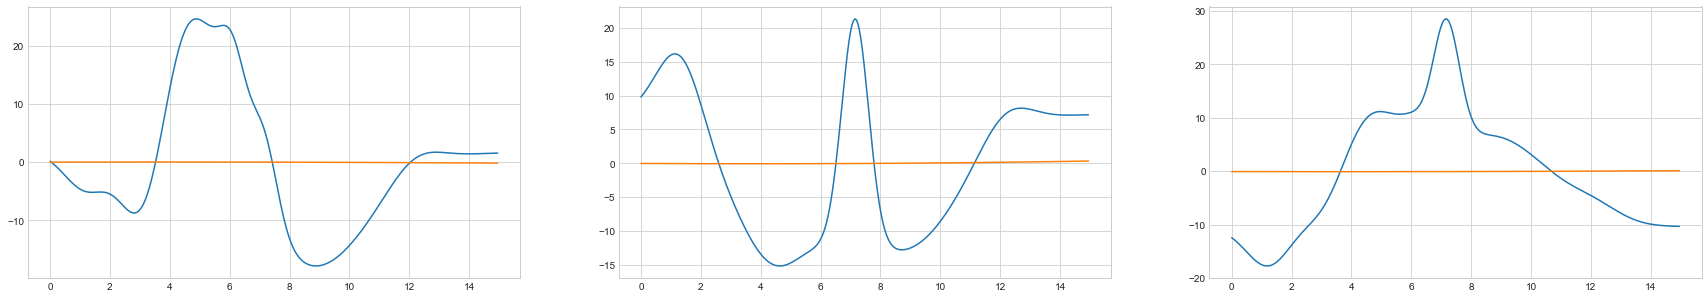

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 177589.72046775726
2th additional RBFlayer 999th epoch MSE Loss: 235.3561215927087
2th additional RBFlayer 1999th epoch MSE Loss: 234.81520427662264
2th additional RBFlayer 2999th epoch MSE Loss: 234.5796821390721
2th additional RBFlayer best loss : 234.5796821390721


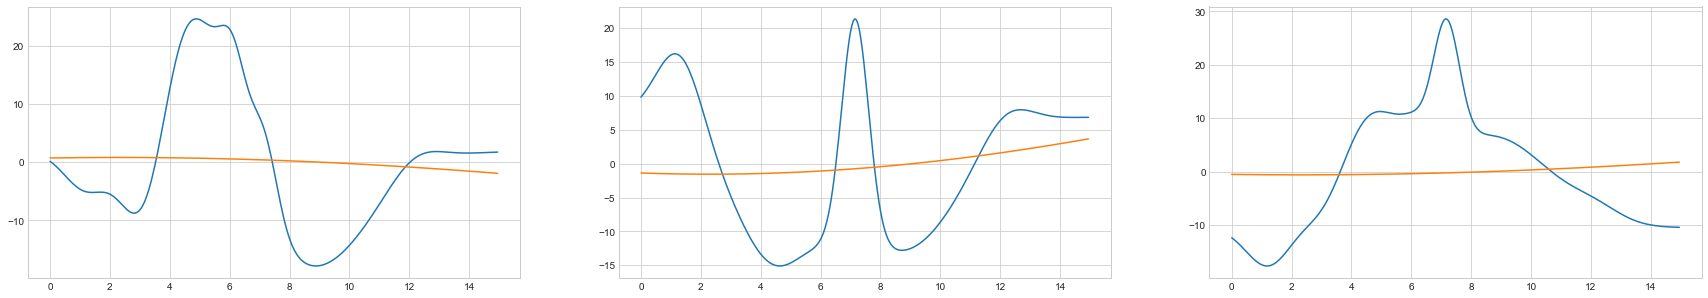

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 99356.38537221258
3th additional RBFlayer 999th epoch MSE Loss: 156.68806147167123
3th additional RBFlayer 1999th epoch MSE Loss: 110.15236047240214
3th additional RBFlayer 2999th epoch MSE Loss: 103.17501910018517
3th additional RBFlayer best loss : 103.17501910018517


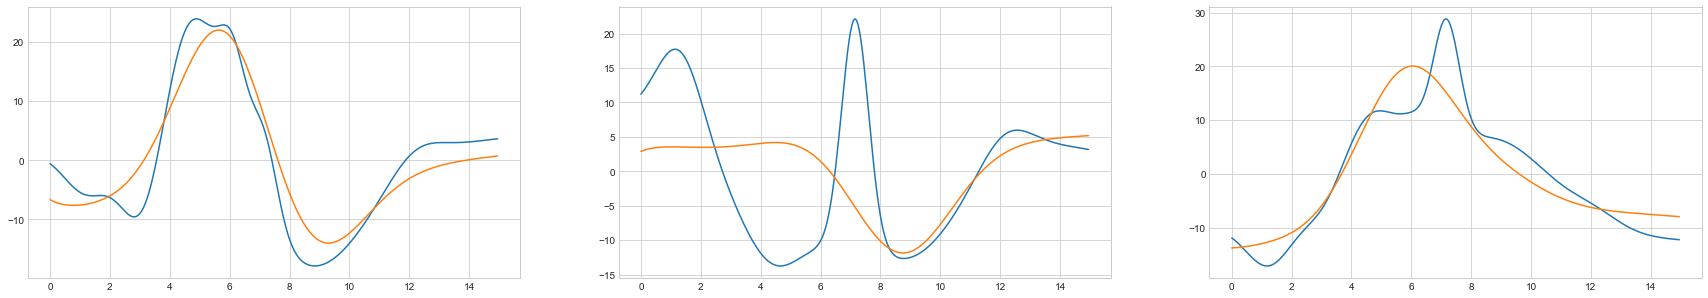

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 19218.68941720768
4th additional RBFlayer 999th epoch MSE Loss: 97.46860121518768
4th additional RBFlayer 1999th epoch MSE Loss: 94.74286200695441
4th additional RBFlayer 2999th epoch MSE Loss: 96.15835527906314
4th additional RBFlayer best loss : 93.94996231423798


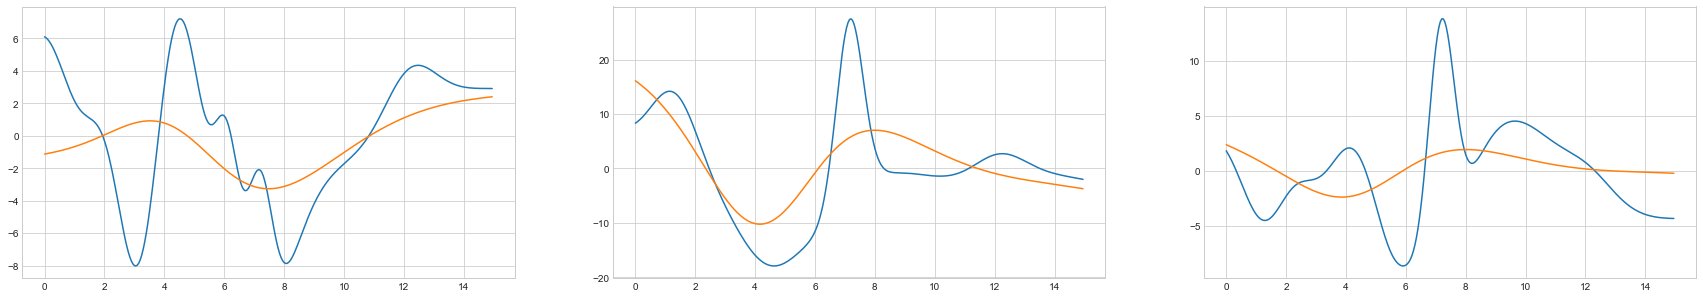

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 3610.594343752519
5th additional RBFlayer 999th epoch MSE Loss: 93.79059739446319
5th additional RBFlayer 1999th epoch MSE Loss: 93.7724681073612
5th additional RBFlayer 2999th epoch MSE Loss: 93.17914796224889
5th additional RBFlayer best loss : 93.17914796224889


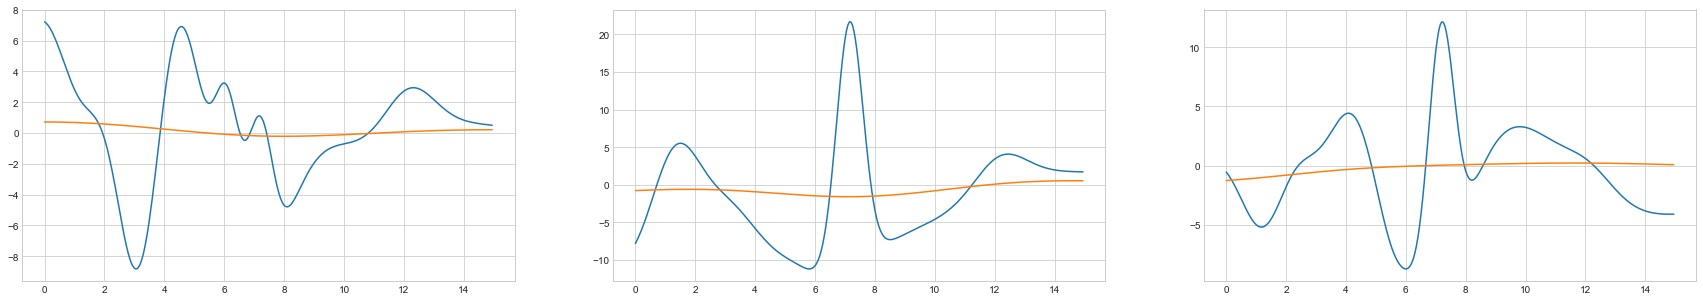

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 6717.118185480023
6th additional RBFlayer 999th epoch MSE Loss: 91.30513510384742
6th additional RBFlayer 1999th epoch MSE Loss: 91.7865332594781
6th additional RBFlayer 2999th epoch MSE Loss: 90.16486378615274
6th additional RBFlayer best loss : 87.7175651544667


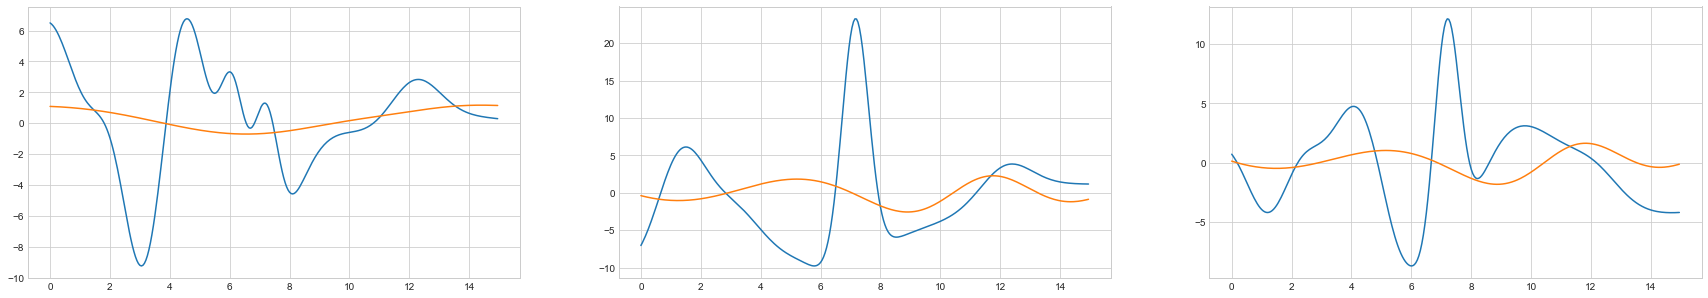

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 6066.249293479342
7th additional RBFlayer 999th epoch MSE Loss: 88.06026298842913
7th additional RBFlayer 1999th epoch MSE Loss: 88.01716188475761
7th additional RBFlayer 2999th epoch MSE Loss: 87.81519934372945
7th additional RBFlayer best loss : 87.81519934372945


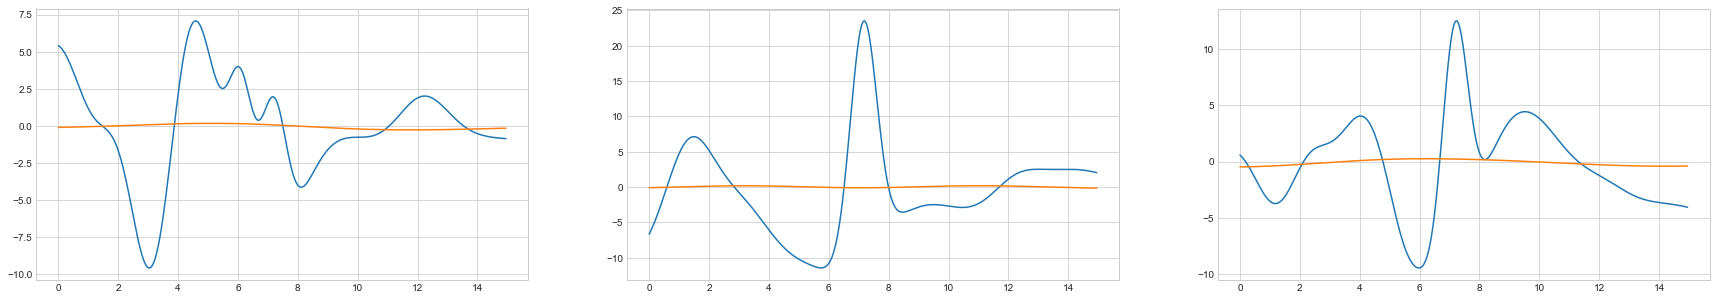

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 4751.111077331136
8th additional RBFlayer 999th epoch MSE Loss: 88.45022967399152
8th additional RBFlayer 1999th epoch MSE Loss: 88.44706476215347
8th additional RBFlayer 2999th epoch MSE Loss: 88.39647859162883
8th additional RBFlayer best loss : 87.51875370518971


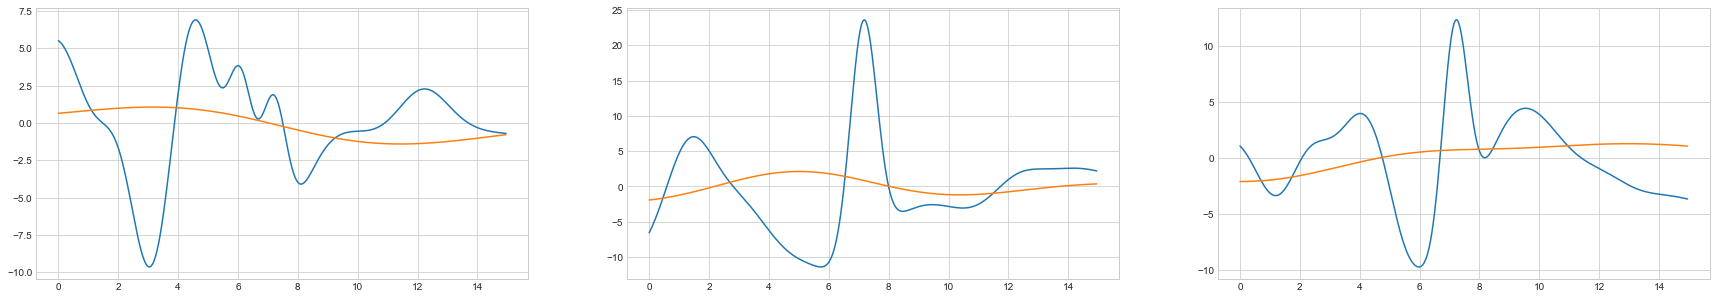

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 1936.3273209645881
9th additional RBFlayer 999th epoch MSE Loss: 88.19039946886656
9th additional RBFlayer 1999th epoch MSE Loss: 87.82656629333637
9th additional RBFlayer 2999th epoch MSE Loss: 108.10513618925151
9th additional RBFlayer best loss : 87.12862324951527


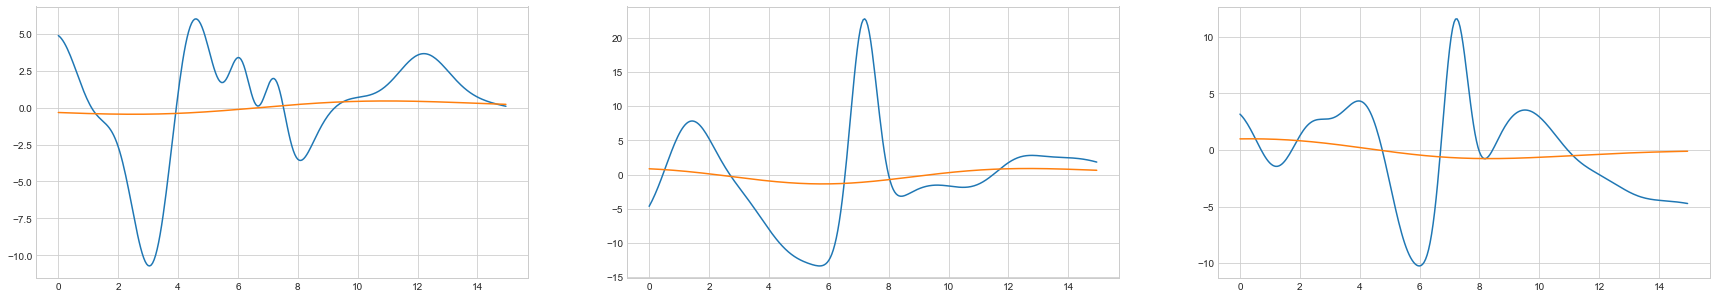

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 4428.498387021061
10th additional RBFlayer 999th epoch MSE Loss: 88.25828013528685
10th additional RBFlayer 1999th epoch MSE Loss: 89.23203988364936
10th additional RBFlayer 2999th epoch MSE Loss: 90.46574576015931
10th additional RBFlayer best loss : 87.93003471874202


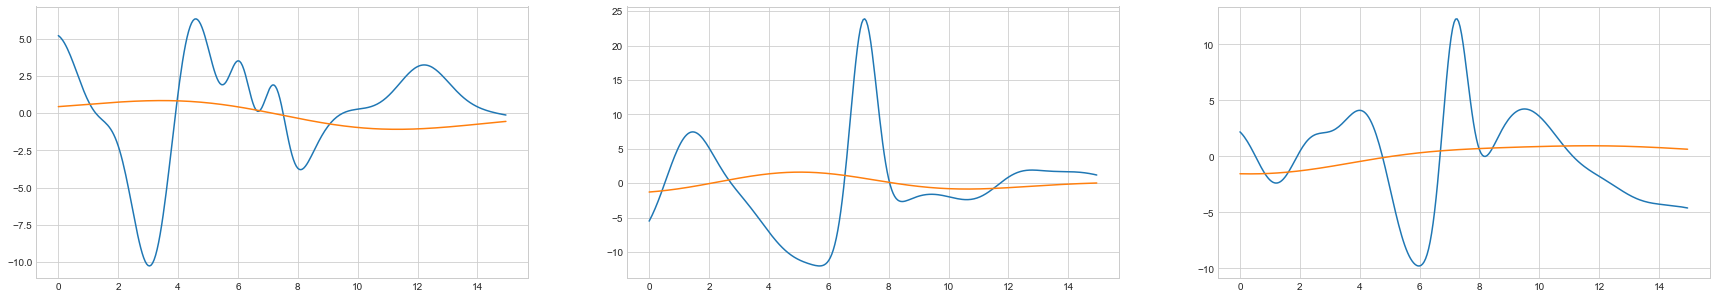

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 2364.2800538608826
11th additional RBFlayer 999th epoch MSE Loss: 87.54349308164758
11th additional RBFlayer 1999th epoch MSE Loss: 88.11562105516361
11th additional RBFlayer 2999th epoch MSE Loss: 90.16640512227714
11th additional RBFlayer best loss : 87.06906331244586


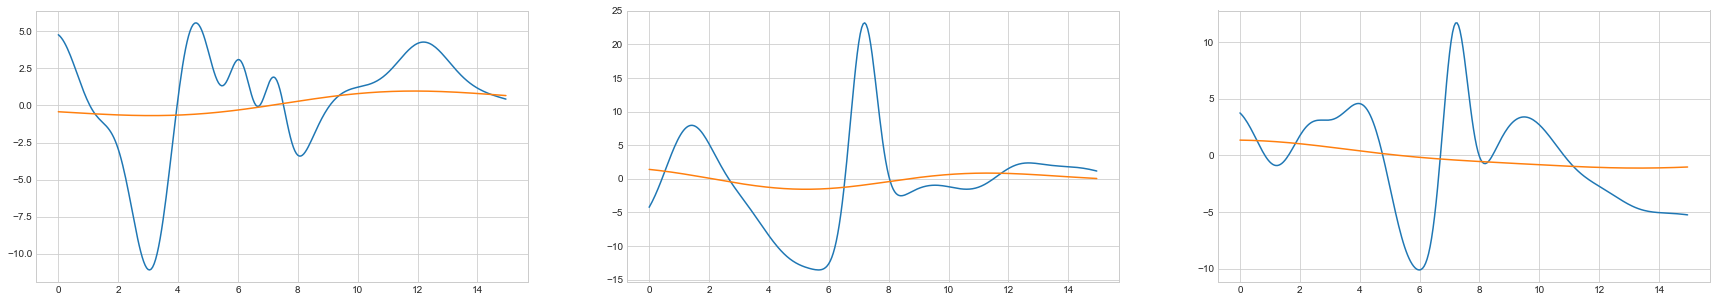

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 5788.720500214294
12th additional RBFlayer 999th epoch MSE Loss: 87.93092506741675
12th additional RBFlayer 1999th epoch MSE Loss: 88.309434287525
12th additional RBFlayer 2999th epoch MSE Loss: 89.54828857327264
12th additional RBFlayer best loss : 87.92268841883686


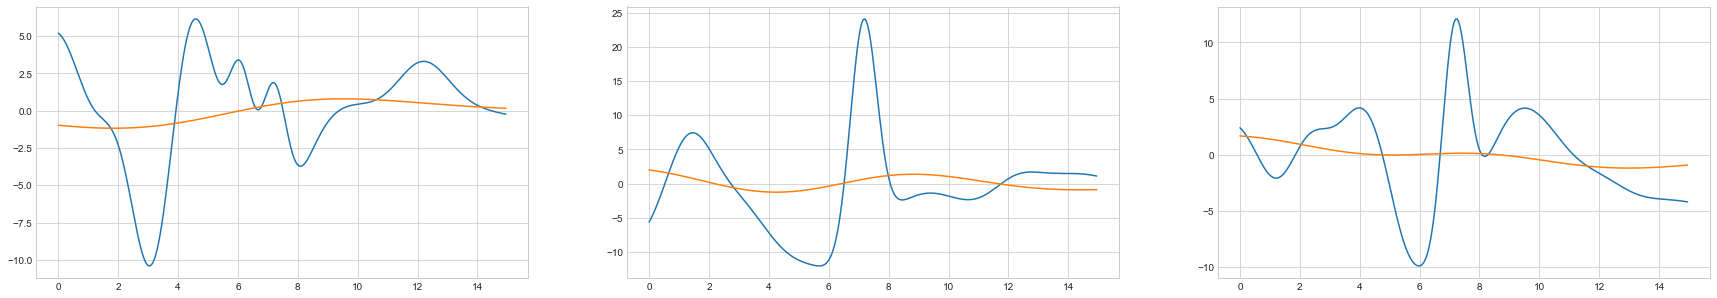

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 4419.692255290533
13th additional RBFlayer 999th epoch MSE Loss: 88.2973002410602
13th additional RBFlayer 1999th epoch MSE Loss: 88.57961740068025
13th additional RBFlayer 2999th epoch MSE Loss: 88.5350241865692
13th additional RBFlayer best loss : 87.97077121506797


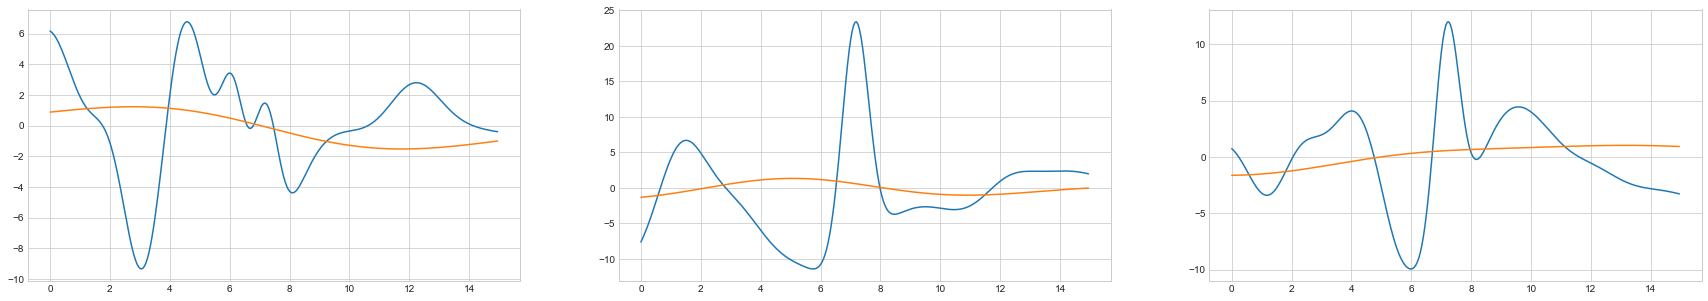

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 11721.22869848121
14th additional RBFlayer 999th epoch MSE Loss: 91.70618590567847
14th additional RBFlayer 1999th epoch MSE Loss: 90.62802978066978
14th additional RBFlayer 2999th epoch MSE Loss: 88.67635312925914
14th additional RBFlayer best loss : 86.77449944138817


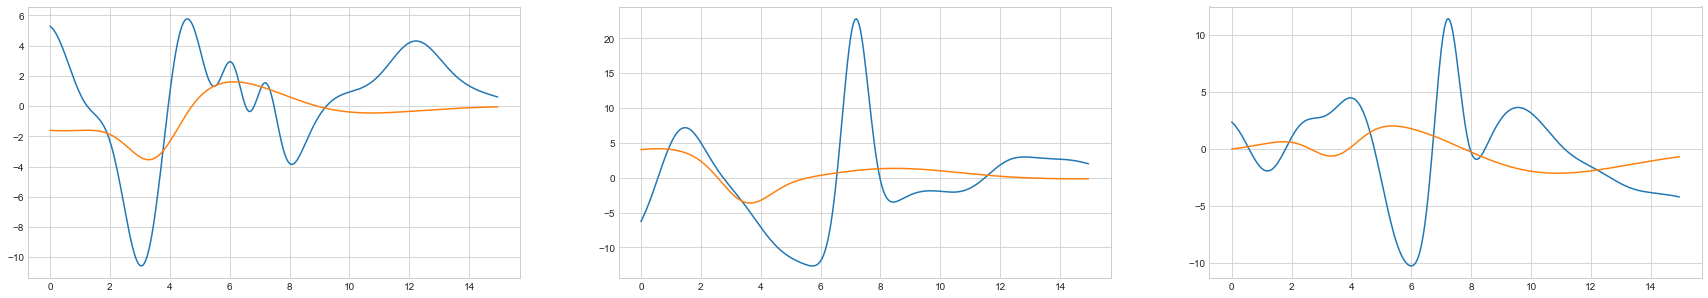

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 2051.3688827092947
15th additional RBFlayer 999th epoch MSE Loss: 87.01102657338714
15th additional RBFlayer 1999th epoch MSE Loss: 86.88109683812866
15th additional RBFlayer 2999th epoch MSE Loss: 87.89498353777411
15th additional RBFlayer best loss : 85.33180280003918


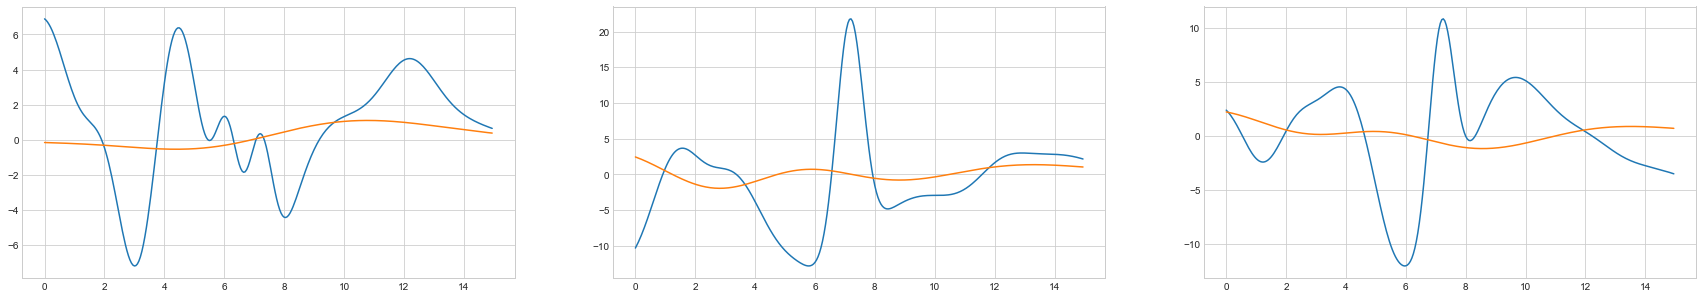

16th additional rbflayer
16th additional RBFlayer 0th epoch loss: 1680.766608943326
16th additional RBFlayer 999th epoch MSE Loss: 85.67112493055878
16th additional RBFlayer 1999th epoch MSE Loss: 85.99057361010107
16th additional RBFlayer 2999th epoch MSE Loss: 85.40244451784211
16th additional RBFlayer best loss : 85.07446960816605


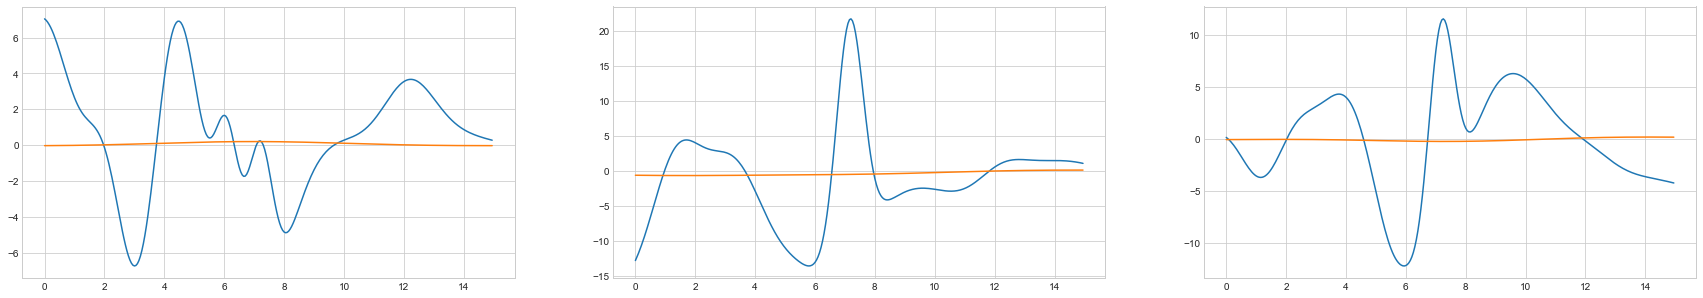

17th additional rbflayer
17th additional RBFlayer 0th epoch loss: 1953.7858902903545
17th additional RBFlayer 999th epoch MSE Loss: 85.56821149226482
17th additional RBFlayer 1999th epoch MSE Loss: 85.01372875728399
17th additional RBFlayer 2999th epoch MSE Loss: 82.59287612352003
17th additional RBFlayer best loss : 82.59287612352003


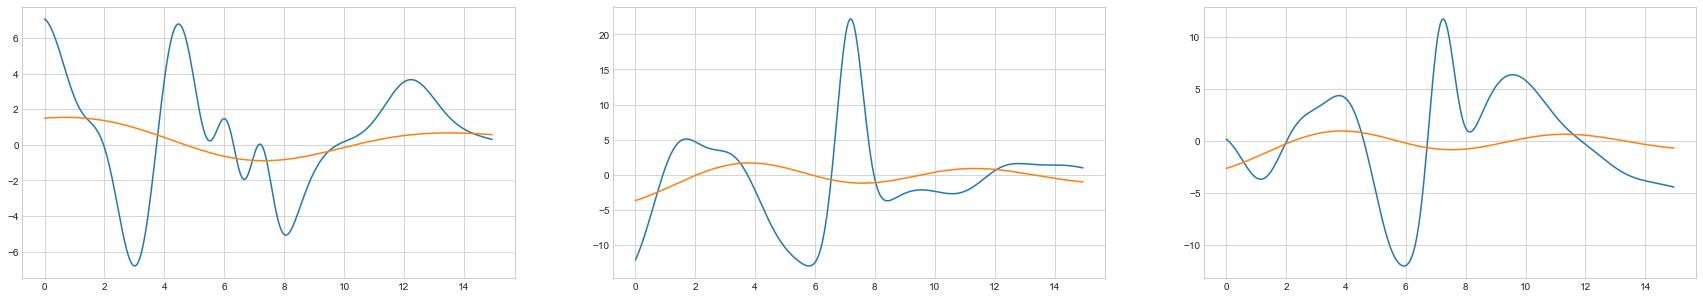

18th additional rbflayer
18th additional RBFlayer 0th epoch loss: 2346.1774453215025
18th additional RBFlayer 999th epoch MSE Loss: 84.01451107859015
18th additional RBFlayer 1999th epoch MSE Loss: 84.06123198916387
18th additional RBFlayer 2999th epoch MSE Loss: 83.034578514875
18th additional RBFlayer best loss : 82.00617005695837


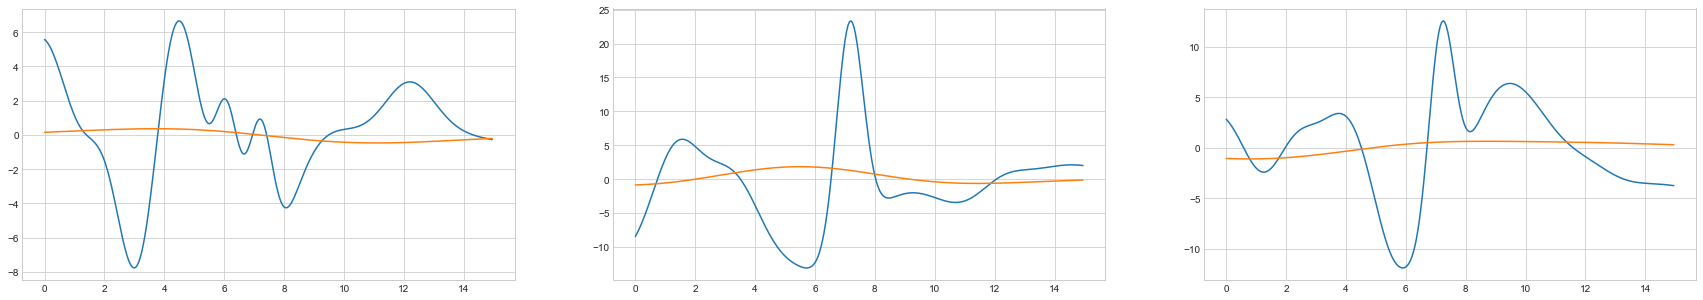

19th additional rbflayer
19th additional RBFlayer 0th epoch loss: 2139.269007441484
19th additional RBFlayer 999th epoch MSE Loss: 87.27588896266458
19th additional RBFlayer 1999th epoch MSE Loss: 91.46243203165949
19th additional RBFlayer 2999th epoch MSE Loss: 83.44352432445723
19th additional RBFlayer best loss : 82.42338979572764


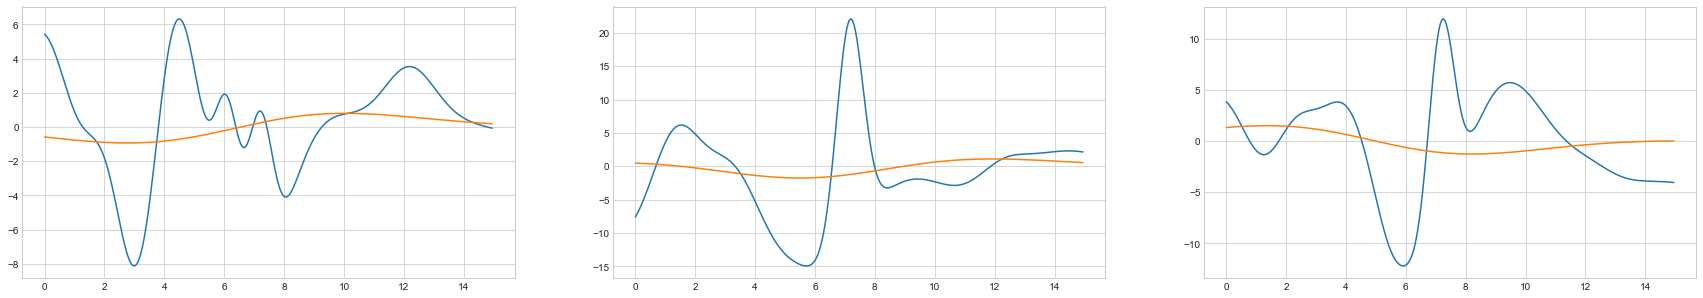

20th additional rbflayer
20th additional RBFlayer 0th epoch loss: 2225.2895131334576
20th additional RBFlayer 999th epoch MSE Loss: 83.80725359513568
20th additional RBFlayer 1999th epoch MSE Loss: 83.4279436647374
20th additional RBFlayer 2999th epoch MSE Loss: 82.65866668488908
20th additional RBFlayer best loss : 81.6228571239625


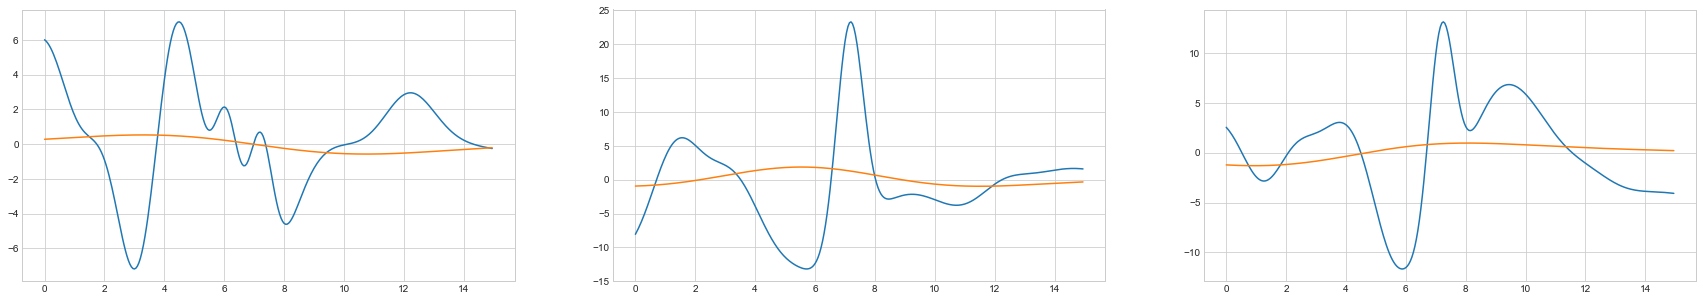

21th additional rbflayer
21th additional RBFlayer 0th epoch loss: 2137.608616888535
21th additional RBFlayer 999th epoch MSE Loss: 87.78791493810988
21th additional RBFlayer 1999th epoch MSE Loss: 83.12953279833764
21th additional RBFlayer 2999th epoch MSE Loss: 83.8593634348201
21th additional RBFlayer best loss : 82.24281880480576


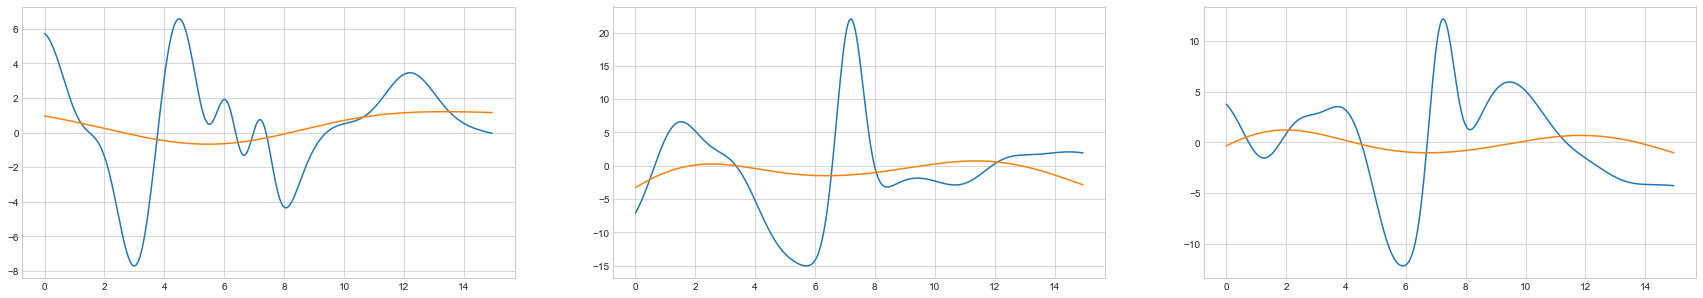

22th additional rbflayer
22th additional RBFlayer 0th epoch loss: 2194.5959570095265
22th additional RBFlayer 999th epoch MSE Loss: 83.56960470616231
22th additional RBFlayer 1999th epoch MSE Loss: 84.47994099236755
22th additional RBFlayer 2999th epoch MSE Loss: 81.52476412850778
22th additional RBFlayer best loss : 81.4605734823618


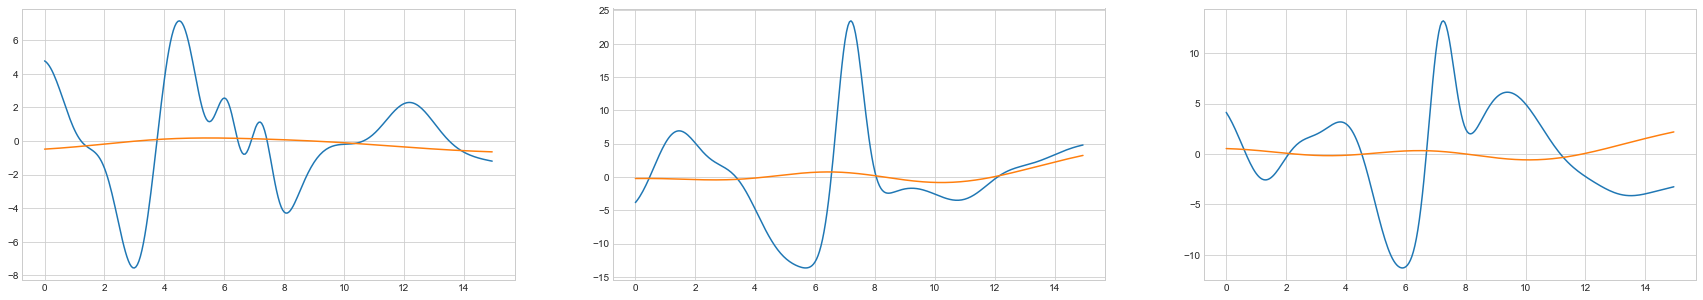

23th additional rbflayer
23th additional RBFlayer 0th epoch loss: 1518.8725555793858
23th additional RBFlayer 999th epoch MSE Loss: 82.70015578500748
23th additional RBFlayer 1999th epoch MSE Loss: 84.0594295237104
23th additional RBFlayer 2999th epoch MSE Loss: 88.69612700905137
23th additional RBFlayer best loss : 81.39402352988772


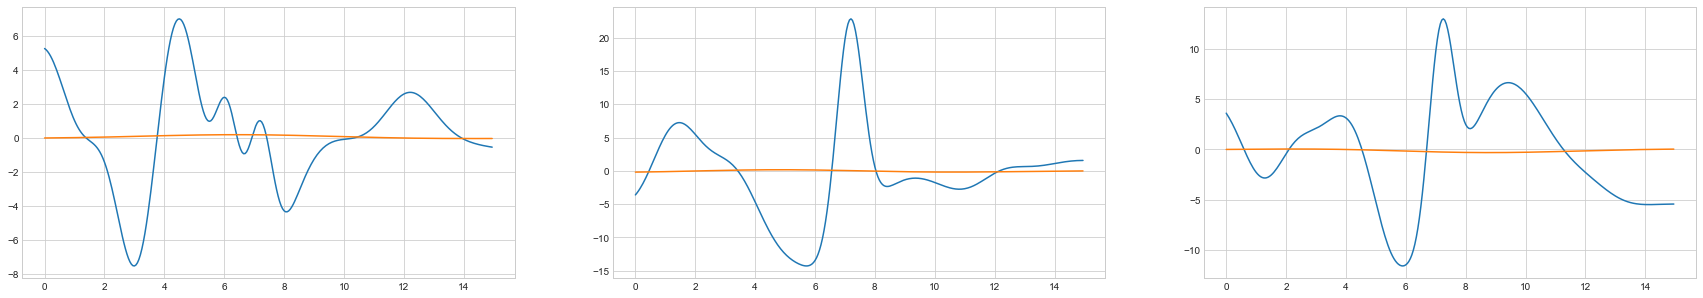

24th additional rbflayer
24th additional RBFlayer 0th epoch loss: 1365.3374474049808
24th additional RBFlayer 999th epoch MSE Loss: 82.4852915072106
24th additional RBFlayer 1999th epoch MSE Loss: 83.06338443106408
24th additional RBFlayer 2999th epoch MSE Loss: 90.6699534376049
24th additional RBFlayer best loss : 81.36627941367657


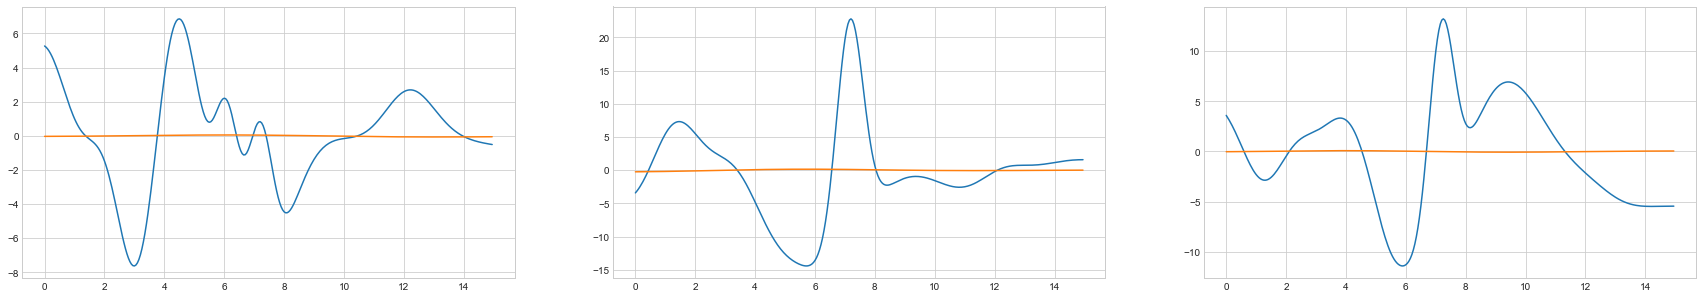

25th additional rbflayer
25th additional RBFlayer 0th epoch loss: 1303.0386530730527
25th additional RBFlayer 999th epoch MSE Loss: 82.24638273539244
25th additional RBFlayer 1999th epoch MSE Loss: 85.31176795970985
25th additional RBFlayer 2999th epoch MSE Loss: 82.7555448036938
25th additional RBFlayer best loss : 81.39073598348561


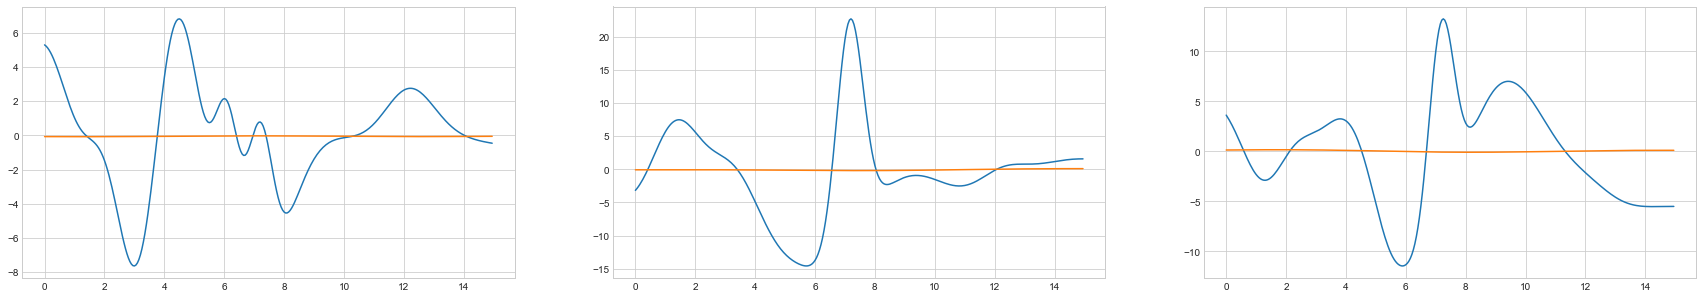

26th additional rbflayer
26th additional RBFlayer 0th epoch loss: 1325.6115433619239
26th additional RBFlayer 999th epoch MSE Loss: 82.01215370640533
26th additional RBFlayer 1999th epoch MSE Loss: 85.44617460918498
26th additional RBFlayer 2999th epoch MSE Loss: 83.42294519695216
26th additional RBFlayer best loss : 81.3534345625857


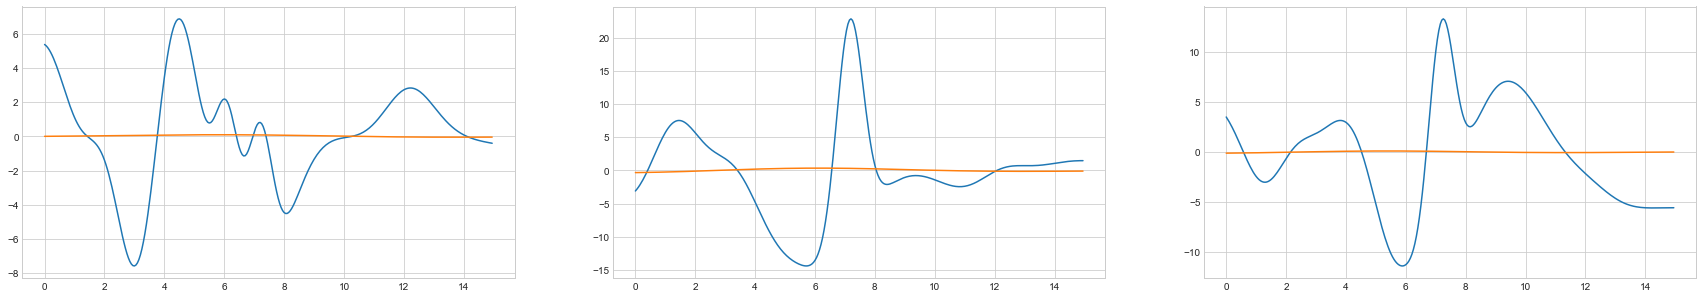

27th additional rbflayer
27th additional RBFlayer 0th epoch loss: 1216.4178172542331
27th additional RBFlayer 999th epoch MSE Loss: 81.8302545786466
27th additional RBFlayer 1999th epoch MSE Loss: 83.81435252242468
27th additional RBFlayer 2999th epoch MSE Loss: 89.78853903648645
27th additional RBFlayer best loss : 81.37699087210015


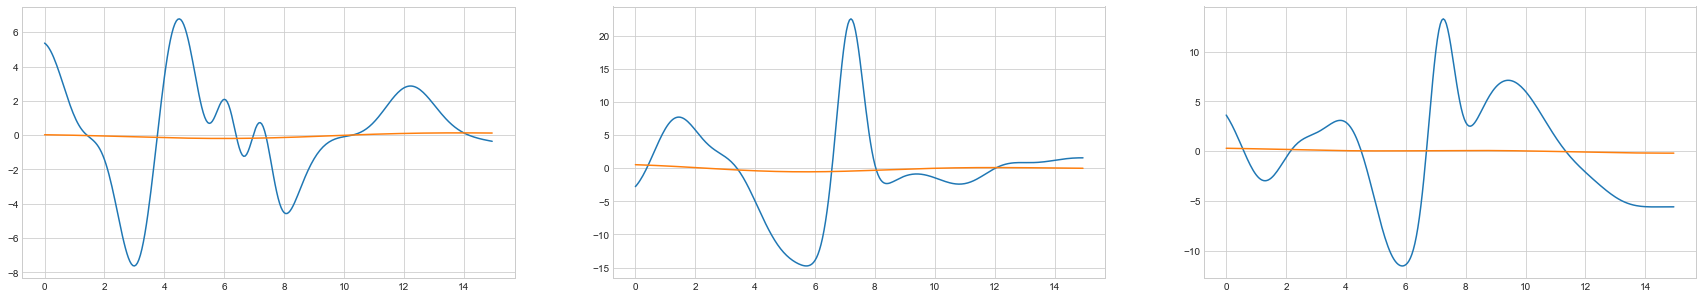

28th additional rbflayer
28th additional RBFlayer 0th epoch loss: 1455.7596109505423
28th additional RBFlayer 999th epoch MSE Loss: 82.2347752775854
28th additional RBFlayer 1999th epoch MSE Loss: 123.57456352452327
28th additional RBFlayer 2999th epoch MSE Loss: 83.77290987753723
28th additional RBFlayer best loss : 81.33977428430187


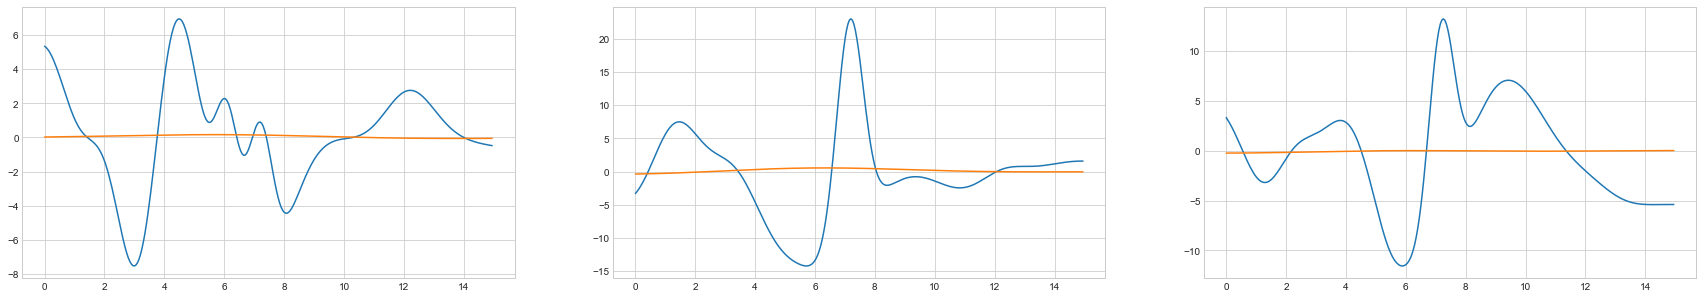

29th additional rbflayer
29th additional RBFlayer 0th epoch loss: 1256.0119061264859
29th additional RBFlayer 999th epoch MSE Loss: 82.01613320648632
29th additional RBFlayer 1999th epoch MSE Loss: 84.621284642608
29th additional RBFlayer 2999th epoch MSE Loss: 82.21146610026203
29th additional RBFlayer best loss : 81.39079296833702


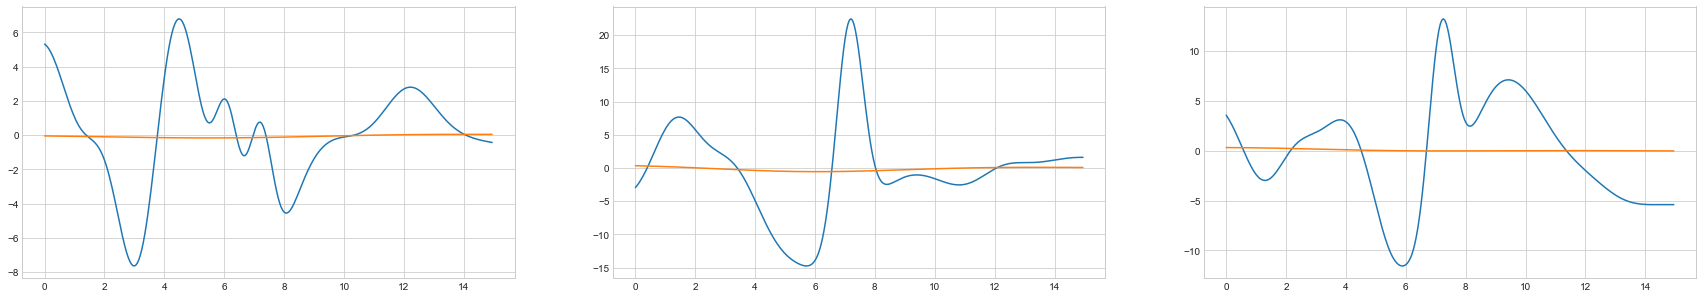

30th additional rbflayer
30th additional RBFlayer 0th epoch loss: 1443.0055674103878
30th additional RBFlayer 999th epoch MSE Loss: 82.14395766494252
30th additional RBFlayer 1999th epoch MSE Loss: 84.7713225618246
30th additional RBFlayer 2999th epoch MSE Loss: 82.2395662481959
30th additional RBFlayer best loss : 81.34060504323068


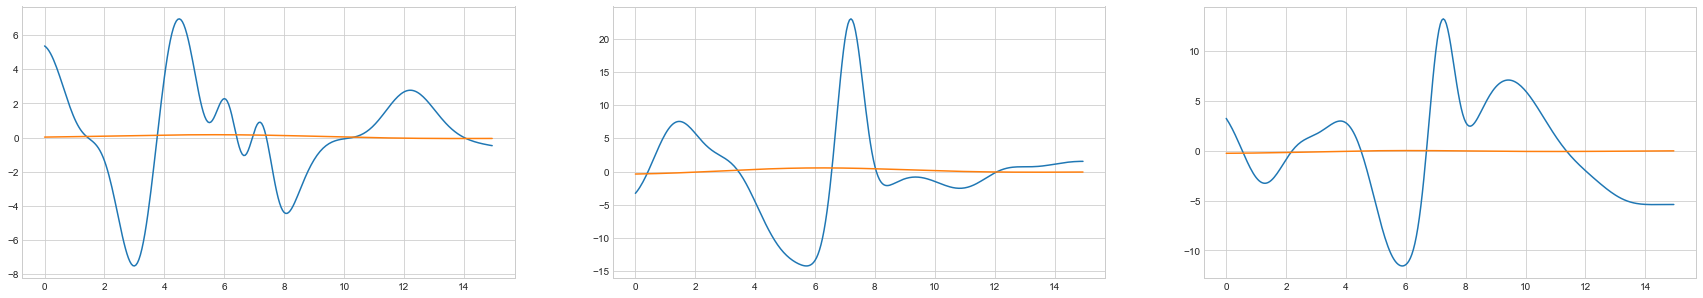

31th additional rbflayer
31th additional RBFlayer 0th epoch loss: 1250.5295875004224
31th additional RBFlayer 999th epoch MSE Loss: 81.95798381191321
31th additional RBFlayer 1999th epoch MSE Loss: 83.8715152896594
31th additional RBFlayer 2999th epoch MSE Loss: 86.01620575622422
31th additional RBFlayer best loss : 81.39191016865217


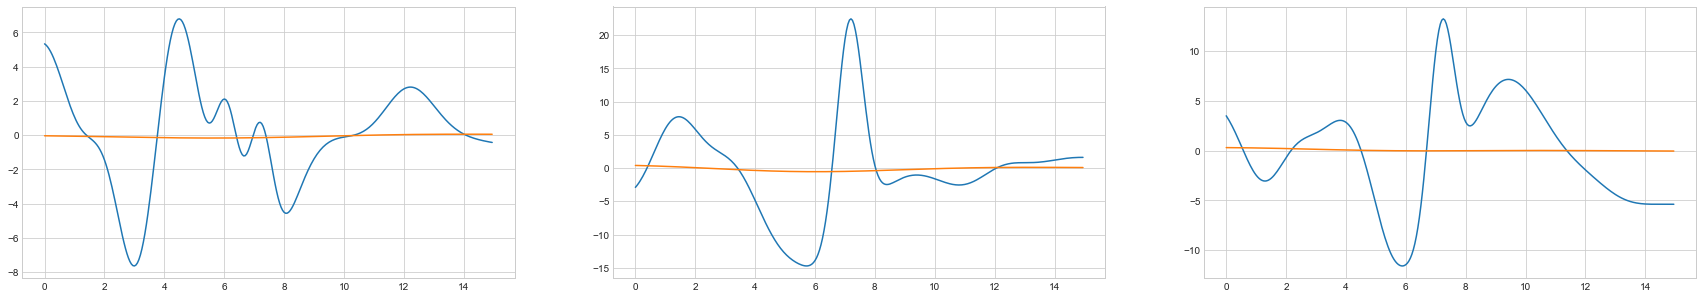

32th additional rbflayer
32th additional RBFlayer 0th epoch loss: 1443.2786784654286
32th additional RBFlayer 999th epoch MSE Loss: 82.1341243524059
32th additional RBFlayer 1999th epoch MSE Loss: 84.18649071870153
32th additional RBFlayer 2999th epoch MSE Loss: 82.03148790849518
32th additional RBFlayer best loss : 81.34215707517217


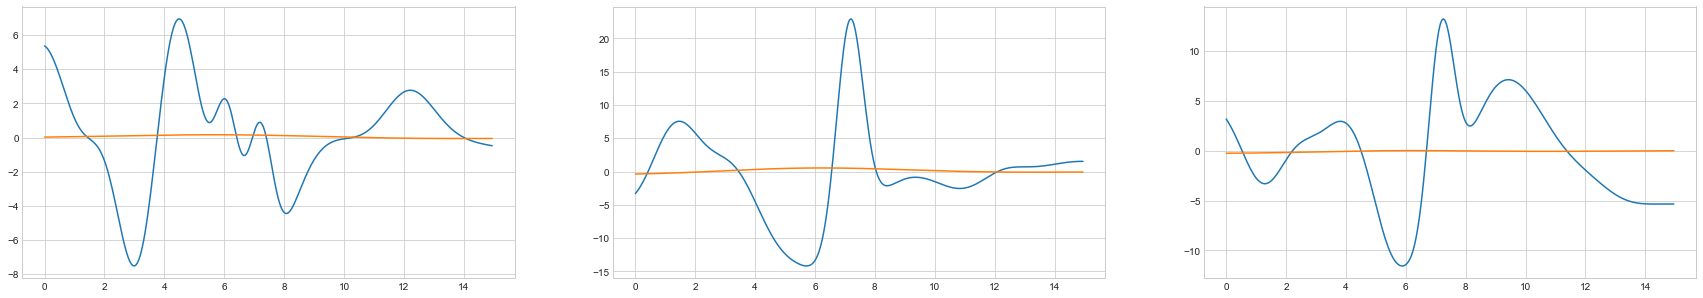

33th additional rbflayer
33th additional RBFlayer 0th epoch loss: 1251.303258515959
33th additional RBFlayer 999th epoch MSE Loss: 81.95458008929893
33th additional RBFlayer 1999th epoch MSE Loss: 83.68876008339676
33th additional RBFlayer 2999th epoch MSE Loss: 83.24643008557774
33th additional RBFlayer best loss : 81.39430327717452


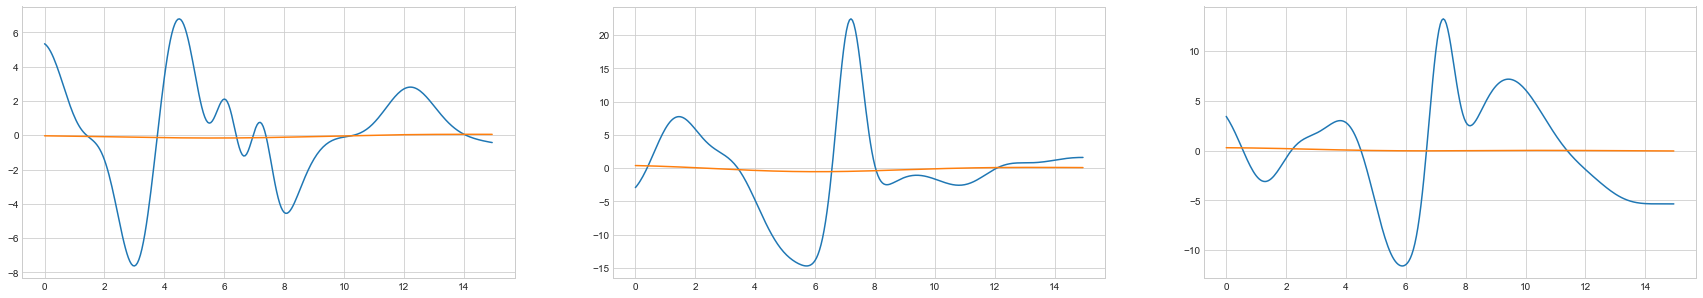

34th additional rbflayer
34th additional RBFlayer 0th epoch loss: 1441.0892267199274
34th additional RBFlayer 999th epoch MSE Loss: 82.12247844701132
34th additional RBFlayer 1999th epoch MSE Loss: 83.89128155866636
34th additional RBFlayer 2999th epoch MSE Loss: 85.84313902674806
34th additional RBFlayer best loss : 81.34271717903317


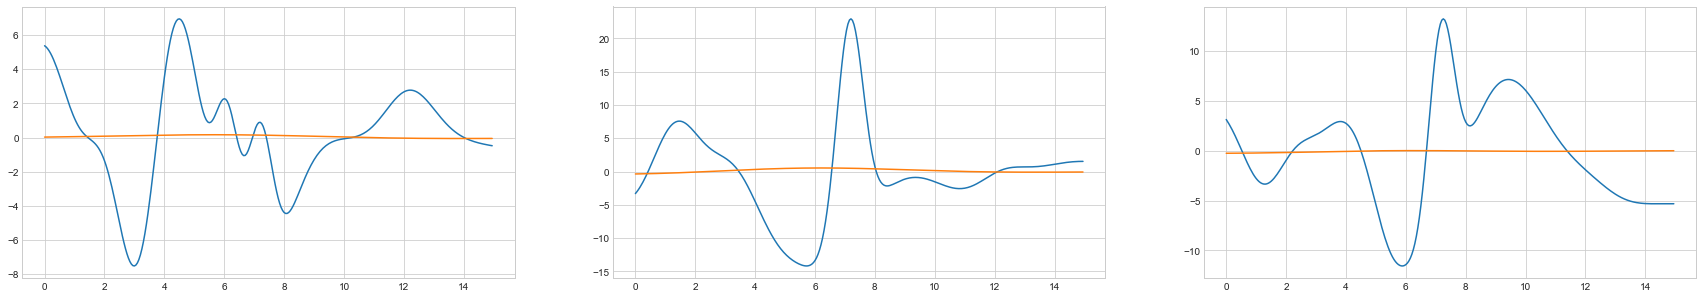

35th additional rbflayer
35th additional RBFlayer 0th epoch loss: 1250.7746395611728
35th additional RBFlayer 999th epoch MSE Loss: 81.95162143232844
35th additional RBFlayer 1999th epoch MSE Loss: 83.57839478554796
35th additional RBFlayer 2999th epoch MSE Loss: 84.67217648727026
35th additional RBFlayer best loss : 81.39532369880294


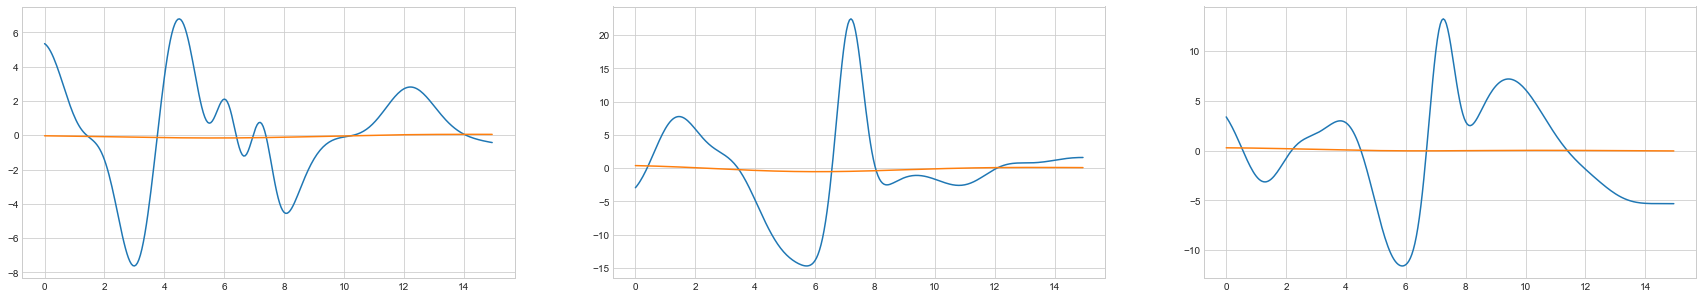

36th additional rbflayer
36th additional RBFlayer 0th epoch loss: 1438.2779244240899
36th additional RBFlayer 999th epoch MSE Loss: 82.11577744766784
36th additional RBFlayer 1999th epoch MSE Loss: 83.7382556944495
36th additional RBFlayer 2999th epoch MSE Loss: 82.99367450816816
36th additional RBFlayer best loss : 81.34258838637439


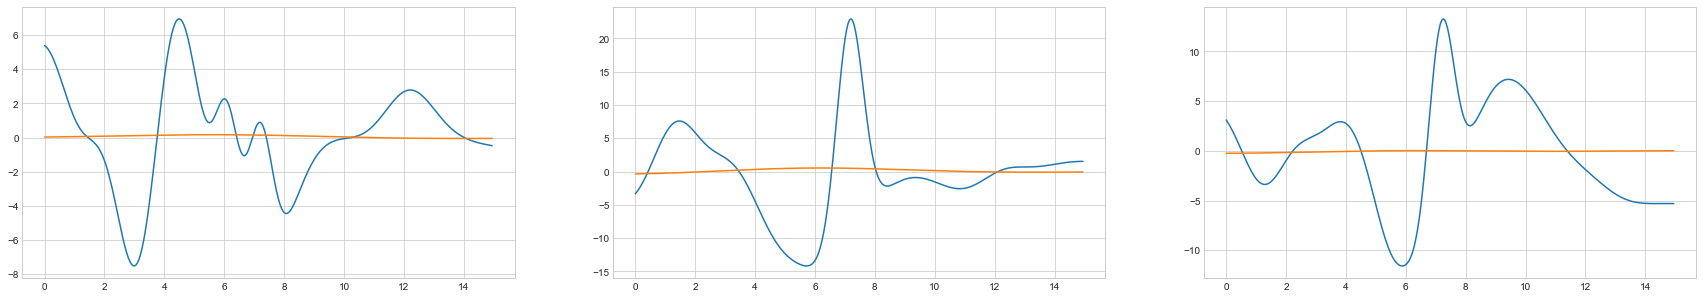

37th additional rbflayer
37th additional RBFlayer 0th epoch loss: 1249.7185904804064
37th additional RBFlayer 999th epoch MSE Loss: 81.95176768643996
37th additional RBFlayer 1999th epoch MSE Loss: 83.51434367049156
37th additional RBFlayer 2999th epoch MSE Loss: 83.00721647470526
37th additional RBFlayer best loss : 81.39538697431581


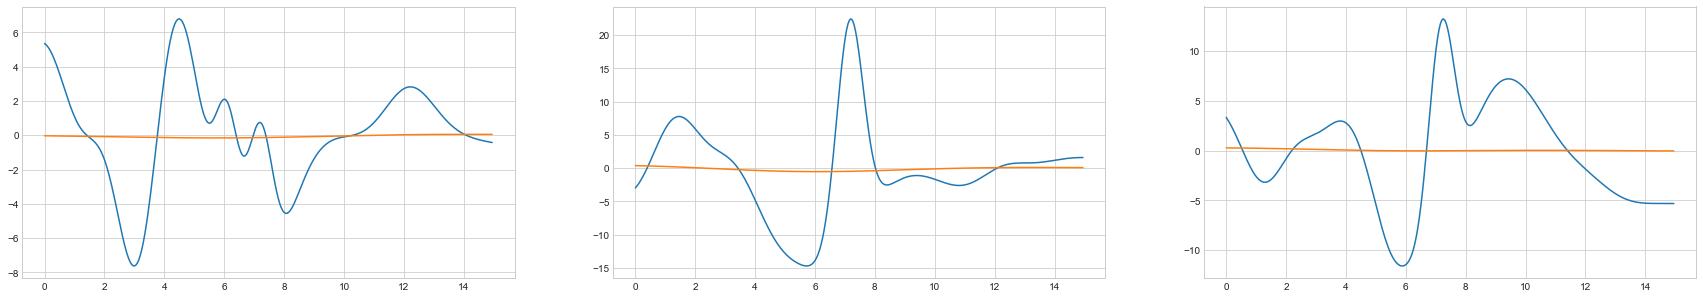

38th additional rbflayer
38th additional RBFlayer 0th epoch loss: 1435.6549977267803
38th additional RBFlayer 999th epoch MSE Loss: 82.11454613205444
38th additional RBFlayer 1999th epoch MSE Loss: 83.65693740254378
38th additional RBFlayer 2999th epoch MSE Loss: 82.57353944726142
38th additional RBFlayer best loss : 81.3417833875998


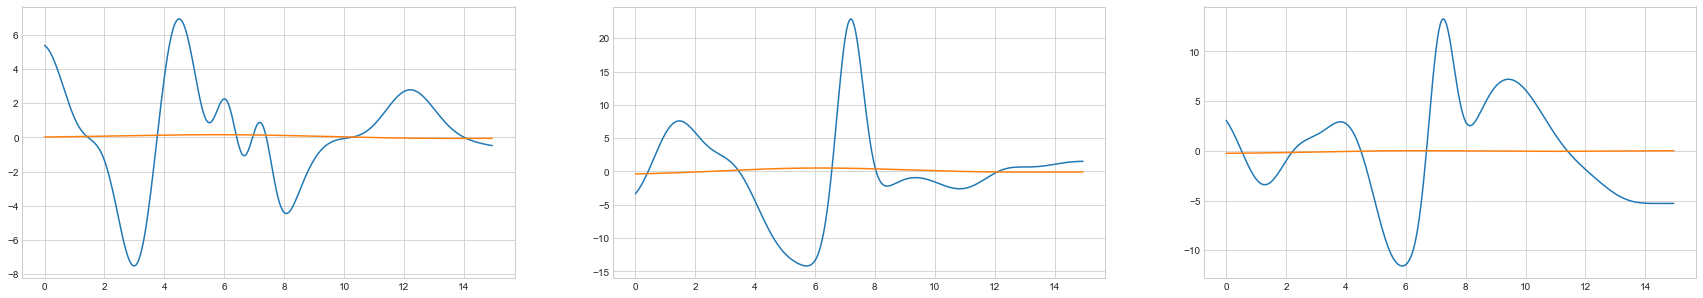

39th additional rbflayer
39th additional RBFlayer 0th epoch loss: 1248.680609403471
39th additional RBFlayer 999th epoch MSE Loss: 81.9563893664318
39th additional RBFlayer 1999th epoch MSE Loss: 83.48405009543015
39th additional RBFlayer 2999th epoch MSE Loss: 93.60854429171374
39th additional RBFlayer best loss : 81.39482856300268


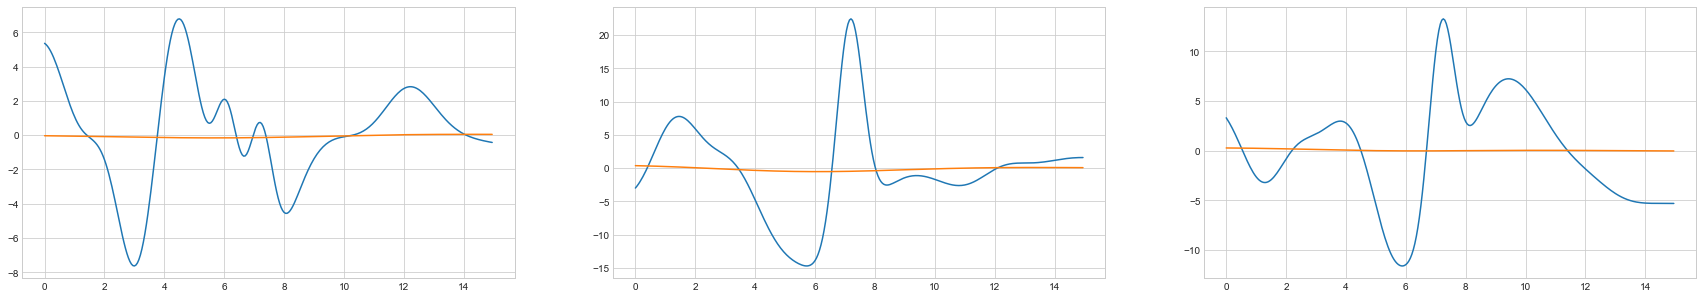

40th additional rbflayer
40th additional RBFlayer 0th epoch loss: 1432.6688045861893
40th additional RBFlayer 999th epoch MSE Loss: 82.11527690051282
40th additional RBFlayer 1999th epoch MSE Loss: 83.60920415345862
40th additional RBFlayer 2999th epoch MSE Loss: 82.12817209771944
40th additional RBFlayer best loss : 81.34047233277501


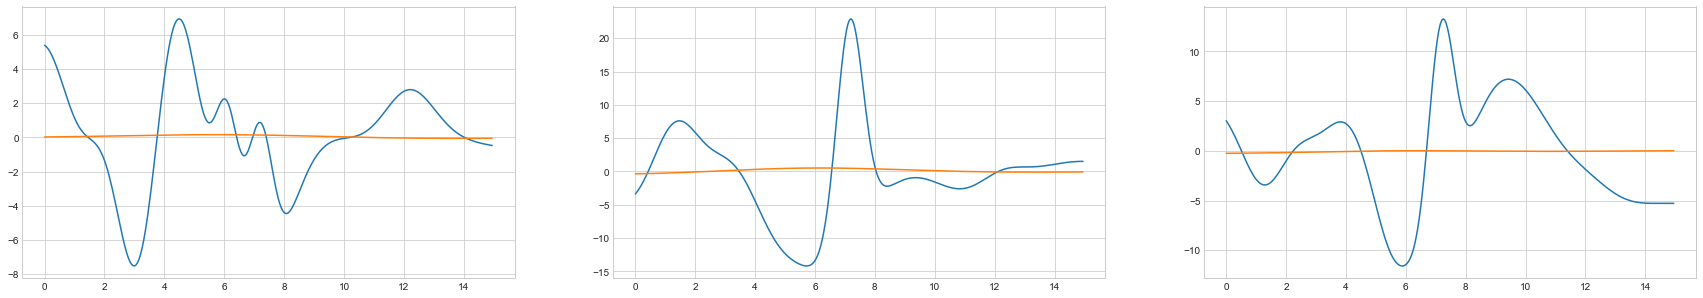

41th additional rbflayer
41th additional RBFlayer 0th epoch loss: 1247.3605683206708
41th additional RBFlayer 999th epoch MSE Loss: 81.96251385876408
41th additional RBFlayer 1999th epoch MSE Loss: 83.4709604516697
41th additional RBFlayer 2999th epoch MSE Loss: 86.6952953112697
41th additional RBFlayer best loss : 81.39372645624661


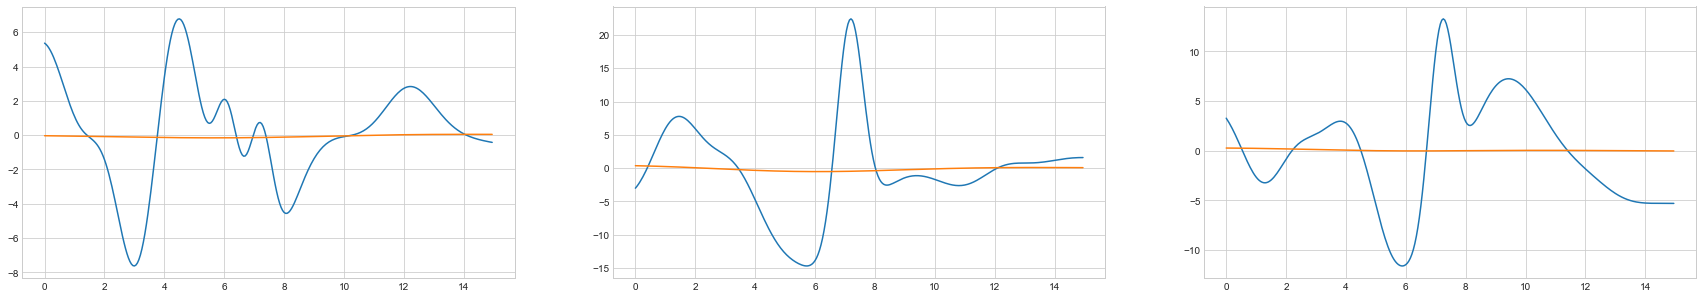

42th additional rbflayer
42th additional RBFlayer 0th epoch loss: 1428.7795601139253
42th additional RBFlayer 999th epoch MSE Loss: 82.11520031483613
42th additional RBFlayer 1999th epoch MSE Loss: 83.57638417719336
42th additional RBFlayer 2999th epoch MSE Loss: 82.62686887034324
42th additional RBFlayer best loss : 81.33886479679087


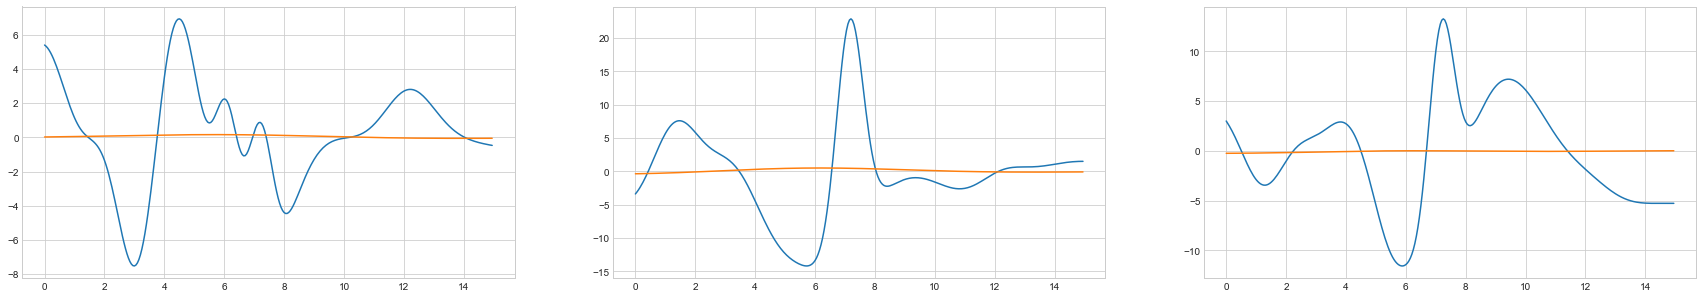

43th additional rbflayer
43th additional RBFlayer 0th epoch loss: 1245.430011224126
43th additional RBFlayer 999th epoch MSE Loss: 81.96739372353862
43th additional RBFlayer 1999th epoch MSE Loss: 83.46347721773381
43th additional RBFlayer 2999th epoch MSE Loss: 81.88112636288801
43th additional RBFlayer best loss : 81.39213278341308


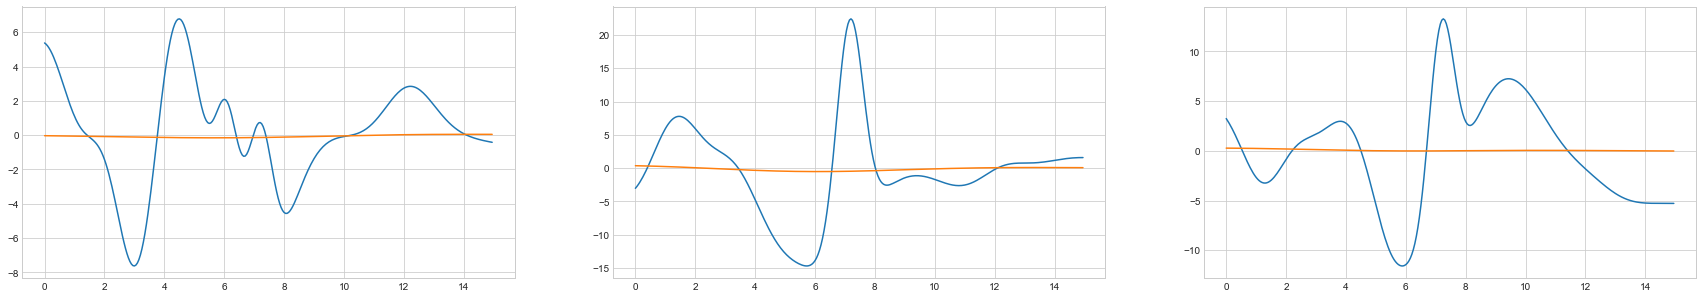

44th additional rbflayer
44th additional RBFlayer 0th epoch loss: 1425.3574529555083
44th additional RBFlayer 999th epoch MSE Loss: 82.11871606871505
44th additional RBFlayer 1999th epoch MSE Loss: 83.56474745292843
44th additional RBFlayer 2999th epoch MSE Loss: 82.58473577759963
44th additional RBFlayer best loss : 81.33701094170205


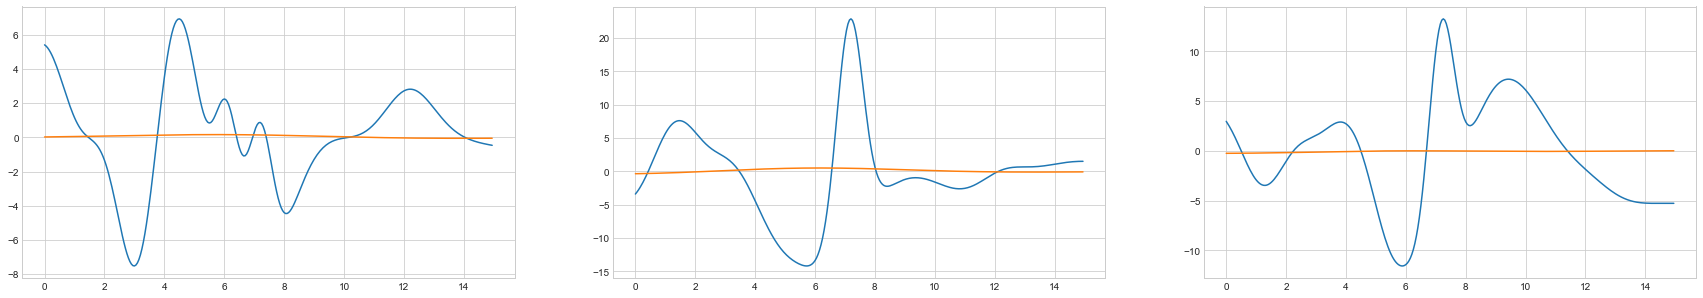

45th additional rbflayer
45th additional RBFlayer 0th epoch loss: 1243.7271644497591
45th additional RBFlayer 999th epoch MSE Loss: 81.97536677541984
45th additional RBFlayer 1999th epoch MSE Loss: 83.47062088829877
45th additional RBFlayer 2999th epoch MSE Loss: 83.17905554671358
45th additional RBFlayer best loss : 81.39041972314257


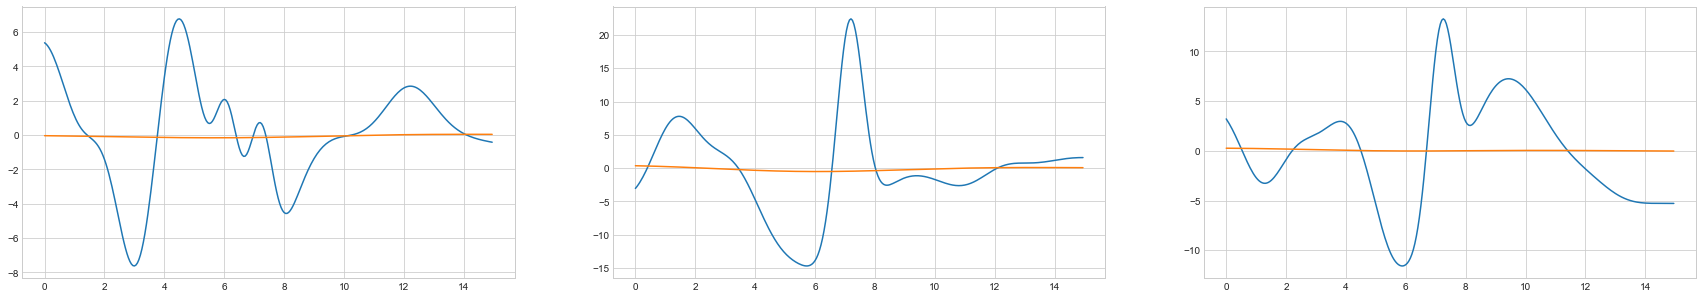

46th additional rbflayer
46th additional RBFlayer 0th epoch loss: 1421.7552174269988
46th additional RBFlayer 999th epoch MSE Loss: 82.1228103345297
46th additional RBFlayer 1999th epoch MSE Loss: 83.56217242938949
46th additional RBFlayer 2999th epoch MSE Loss: 83.47604681183742
46th additional RBFlayer best loss : 81.33500945680127


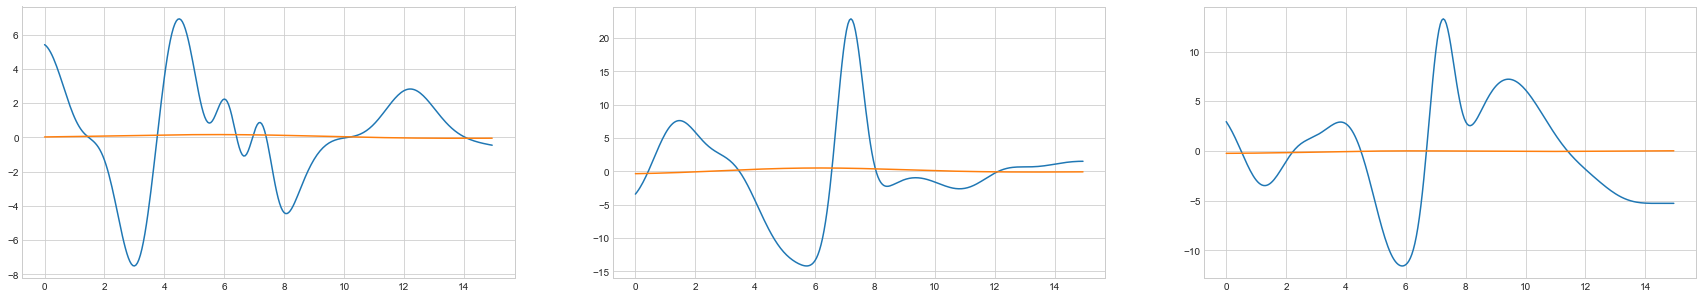

47th additional rbflayer
47th additional RBFlayer 0th epoch loss: 1241.8913120707234
47th additional RBFlayer 999th epoch MSE Loss: 81.98387048650541
47th additional RBFlayer 1999th epoch MSE Loss: 83.4842576598957
47th additional RBFlayer 2999th epoch MSE Loss: 82.50037271303367
47th additional RBFlayer best loss : 81.38856762604368


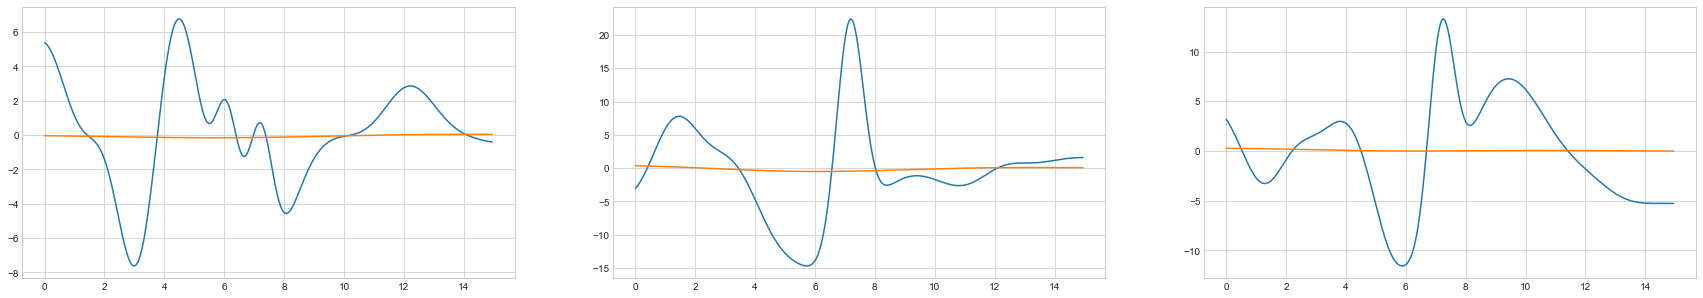

48th additional rbflayer
48th additional RBFlayer 0th epoch loss: 1418.003152162993
48th additional RBFlayer 999th epoch MSE Loss: 82.12738601107004
48th additional RBFlayer 1999th epoch MSE Loss: 83.56660692713956
48th additional RBFlayer 2999th epoch MSE Loss: 83.7095927751839
48th additional RBFlayer best loss : 81.33296282893016


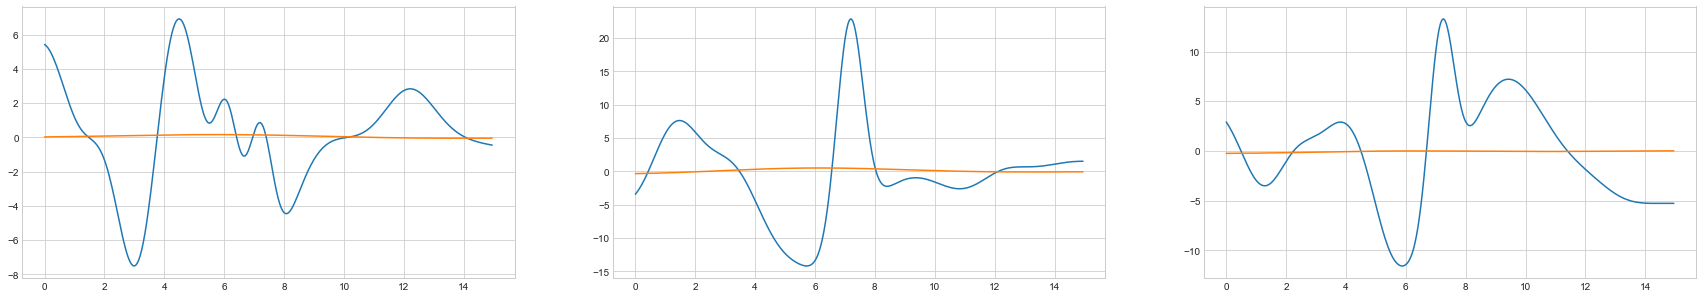

49th additional rbflayer
49th additional RBFlayer 0th epoch loss: 1239.9364991267796
49th additional RBFlayer 999th epoch MSE Loss: 81.99269686446266
49th additional RBFlayer 1999th epoch MSE Loss: 83.50284611440645
49th additional RBFlayer 2999th epoch MSE Loss: 102.43813962810452
49th additional RBFlayer best loss : 81.3866555980081


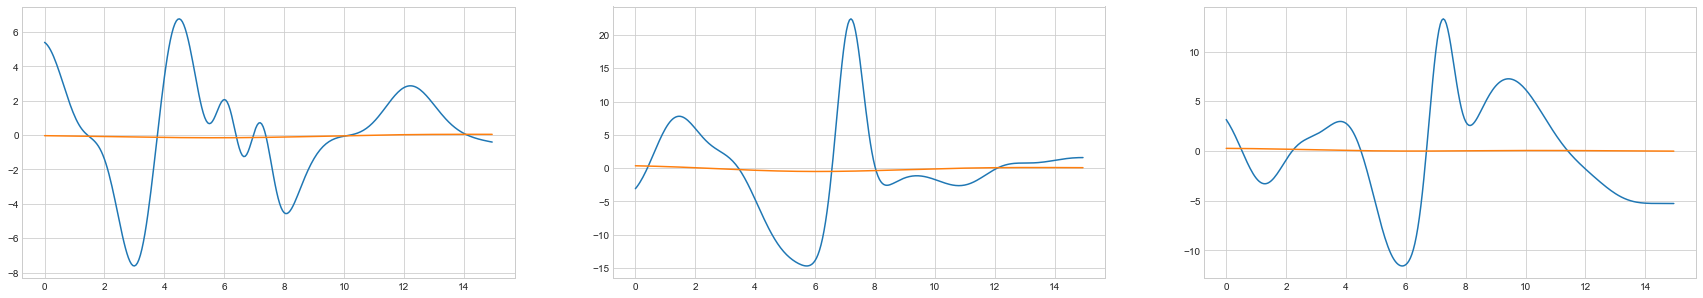

50th additional rbflayer
50th additional RBFlayer 0th epoch loss: 1414.116343681808
50th additional RBFlayer 999th epoch MSE Loss: 82.13225447267496
50th additional RBFlayer 1999th epoch MSE Loss: 83.57628386113683
50th additional RBFlayer 2999th epoch MSE Loss: 83.27741165076785
50th additional RBFlayer best loss : 81.33093218934263


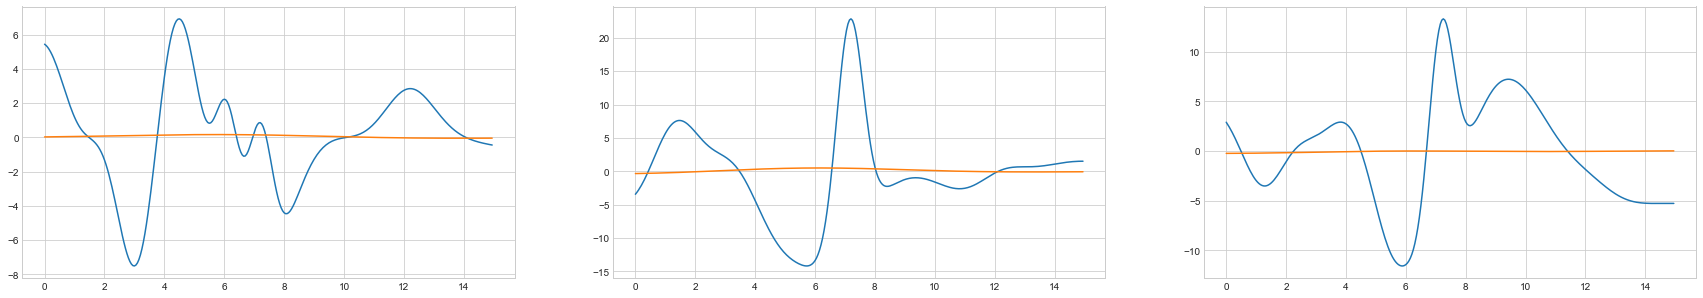

51th additional rbflayer
51th additional RBFlayer 0th epoch loss: 1237.8778938622788
51th additional RBFlayer 999th epoch MSE Loss: 82.00169982587836
51th additional RBFlayer 1999th epoch MSE Loss: 83.52542961468684
51th additional RBFlayer 2999th epoch MSE Loss: 86.53337710736727
51th additional RBFlayer best loss : 81.38474365171949


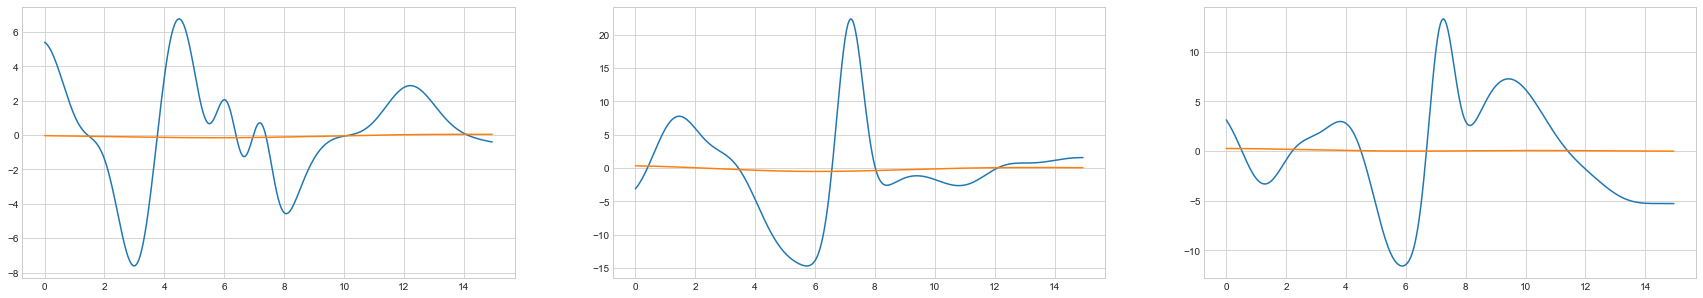

52th additional rbflayer
52th additional RBFlayer 0th epoch loss: 1410.103536091214
52th additional RBFlayer 999th epoch MSE Loss: 82.13726647954907
52th additional RBFlayer 1999th epoch MSE Loss: 83.58997173425745
52th additional RBFlayer 2999th epoch MSE Loss: 84.54188750889692
52th additional RBFlayer best loss : 81.3289643813491


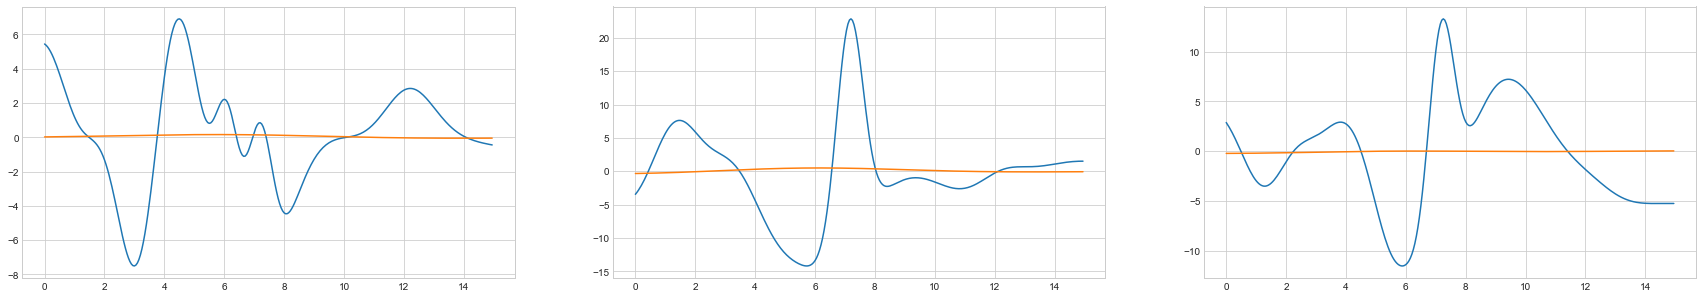

53th additional rbflayer
53th additional RBFlayer 0th epoch loss: 1235.725184375911
53th additional RBFlayer 999th epoch MSE Loss: 82.01075808380494
53th additional RBFlayer 1999th epoch MSE Loss: 83.55132424872312
53th additional RBFlayer 2999th epoch MSE Loss: 87.14927978629886
53th additional RBFlayer best loss : 81.38287669215545


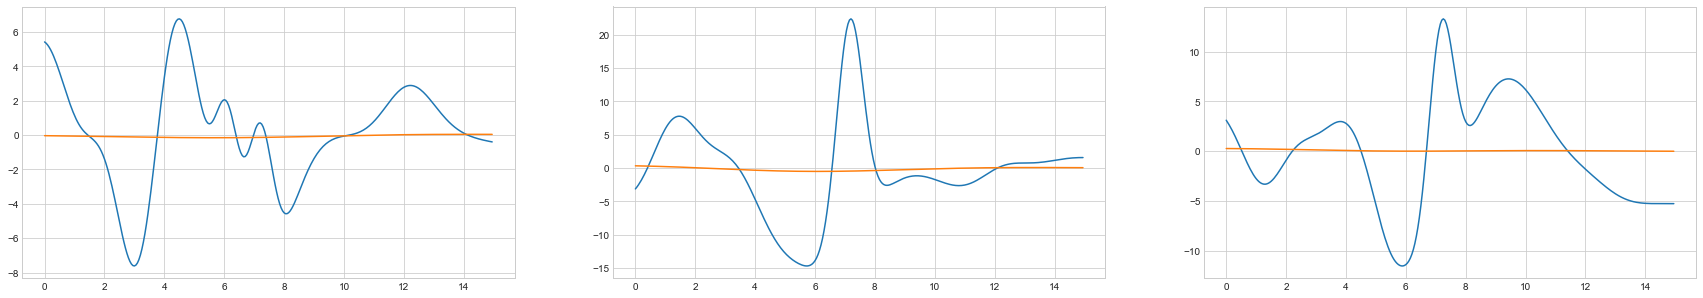

54th additional rbflayer
54th additional RBFlayer 0th epoch loss: 1405.9691739613077
54th additional RBFlayer 999th epoch MSE Loss: 82.1423013921095
54th additional RBFlayer 1999th epoch MSE Loss: 83.60677234947636
54th additional RBFlayer 2999th epoch MSE Loss: 82.34890674695822
54th additional RBFlayer best loss : 81.32709504758415


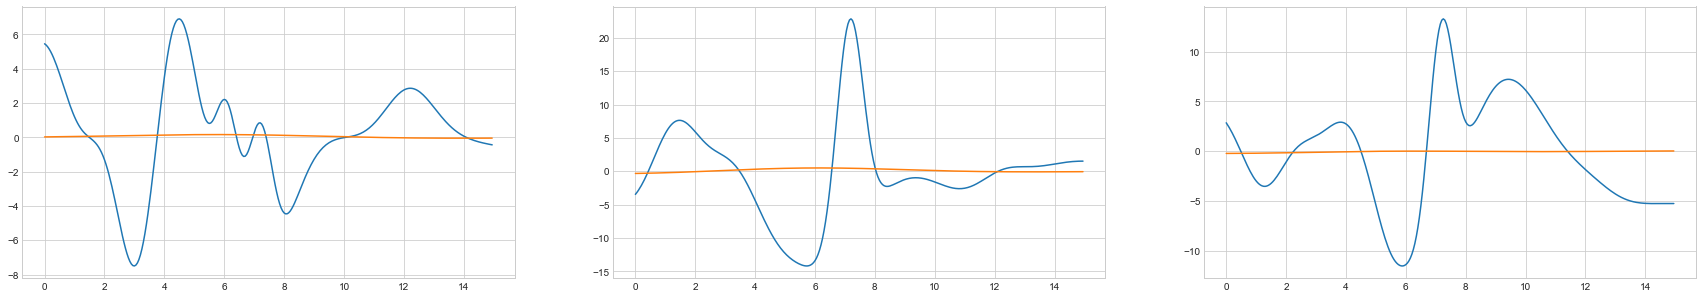

55th additional rbflayer
55th additional RBFlayer 0th epoch loss: 1233.4841939206449
55th additional RBFlayer 999th epoch MSE Loss: 82.01976868043434
55th additional RBFlayer 1999th epoch MSE Loss: 83.58002121412466
55th additional RBFlayer 2999th epoch MSE Loss: 82.33721883465881
55th additional RBFlayer best loss : 81.38108759249324


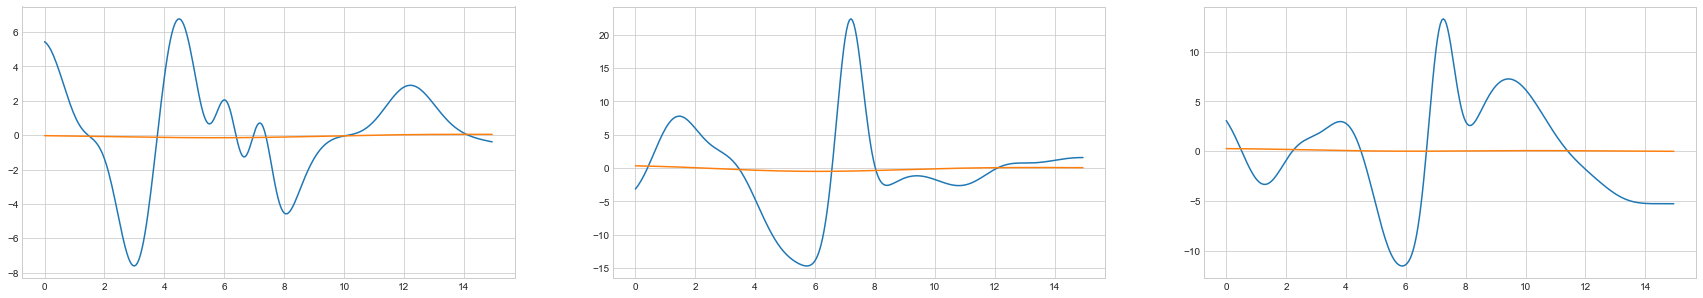

56th additional rbflayer
56th additional RBFlayer 0th epoch loss: 1402.3470176641363
56th additional RBFlayer 999th epoch MSE Loss: 82.14956853261559
56th additional RBFlayer 1999th epoch MSE Loss: 83.63295345720078
56th additional RBFlayer 2999th epoch MSE Loss: 82.01238645546728
56th additional RBFlayer best loss : 81.32530712881497


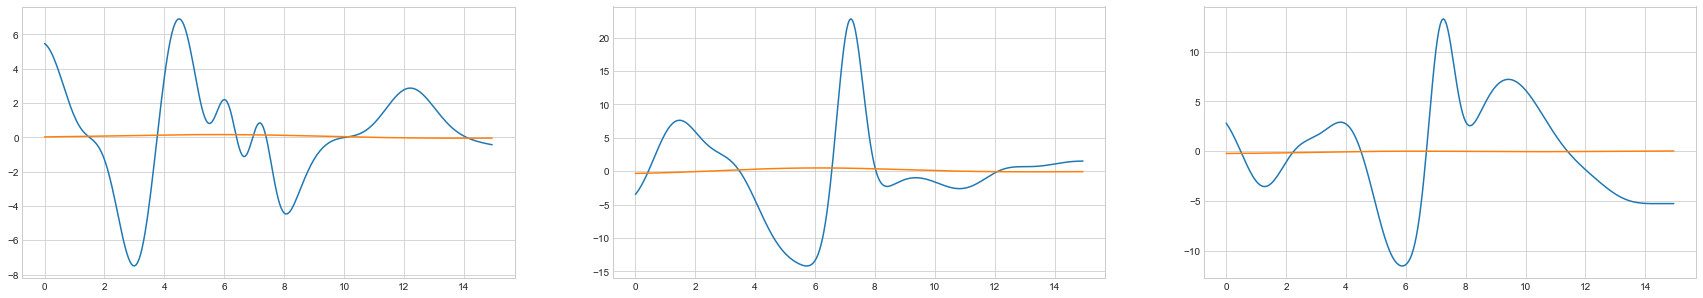

57th additional rbflayer
57th additional RBFlayer 0th epoch loss: 1231.5561032528228
57th additional RBFlayer 999th epoch MSE Loss: 82.03102625898454
57th additional RBFlayer 1999th epoch MSE Loss: 83.619026198792
57th additional RBFlayer 2999th epoch MSE Loss: 82.67427366714296
57th additional RBFlayer best loss : 81.3795226012192


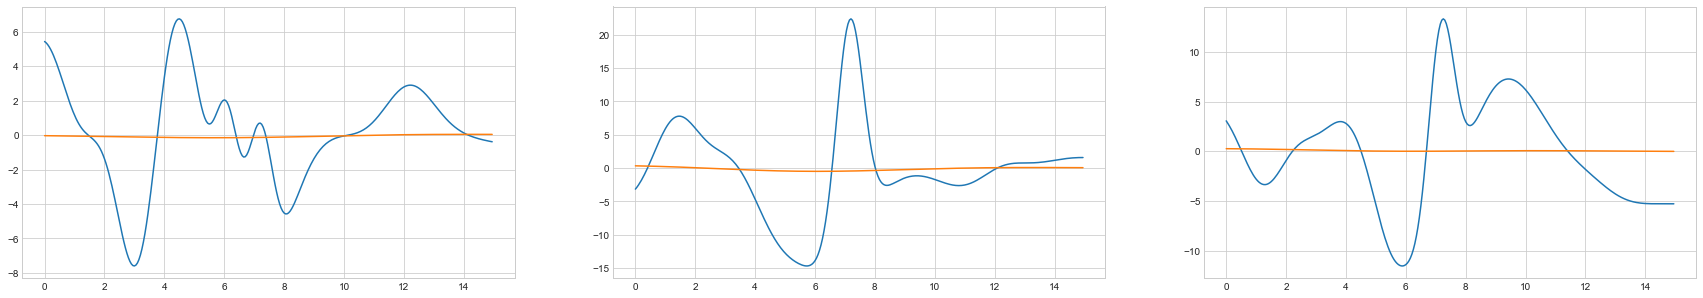

58th additional rbflayer
58th additional RBFlayer 0th epoch loss: 1398.562080603932
58th additional RBFlayer 999th epoch MSE Loss: 82.15643237129865
58th additional RBFlayer 1999th epoch MSE Loss: 83.66068743655279
58th additional RBFlayer 2999th epoch MSE Loss: 83.46474282393206
58th additional RBFlayer best loss : 81.32363605956542


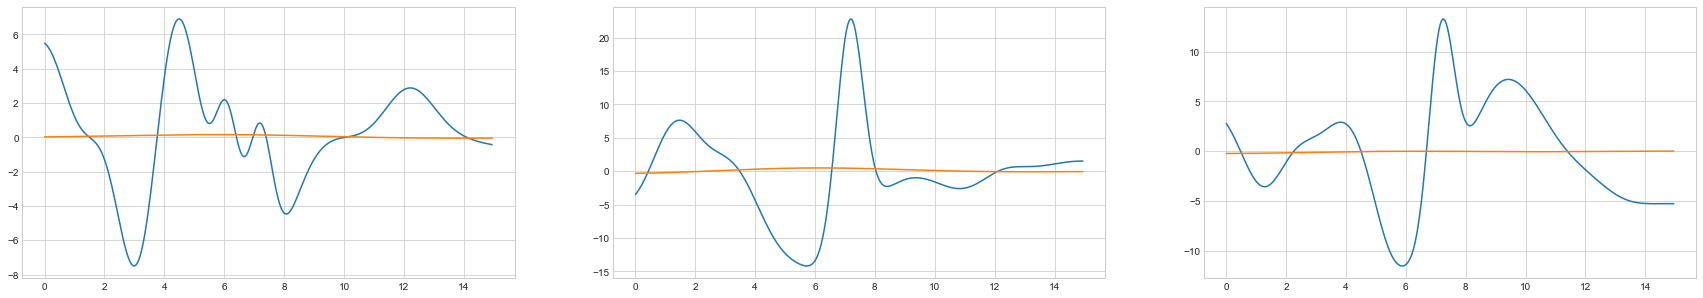

59th additional rbflayer
59th additional RBFlayer 0th epoch loss: 1229.5258446055325
59th additional RBFlayer 999th epoch MSE Loss: 82.04199491138637
59th additional RBFlayer 1999th epoch MSE Loss: 83.66095561016839
59th additional RBFlayer 2999th epoch MSE Loss: 83.53093548125808
59th additional RBFlayer best loss : 81.37806684819745


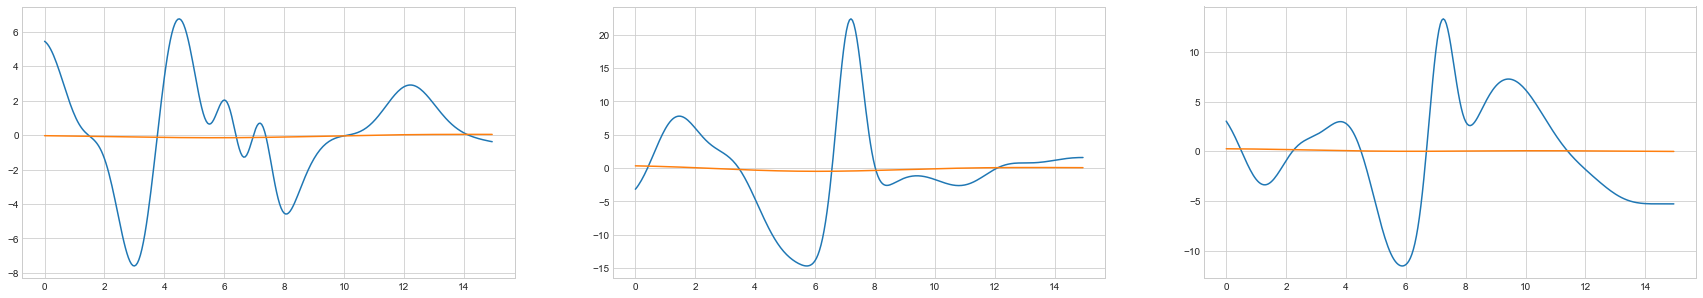

60th additional rbflayer
60th additional RBFlayer 0th epoch loss: 1394.6156963957335
60th additional RBFlayer 999th epoch MSE Loss: 82.16295840217623
60th additional RBFlayer 1999th epoch MSE Loss: 83.69015337217537
60th additional RBFlayer 2999th epoch MSE Loss: 81.81120432514936
60th additional RBFlayer best loss : 81.32211607616065


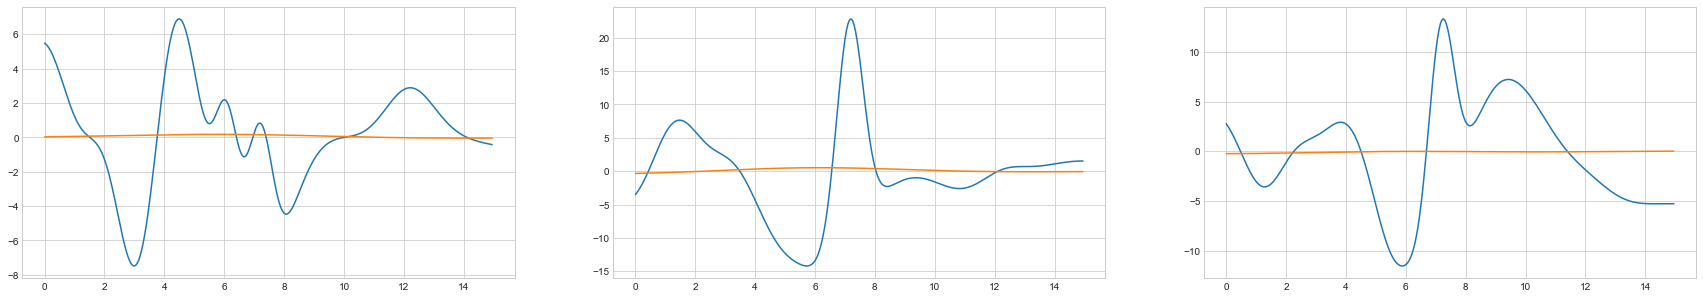

61th additional rbflayer
61th additional RBFlayer 0th epoch loss: 1216.0259809806028
61th additional RBFlayer 999th epoch MSE Loss: 82.05426333486001
61th additional RBFlayer 1999th epoch MSE Loss: 83.72399494047528
61th additional RBFlayer 2999th epoch MSE Loss: 82.9331304406899
61th additional RBFlayer best loss : 81.37719433686291


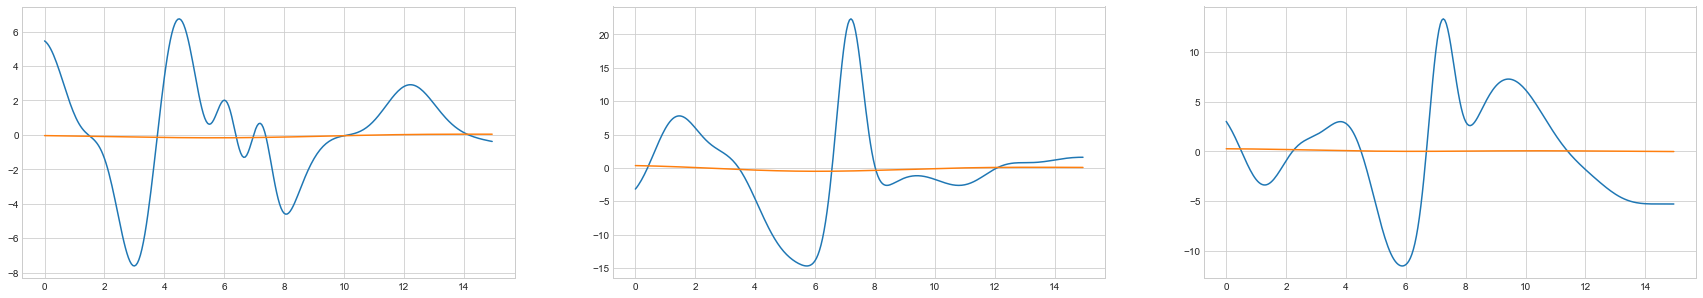

62th additional rbflayer
62th additional RBFlayer 0th epoch loss: 1390.927407028696
62th additional RBFlayer 999th epoch MSE Loss: 82.16936630228011
62th additional RBFlayer 1999th epoch MSE Loss: 83.70806176686709
62th additional RBFlayer 2999th epoch MSE Loss: 82.7880899669933
62th additional RBFlayer best loss : 81.32124833801772


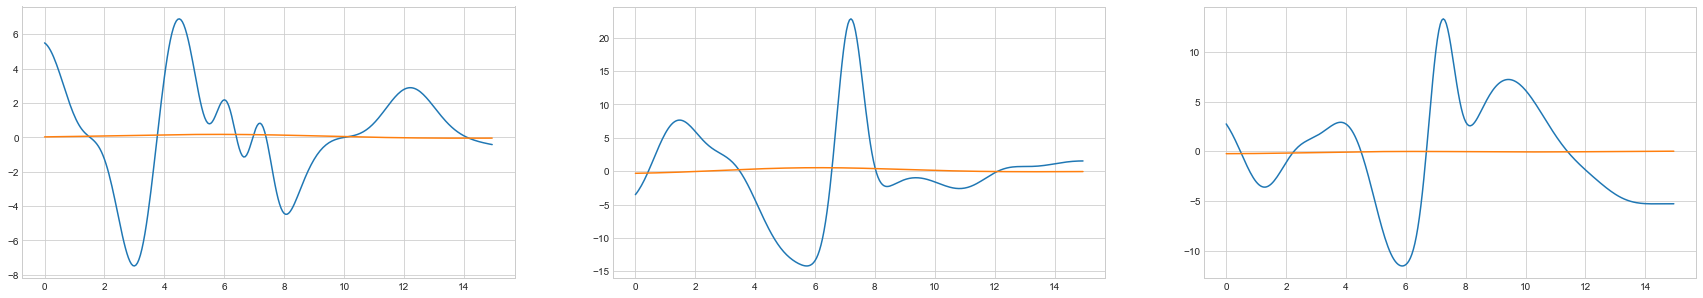

63th additional rbflayer
63th additional RBFlayer 0th epoch loss: 1214.1230087968497
63th additional RBFlayer 999th epoch MSE Loss: 82.06450407149651
63th additional RBFlayer 1999th epoch MSE Loss: 83.76122289343088
63th additional RBFlayer 2999th epoch MSE Loss: 83.33811183161728
63th additional RBFlayer best loss : 81.37647387851725


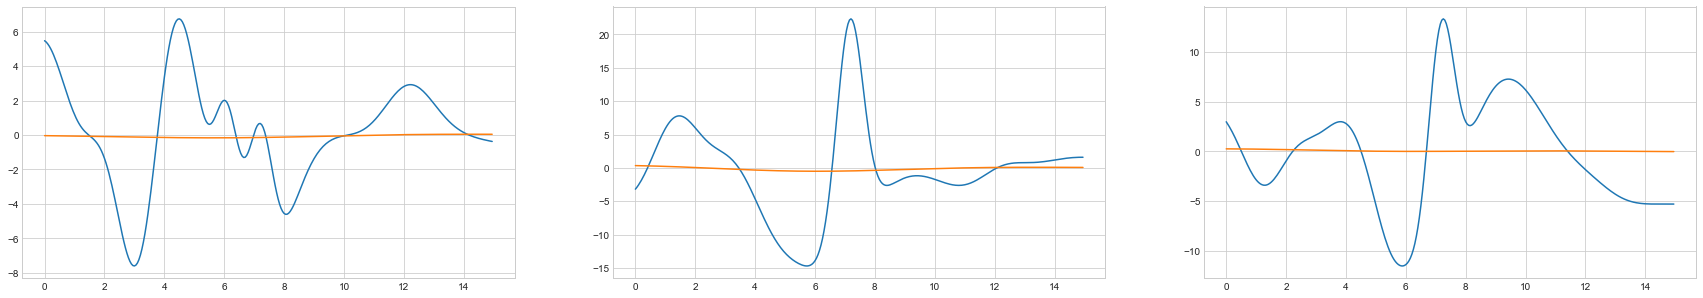

64th additional rbflayer
64th additional RBFlayer 0th epoch loss: 1387.0028426002084
64th additional RBFlayer 999th epoch MSE Loss: 82.17529211312542
64th additional RBFlayer 1999th epoch MSE Loss: 83.72963319310817
64th additional RBFlayer 2999th epoch MSE Loss: 82.10598373544923
64th additional RBFlayer best loss : 81.32034218089437


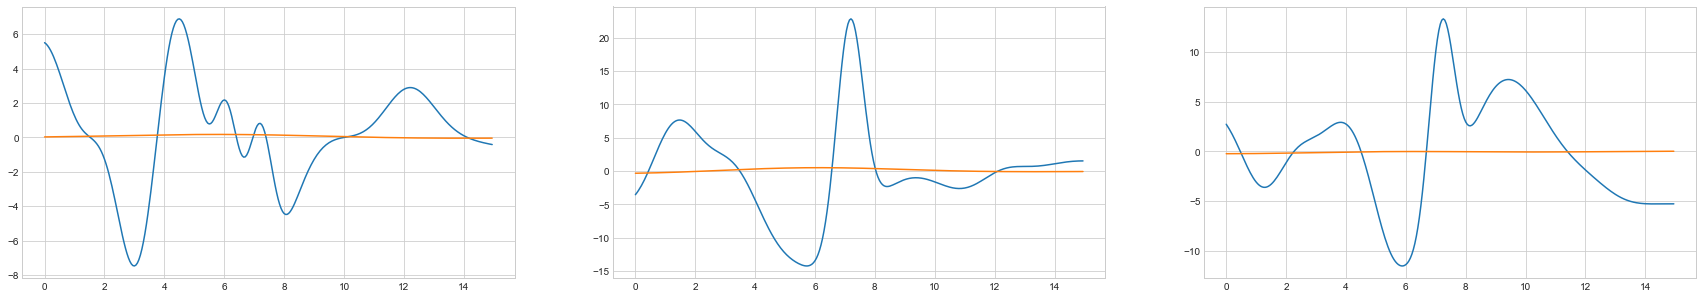

65th additional rbflayer
65th additional RBFlayer 0th epoch loss: 1212.1029311170832
65th additional RBFlayer 999th epoch MSE Loss: 82.07463719685433
65th additional RBFlayer 1999th epoch MSE Loss: 83.8049810533598
65th additional RBFlayer 2999th epoch MSE Loss: 83.48753712107033
65th additional RBFlayer best loss : 81.37572520738922


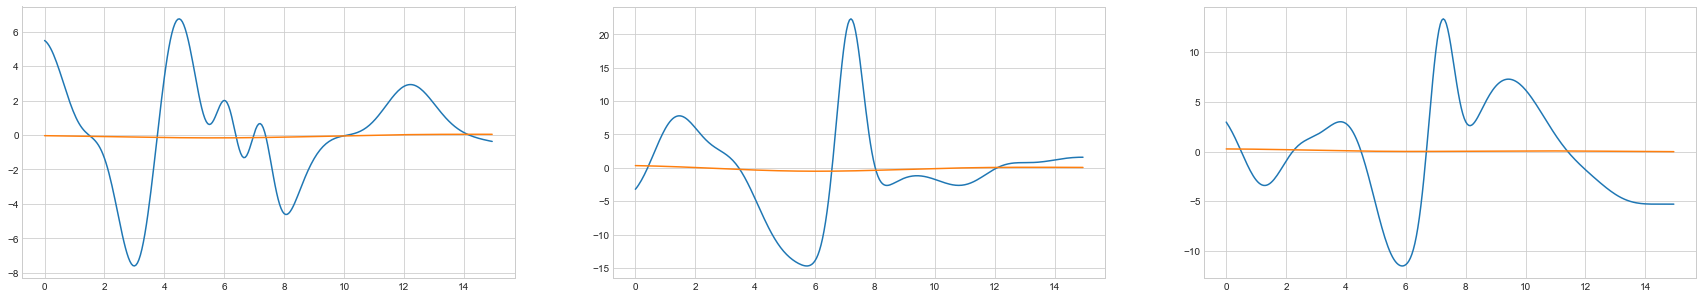

66th additional rbflayer
66th additional RBFlayer 0th epoch loss: 1383.5083133865749
66th additional RBFlayer 999th epoch MSE Loss: 82.18330597235965
66th additional RBFlayer 1999th epoch MSE Loss: 83.76414462317803
66th additional RBFlayer 2999th epoch MSE Loss: 81.96591673762032
66th additional RBFlayer best loss : 81.3194570938001


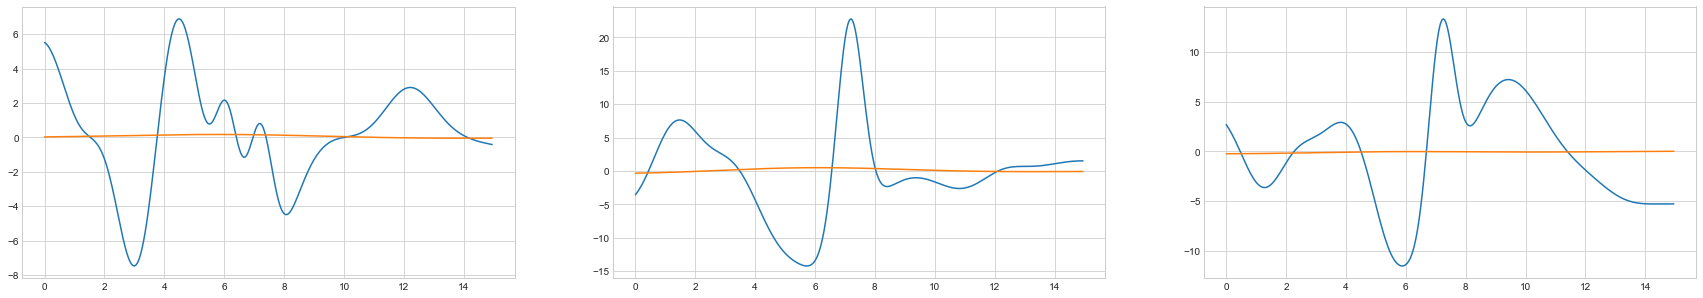

67th additional rbflayer
67th additional RBFlayer 0th epoch loss: 1210.3490624502924
67th additional RBFlayer 999th epoch MSE Loss: 82.0869472763521
67th additional RBFlayer 1999th epoch MSE Loss: 83.86591233182358
67th additional RBFlayer 2999th epoch MSE Loss: 87.48204565741298
67th additional RBFlayer best loss : 81.37513480135097


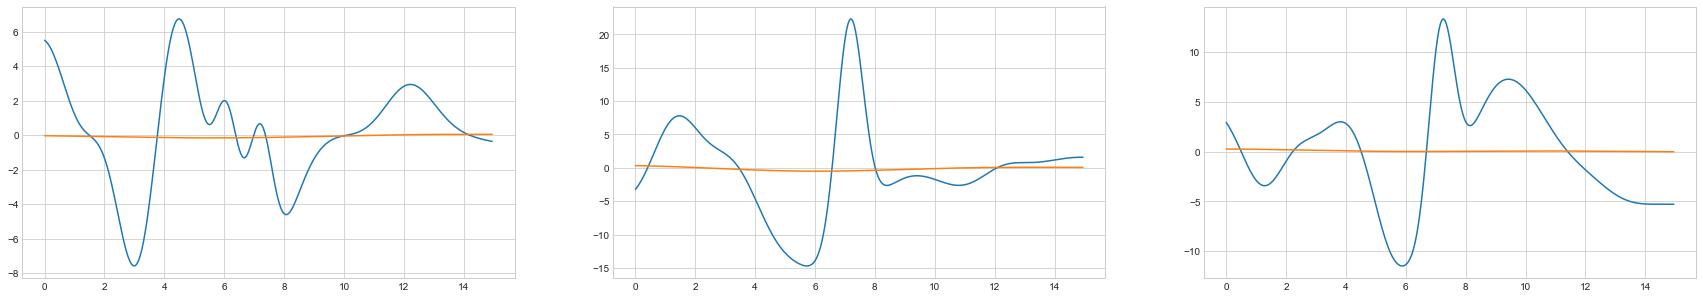

68th additional rbflayer
68th additional RBFlayer 0th epoch loss: 1379.7882170843457
68th additional RBFlayer 999th epoch MSE Loss: 82.19074255838069
68th additional RBFlayer 1999th epoch MSE Loss: 83.80138613890465
68th additional RBFlayer 2999th epoch MSE Loss: 82.43042370519461
68th additional RBFlayer best loss : 81.3186412605185


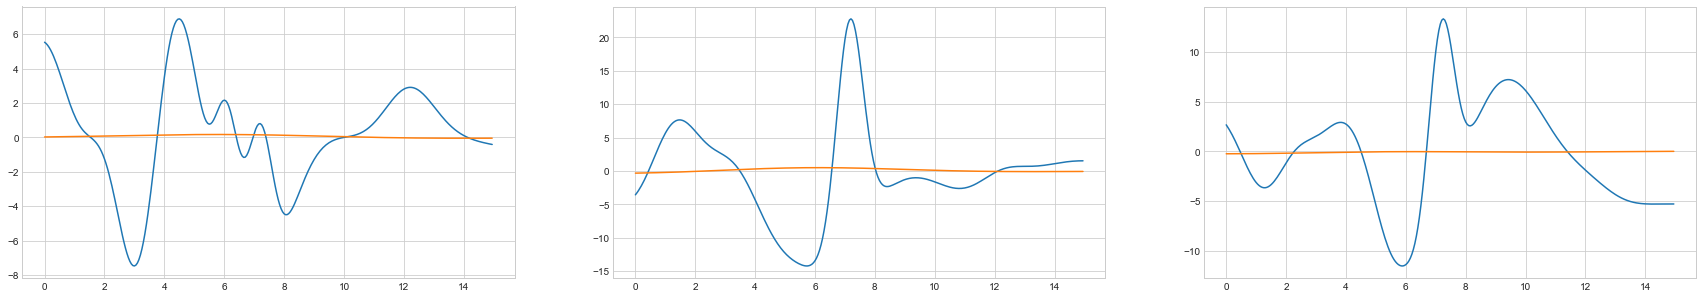

69th additional rbflayer
69th additional RBFlayer 0th epoch loss: 1208.459488632324
69th additional RBFlayer 999th epoch MSE Loss: 82.09877231164337
69th additional RBFlayer 1999th epoch MSE Loss: 83.9333454968875
69th additional RBFlayer 2999th epoch MSE Loss: 82.8130330151916
69th additional RBFlayer best loss : 81.37460034603625


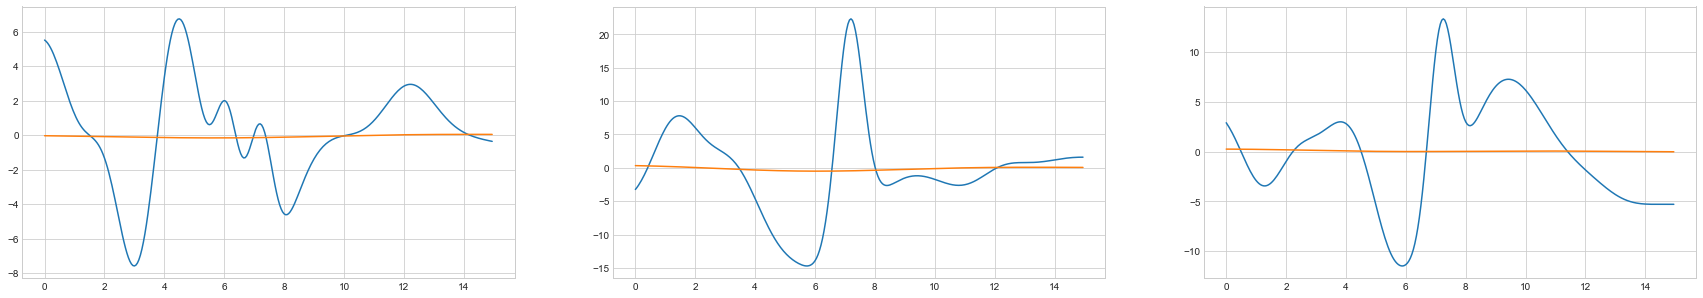

70th additional rbflayer
70th additional RBFlayer 0th epoch loss: 1375.8490400548637
70th additional RBFlayer 999th epoch MSE Loss: 82.1976541052895
70th additional RBFlayer 1999th epoch MSE Loss: 83.84121781454992


KeyboardInterrupt: 

In [51]:
model_total = MultiRBFnn(target.size(0), 30, device)
model_total.train(input_, target, 3000, 0.01, 5, 10)

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), target[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_total.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

# Compare sigma

In [8]:
weights = torch.tensor([[1.23, 2.34, 10.25, 5.61]], dtype=float, device=device)
centers = torch.tensor([[1.0], [2.0], [3.2], [4.7]], dtype=float, device=device)
sigma = torch.tensor([[0.251], [2.3], [1.2], [1.7]], dtype=float, device=device)

In [9]:
def rbf_gaussian_derivative_sigma(input_data):
    output = (2 * torch.pow((input_data - centers), 2) / \
            (torch.pow(sigma, 3))) * rbf_gaussian(input_data, centers, sigma)

    return output  # size = (num_radial, 1)

In [10]:
def rbf_gaussian(input_data, centers, sigma):
    out = torch.exp(-1 *(torch.pow((input_data - centers), 2)) / (torch.pow(sigma, 2)))

    return out

In [11]:
def L2_F(input_data):
    return -2 * (input_data - centers) / torch.pow(sigma, 2)

In [12]:
single_target1.size()

torch.Size([1, 300])

In [13]:
pred = torch.matmul(weights, rbf_gaussian(input_, centers, sigma))

In [14]:
pred_grad = pred

In [15]:
add_rbf_num = 4
L2_grad = -2 * (single_target1 - pred) 
L2_G_grad = -2 * (single_target2 - pred_grad) 

In [ ]:
deltaSigma1 = torch.mean(torch.matmul(L2_grad, rbf_gaussian_derivative_sigma(input_data).T) * 
                            weights , dim = 0).reshape(add_rbf_num,1) # done
deltaSigma2 = torch.mean(torch.matmul(L2_G_grad, (L2_F(input_) *
                                                    rbf_gaussian_derivative_sigma(input_data)).T) * 
                                                    weights, dim = 0).reshape(add_rbf_num, 1) # dome
deltaSigma = deltaSigma1 + deltaSigma2

In [62]:
deltaSigma1 = torch.mean(torch.matmul(L2_grad, rbf_gaussian_derivative_sigma(input_).T) * 
                            weights , dim = 0).reshape(add_rbf_num,1)

In [63]:
deltaSigma1

tensor([[ 772.8638],
        [ -98.2507],
        [2128.8981],
        [1680.0661]], device='cuda:0', dtype=torch.float64)

In [69]:
deltaSigma2 = torch.mean(torch.matmul(L2_G_grad, (L2_F(input_) *
                                                    rbf_gaussian_derivative_sigma(input_)).T) * 
                                                    weights, dim = 0).reshape(add_rbf_num, 1) # dome

In [70]:
deltaSigma2

tensor([[-1318.1537],
        [  700.9640],
        [16106.6912],
        [ 5357.2167]], device='cuda:0', dtype=torch.float64)

# Compare weights

In [71]:
R = rbf_gaussian(input_, centers, sigma)

In [ ]:
deltaWeight1 = torch.matmul(L2_grad, R.T) # done
deltaweight2 = torch.matmul(L2_G_grad, L2_2_derivateive_weight(input_data, R).T)
deltaWeight = deltaWeight1 + deltaweight2

In [72]:
deltaWeight1 = torch.matmul(L2_grad, R.T)
deltaWeight1

tensor([[ 168.1313, 1556.1913, 1106.7864, -562.2256]], device='cuda:0',
       dtype=torch.float64)

In [16]:
def L2_2_derivateive_weight(input_data, radial_output):
        return (-2 *(input_data - centers) / torch.pow(sigma,2)) * radial_output

In [75]:
deltaweight2 = torch.matmul(L2_G_grad, L2_2_derivateive_weight(input_, R).T)
deltaweight2

tensor([[ -89.4611,    5.9893,  759.1135, 1002.1133]], device='cuda:0',
       dtype=torch.float64)

# Compare centers

In [17]:
def rbf_gaussian_derivative_centers(input_data):
    output = (2 * (input_data - centers) / \
                (torch.pow(sigma, 2))) * rbf_gaussian(input_data, centers, sigma)

    return output  # size = (num_radial, 1)

In [79]:
deltaCenter1 = torch.mean(torch.matmul(L2_grad, rbf_gaussian_derivative_centers(input_).T) *
                            weights , dim = 0).reshape(add_rbf_num, 1) # done
deltaCenter2 = torch.mean(torch.matmul(L2_G_grad, (L2_F(input_) *
                                                    rbf_gaussian_derivative_centers(input_)).T) *
                                                    weights, dim = 0).reshape(add_rbf_num, 1) # done
 
deltaCenter = deltaCenter1 + deltaCenter2 # done

In [80]:
deltaCenter

tensor([[ -6048.2405],
        [    71.4205],
        [-11329.0769],
        [ -7598.4042]], device='cuda:0', dtype=torch.float64)

# retest

In [100]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.weights.reshape(self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.add_rbf_num, 1)

        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.weights.reshape(self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.add_rbf_num, 1)
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)

        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_num)  
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, R) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_num)
        delta_weight = delta_weight1 + delta_weight2
        
      
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 620771.5399337024
0th additional RBFlayer 999th epoch MSE Loss: 211.05913375107875
0th additional RBFlayer 1999th epoch MSE Loss: 211.00760708565244
0th additional RBFlayer 2999th epoch MSE Loss: 210.95745352977744
0th additional RBFlayer best loss : 210.95745352977744


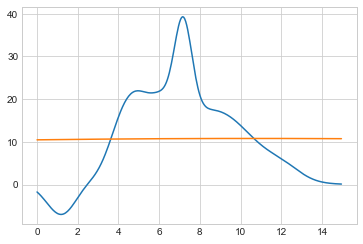

1th additional rbflayer
tensor([[7.1500],
        [7.2000],
        [7.1000],
        [7.2500],
        [7.0500],
        [7.3000],
        [7.0000],
        [7.3500],
        [6.9500],
        [7.4000],
        [6.9000],
        [7.4500],
        [6.8500],
        [7.5000],
        [6.8000],
        [6.7500],
        [7.5500],
        [6.7000],
        [7.6000],
        [6.6500],
        [7.6500],
        [6.6000],
        [1.2000],
        [1.1500],
        [1.2500],
        [1.1000],
        [1.3000],
        [1.0500],
        [1.3500],
        [1.0000]], device='cuda:0', dtype=torch.float64) tensor([[ 28.5491,  28.4537,  28.3710,  28.0855,  27.9301,  27.4559,  27.2472,
          26.5866,  26.3526,  25.5081,  25.2837,  24.2577,  24.0829,  22.8771,
          22.7952,  21.4653,  21.4102,  20.1357,  19.9009,  18.8445,  18.3903,
          17.6235, -17.5422, -17.5362, -17.5114, -17.4939, -17.4437, -17.4164,
         -17.3397, -17.3052]], device='cuda:0', dtype=torch.float64) tensor([[25.

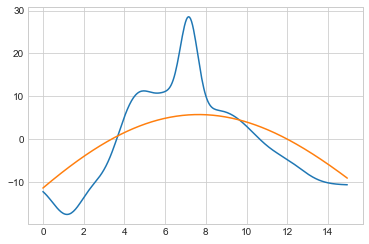

2th additional rbflayer
tensor([[7.1500],
        [7.2000],
        [7.1000],
        [7.2500],
        [7.0500],
        [7.3000],
        [7.0000],
        [7.3500],
        [6.9500],
        [7.4000],
        [6.9000],
        [6.8500],
        [7.4500],
        [6.8000],
        [7.5000],
        [6.7500],
        [7.5500],
        [6.7000],
        [7.6000],
        [6.6500],
        [7.6500],
        [6.6000],
        [7.7000],
        [6.5500],
        [1.4500],
        [1.4000],
        [1.5000],
        [1.3500],
        [1.5500],
        [1.3000]], device='cuda:0', dtype=torch.float64) tensor([[ 22.8863,  22.7758,  22.7249,  22.3941,  22.3023,  21.7526,  21.6393,
          20.8731,  20.7662,  19.7860,  19.7204,  18.5443,  18.5285,  17.2829,
          17.1424,  15.9809,  15.6717,  14.6809,  14.1601,  13.4208,  12.6489,
          12.2325,  11.1752,  11.1409, -11.1160, -11.1129, -11.0861, -11.0751,
         -11.0256, -11.0008]], device='cuda:0', dtype=torch.float64) tensor([[ 8.

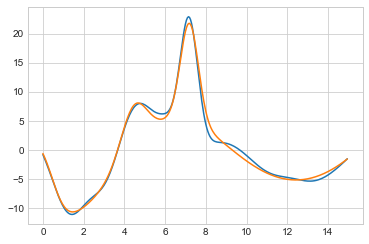

In [101]:
model_single3 = MultiRBFnn(single_target3.size(0), 30, device)
model_single3.train(input_, single_target3, 3000, 0.00001, 5, 12)

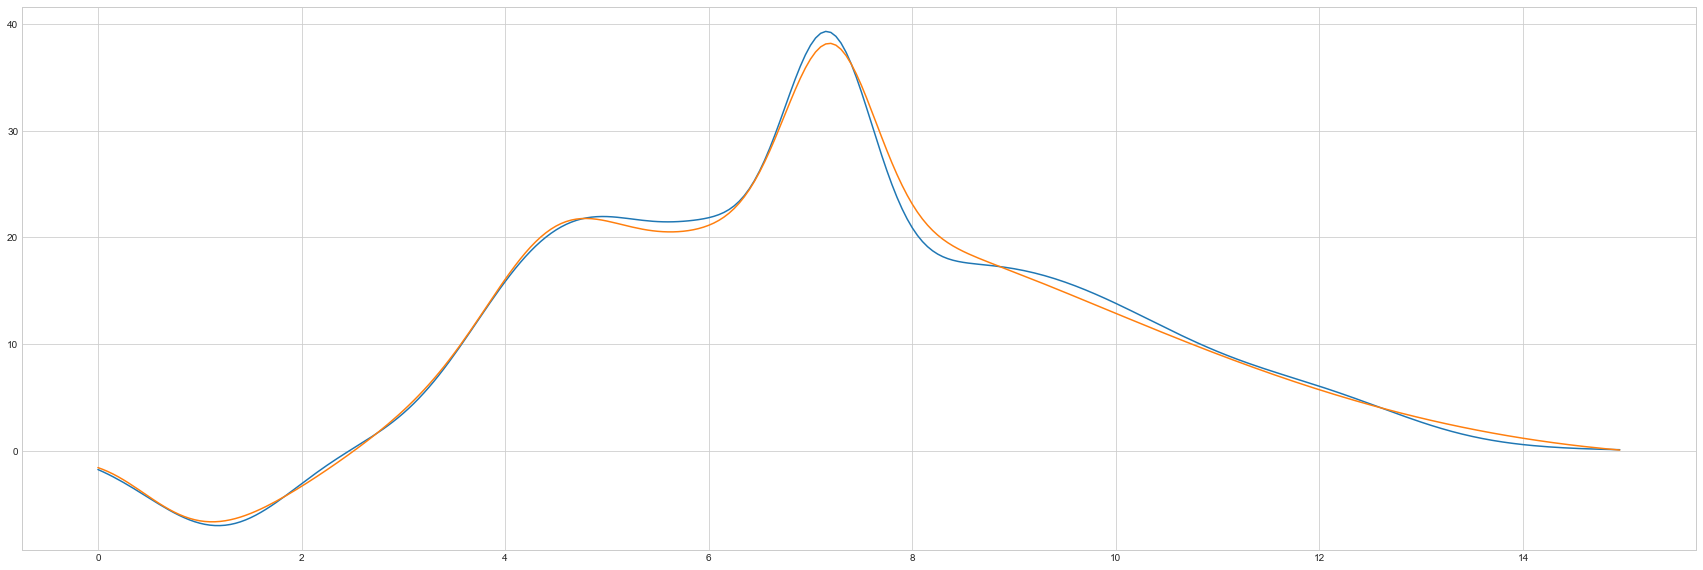

In [140]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target3[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single3.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 287847.55831353995
0th additional RBFlayer 999th epoch MSE Loss: 297.11302097679567
0th additional RBFlayer 1999th epoch MSE Loss: 297.10902593827296
0th additional RBFlayer 2999th epoch MSE Loss: 297.10503182589116
0th additional RBFlayer best loss : 297.10503182589116


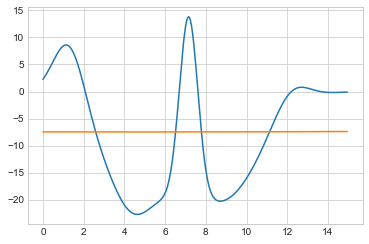

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 44999.996666770836
1th additional RBFlayer 999th epoch MSE Loss: 265.70067034335443
1th additional RBFlayer 1999th epoch MSE Loss: 238.7030789836763
1th additional RBFlayer 2999th epoch MSE Loss: 232.59769402844174
1th additional RBFlayer best loss : 232.59224181363962


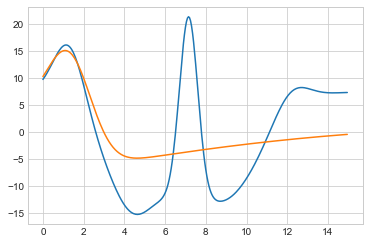

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 33078.90912413912
2th additional RBFlayer 999th epoch MSE Loss: 13.34482553261793
2th additional RBFlayer 1999th epoch MSE Loss: 5.583119752113183
2th additional RBFlayer 2999th epoch MSE Loss: 4.6185931464586645
2th additional RBFlayer best loss : 4.61807077182951
change lr  0.0001
----------------------------------------------


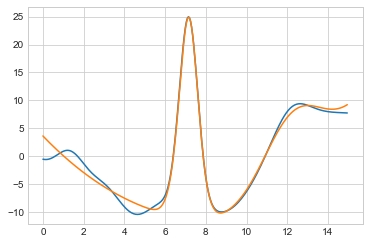

In [141]:
model_single2 = MultiRBFnn(single_target2.size(0), 30, device)
model_single2.train(input_, single_target2, 3000, 0.00001, 5, 12)

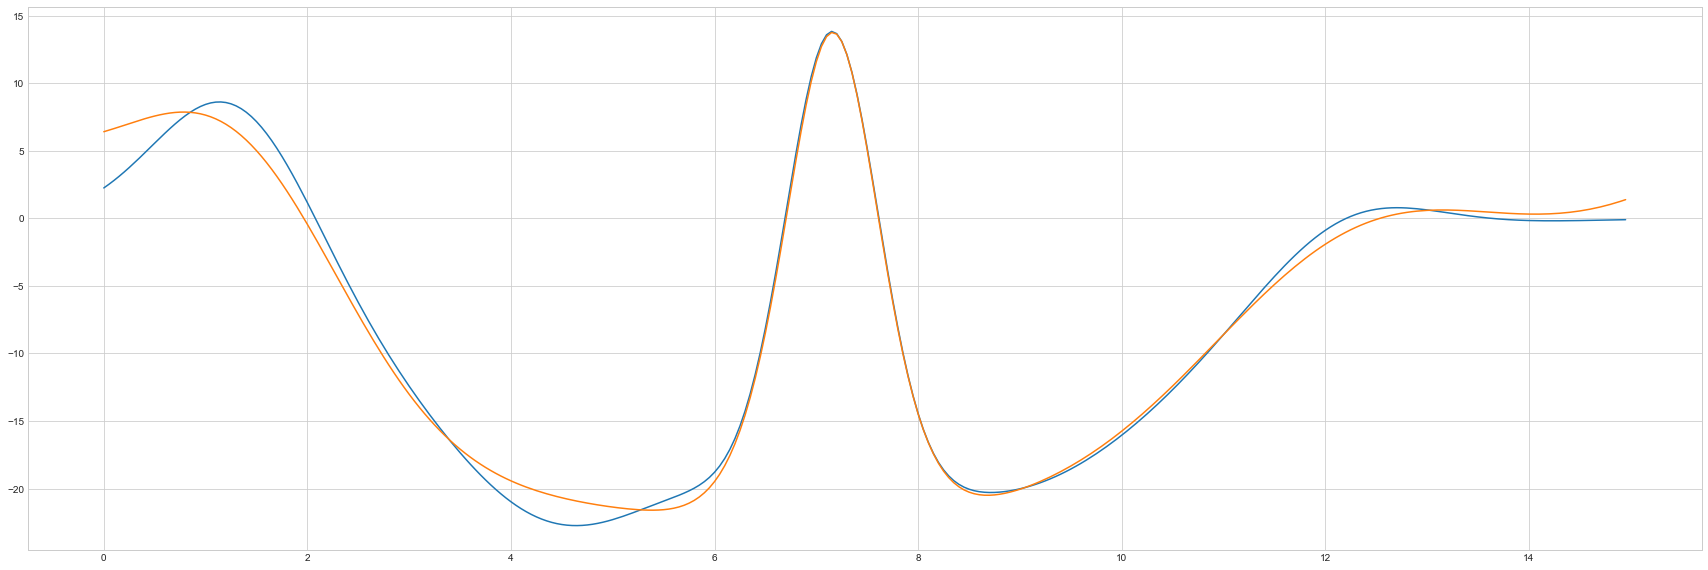

In [142]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target2[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single2.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 246367.48601789854
0th additional RBFlayer 999th epoch MSE Loss: 251.07585429708237
0th additional RBFlayer 1999th epoch MSE Loss: 248.7123617939967
0th additional RBFlayer 2999th epoch MSE Loss: 246.88523876588627
0th additional RBFlayer best loss : 246.88523876588627


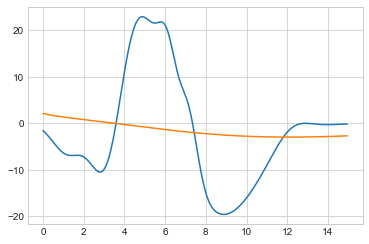

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 217730.8210744841
1th additional RBFlayer 999th epoch MSE Loss: 247.14443612669353
1th additional RBFlayer 1999th epoch MSE Loss: 246.34781721442928
1th additional RBFlayer 2999th epoch MSE Loss: 245.80922148045508
1th additional RBFlayer best loss : 245.80871155299403


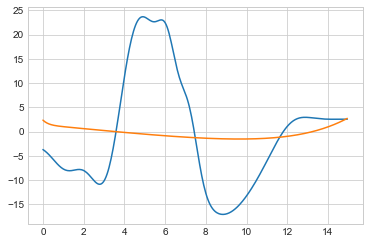

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 238298.030908434
2th additional RBFlayer 999th epoch MSE Loss: 93.66045731966578
2th additional RBFlayer 1999th epoch MSE Loss: 63.27946255125627
2th additional RBFlayer 2999th epoch MSE Loss: 51.38690446177076
2th additional RBFlayer best loss : 51.37861027684848


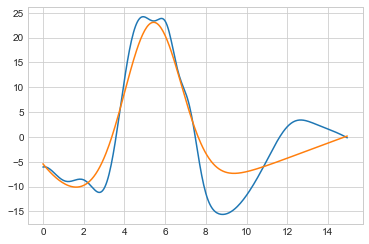

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 20803.14641459218
3th additional RBFlayer 999th epoch MSE Loss: 30.538887846843398
3th additional RBFlayer 1999th epoch MSE Loss: 25.373539340694503
3th additional RBFlayer 2999th epoch MSE Loss: 14.55164881732676
3th additional RBFlayer best loss : 14.544173528739613


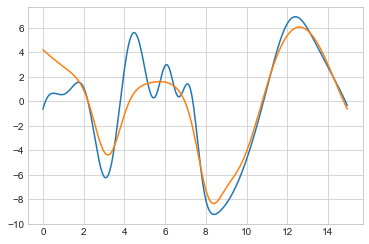

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 2416.8061781350348
4th additional RBFlayer 999th epoch MSE Loss: 11.95429105303721
4th additional RBFlayer 1999th epoch MSE Loss: 11.906822442754674
4th additional RBFlayer 2999th epoch MSE Loss: 11.883494844395239
4th additional RBFlayer best loss : 11.88346461618715
change lr  0.0001
----------------------------------------------


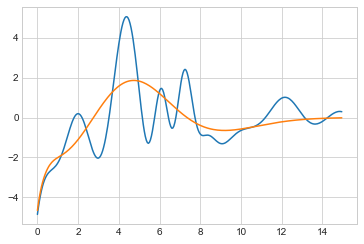

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 37.54097922660788
5th additional RBFlayer 999th epoch MSE Loss: 11.87599851856087
5th additional RBFlayer 1999th epoch MSE Loss: 9.3470384213615
5th additional RBFlayer 2999th epoch MSE Loss: 3.2908169741701583
5th additional RBFlayer best loss : 2.469704246211346


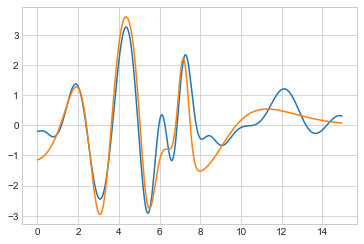

In [143]:
model_single1 = MultiRBFnn(single_target1.size(0), 30, device)
model_single1.train(input_, single_target1, 3000, 0.00001, 5, 12)

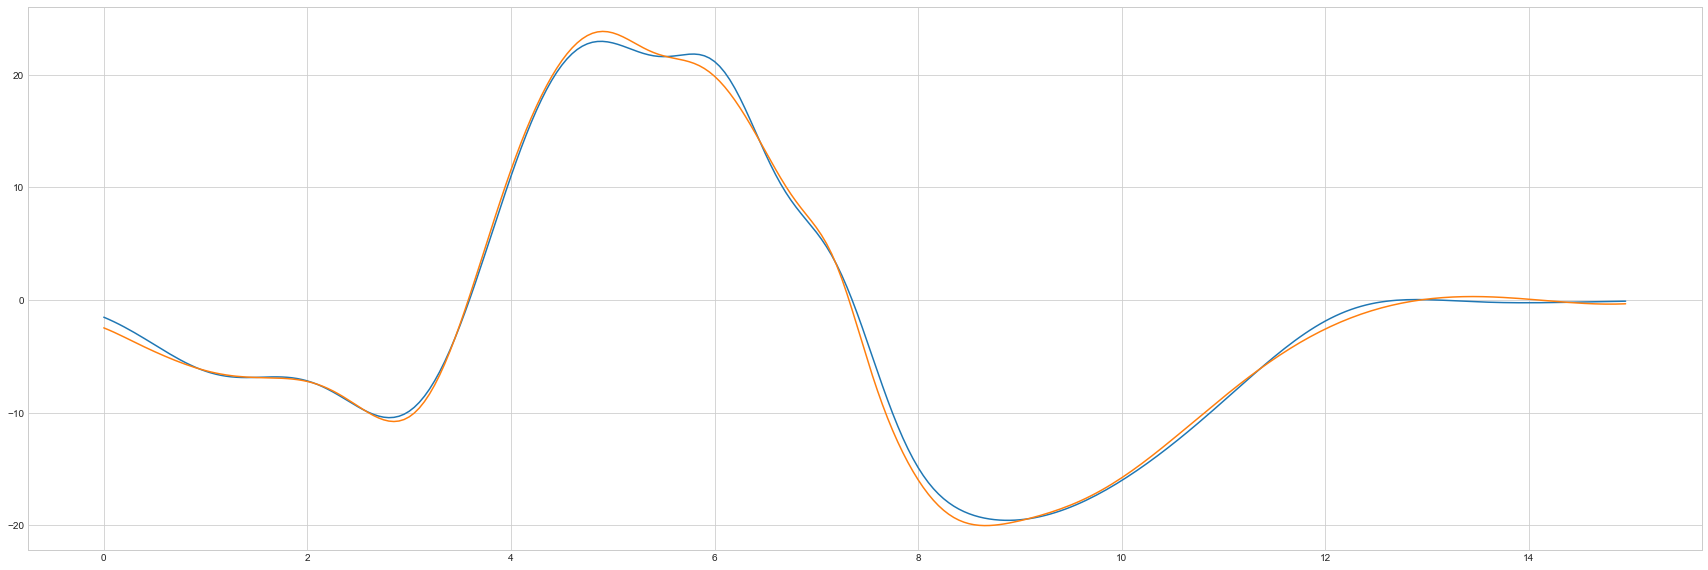

In [144]:
plt.figure(figsize=(30, 10))
plt.plot(input_.cpu().detach().numpy(), single_target1[0].cpu().detach().numpy())
plt.plot(input_.cpu().detach().numpy(), model_single1.pred(input_)[1][0].cpu().detach().numpy())
plt.show()

# Redebugging

In [18]:
L2_1_error = L2_grad
L2_2_error = L2_G_grad

In [ ]:
deltaSigma1 = rbf_gaussian_derivative_sigma(input_data) * L2_1_error
deltaSigma1 *= weights.reshape(add_rbf_num, 1)

deltaSigma2 = rbf_gaussian_derivative_sigma(input_data) * L2_2_error
deltaSigma2 *= L2_F(input_data) * weights.reshape(add_rbf_num, 1)

deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)

In [20]:
weights

tensor([[ 1.2300,  2.3400, 10.2500,  5.6100]], device='cuda:0',
       dtype=torch.float64)

In [21]:
multiweights = torch.tensor([[ 1.2300,  2.3400, 10.2500,  5.6100], [5.2, 1.2, 3.2, 4.2], [2.1,5.2, 3.1, 5.2]], dtype = float, device = device)

In [25]:
R = rbf_gaussian(input_, centers, sigma)

In [26]:
mulitpred = torch.mm(multiweights, R)

In [109]:
multiweights.size()

torch.Size([3, 4])

In [27]:
mulitpred.size()

torch.Size([3, 300])

In [31]:
L2_1_error_mulit = mulitpred

# sigma single

In [61]:
weights.size()

torch.Size([1, 4])

In [51]:
deltaSigma1 = rbf_gaussian_derivative_sigma(input_) * L2_1_error_mulit[0].reshape(1,L2_1_error_mulit.size(-1))
deltaSigma1 *= weights.reshape(add_rbf_num, 1)

In [52]:
deltaSigma1.size()

torch.Size([4, 300])

In [54]:
deltaSigma1

tensor([[2.2061e-05, 9.7320e-05, 3.9412e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.0151e-01, 8.2251e-01, 8.4163e-01,  ..., 1.1805e-25, 7.2911e-26,
         4.4958e-26],
        [1.0999e-01, 1.3818e-01, 1.7280e-01,  ..., 1.2565e-51, 4.4037e-52,
         1.5370e-52],
        [2.6819e-02, 3.2094e-02, 3.8306e-02,  ..., 5.1901e-27, 2.8814e-27,
         1.5957e-27]], device='cuda:0', dtype=torch.float64)

In [62]:
deltaSigma2 = rbf_gaussian_derivative_sigma(input_) * L2_2_error
deltaSigma2 *= L2_F(input_) * weights.reshape(add_rbf_num, 1)

In [64]:
deltaSigma2.size()

torch.Size([4, 300])

In [75]:
single_deltaSigma2 = rbf_gaussian_derivative_sigma(input_) * L2_1_error_mulit[0].reshape(1,300)
single_deltaSigma2 *= L2_F(input_) * weights.reshape(add_rbf_num, 1)

# sigma multi

In [36]:
multi_deltaSigma1 = rbf_gaussian_derivative_sigma(input_) * L2_1_error_mulit.reshape(3,1,300)

In [45]:
multi_deltaSigma1.size()

torch.Size([3, 4, 300])

In [48]:
multiweights

tensor([[ 1.2300,  2.3400, 10.2500,  5.6100],
        [ 5.2000,  1.2000,  3.2000,  4.2000],
        [ 2.1000,  5.2000,  3.1000,  5.2000]], device='cuda:0',
       dtype=torch.float64)

In [49]:
multiweights.reshape(3,4,1)

tensor([[[ 1.2300],
         [ 2.3400],
         [10.2500],
         [ 5.6100]],

        [[ 5.2000],
         [ 1.2000],
         [ 3.2000],
         [ 4.2000]],

        [[ 2.1000],
         [ 5.2000],
         [ 3.1000],
         [ 5.2000]]], device='cuda:0', dtype=torch.float64)

In [47]:
multi_deltaSigma1 * multiweights.reshape(3,4,1)

tensor([[[2.2061e-05, 9.7320e-05, 3.9412e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.0151e-01, 8.2251e-01, 8.4163e-01,  ..., 1.1805e-25,
          7.2911e-26, 4.4958e-26],
         [1.0999e-01, 1.3818e-01, 1.7280e-01,  ..., 1.2565e-51,
          4.4037e-52, 1.5370e-52],
         [2.6819e-02, 3.2094e-02, 3.8306e-02,  ..., 5.1901e-27,
          2.8814e-27, 1.5957e-27]],

        [[4.7742e-05, 2.1051e-04, 8.5207e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.1040e-01, 2.1582e-01, 2.2072e-01,  ..., 3.1440e-26,
          1.9394e-26, 1.1945e-26],
         [1.7578e-02, 2.2073e-02, 2.7588e-02,  ..., 2.0372e-52,
          7.1311e-53, 2.4860e-53],
         [1.0278e-02, 1.2294e-02, 1.4666e-02,  ..., 2.0180e-27,
          1.1189e-27, 6.1895e-28]],

        [[8.3039e-05, 3.6577e-04, 1.4786e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.9267e+00, 4.0236e+00, 4.1099e+00,  ..., 5.7356e-25,
          3.5483e-25, 2.1912e-25],
      

In [34]:
L2_1_error_mulit.size()

torch.Size([3, 300])

In [33]:
rbf_gaussian_derivative_sigma(input_).size()

torch.Size([4, 300])

In [56]:
torch.sum((multi_deltaSigma1 * multiweights.reshape(3,4,1))[0] - deltaSigma1)

tensor(0., device='cuda:0', dtype=torch.float64)

In [ ]:
deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

In [60]:
L2_F(input_).size()

torch.Size([4, 300])

In [66]:
deltaSigma2 = rbf_gaussian_derivative_sigma(input_) * L2_1_error_mulit.reshape(3, 1, 300)

In [71]:
deltaSigma2.size()

torch.Size([3, 4, 300])

In [72]:
deltaSigma2 *= L2_F(input_) * multiweights.reshape(3,4,1)

In [74]:
deltaSigma2.size()

torch.Size([3, 4, 300])

In [68]:
L2_F(input_)

tensor([[  31.7455,   30.1583,   28.5710,  ..., -439.6756, -441.2628,
         -442.8501],
        [   0.7561,    0.7372,    0.7183,  ...,   -4.8582,   -4.8771,
           -4.8960],
        [   4.4444,    4.3750,    4.3056,  ...,  -16.1806,  -16.2500,
          -16.3194],
        [   3.2526,    3.2180,    3.1834,  ...,   -7.0242,   -7.0588,
           -7.0934]], device='cuda:0', dtype=torch.float64)

In [ ]:
deltaSigma2 = rbf_gaussian_derivative_sigma(input_) * L2_1_error.reshape(3, 1, 300)
deltaSigma2 *= L2_F(input_) * weights.reshape(self.in_feature, self.add_rbf_num, 1)

In [77]:
torch.sum(single_deltaSigma2 - deltaSigma2[0])

tensor(0., device='cuda:0', dtype=torch.float64)

In [ ]:
deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

In [79]:
deltaSigma1.size()

torch.Size([4, 300])

In [81]:
torch.sum(deltaSigma2[0], dim = 1)

tensor([ -272.6178,  -288.0114, -1013.9824,  1087.1535], device='cuda:0',
       dtype=torch.float64)

In [96]:
torch.sum(deltaSigma2, dim = 2)

tensor([[ -272.6178,  -288.0114, -1013.9824,  1087.1535],
        [ -472.9875,   -81.7424,  -202.8332,   316.4025],
        [ -466.3631,  -474.1693,   -60.7913,   777.7069]], device='cuda:0',
       dtype=torch.float64)

In [98]:
torch.mean(torch.sum(deltaSigma2, dim = 2), dim = 0)

tensor([-403.9895, -281.3077, -425.8690,  727.0877], device='cuda:0',
       dtype=torch.float64)

In [ ]:
L2_1_error = -2 * (target - pred)
L2_2_error = -2 * (target_grad - pred_grad)

# sigma update
'''
deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
deltaSigma1 *= self.weights.reshape(self.add_rbf_num, 1)

deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.add_rbf_num, 1)

deltaSigma =  torch.sum(deltaSigma1, dim=2) + torch.sum(deltaSigma2, dim=2)
'''
deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

# center update
deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)


# weight update
'''
delta_weight1 = torch.sum((R * L2_1_error), dim=1)
delta_weight1 = delta_weight1.reshape(1, self.add_rbf_num)  
delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, R) * L2_2_error), dim = 1)
delta_weight2 = delta_weight2.reshape(1, self.add_rbf_num)
delta_weight = delta_weight1 + delta_weight2
'''

delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_1_error_mulit.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
delta_weight = delta_weight1 + delta_weight2

# weights multi

In [ ]:
delta_weight1 = torch.sum((R * L2_1_error), dim=1)
delta_weight1 = delta_weight1.reshape(1, self.add_rbf_num)  
delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, R) * L2_2_error), dim = 1)
delta_weight2 = delta_weight2.reshape(1, self.add_rbf_num)
delta_weight = delta_weight1 + delta_weight2

In [107]:
R.size()

torch.Size([4, 300])

In [102]:
L2_1_error_mulit.size()

torch.Size([3, 300])

In [108]:
L2_1_error_mulit[0] - L2_1_error

tensor([[-4.1622e+00, -4.5987e+00, -5.0634e+00, -5.5553e+00, -6.0727e+00,
         -6.6137e+00, -7.1758e+00, -7.7563e+00, -8.3528e+00, -8.9632e+00,
         -9.5868e+00, -1.0225e+01, -1.0881e+01, -1.1561e+01, -1.2267e+01,
         -1.2998e+01, -1.3742e+01, -1.4472e+01, -1.5152e+01, -1.5743e+01,
         -1.6214e+01, -1.6552e+01, -1.6770e+01, -1.6895e+01, -1.6966e+01,
         -1.7018e+01, -1.7078e+01, -1.7158e+01, -1.7261e+01, -1.7387e+01,
         -1.7533e+01, -1.7698e+01, -1.7885e+01, -1.8100e+01, -1.8349e+01,
         -1.8639e+01, -1.8978e+01, -1.9371e+01, -1.9825e+01, -2.0344e+01,
         -2.0929e+01, -2.1582e+01, -2.2301e+01, -2.3082e+01, -2.3920e+01,
         -2.4808e+01, -2.5735e+01, -2.6688e+01, -2.7655e+01, -2.8619e+01,
         -2.9564e+01, -3.0470e+01, -3.1318e+01, -3.2089e+01, -3.2763e+01,
         -3.3319e+01, -3.3740e+01, -3.4006e+01, -3.4102e+01, -3.4011e+01,
         -3.3723e+01, -3.3226e+01, -3.2512e+01, -3.1577e+01, -3.0420e+01,
         -2.9040e+01, -2.7443e+01, -2.

In [104]:
(R * L2_1_error_mulit.reshape(3,1,300)).size()

torch.Size([3, 4, 300])

In [111]:
(R * L2_1_error_mulit[0].reshape(1,300)) - (R * L2_1_error_mulit.reshape(3,1,300))[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [113]:
torch.sum(R * L2_1_error_mulit[0].reshape(1,300), dim =1)

tensor([ 28.9544, 562.2588, 495.9453, 497.5301], device='cuda:0',
       dtype=torch.float64)

In [112]:
torch.sum((R * L2_1_error_mulit.reshape(3,1,300)), dim = 2)

tensor([[ 28.9544, 562.2588, 495.9453, 497.5301],
        [ 42.9939, 285.5507, 221.4113, 269.4097],
        [ 52.8923, 501.2234, 359.7874, 389.1972]], device='cuda:0',
       dtype=torch.float64)

In [115]:
L2_2_derivateive_weight(input_, R)

torch.Size([4, 300])

In [ ]:
delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_1_error_mulit.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)

In [122]:
delta_weight2[1] - torch.sum(L2_2_derivateive_weight(input_, R) * L2_1_error_mulit[1], dim = 1)

tensor([0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)

In [119]:
delta_weight2 = torch.sum(L2_2_derivateive_weight(input_, R) * L2_1_error_mulit.reshape(3, 1, input_.size(0)), dim = 2)

In [120]:
delta_weight2.size()

torch.Size([3, 4])

In [ ]:
delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_1_error_mulit.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)

In [ ]:
delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, R) * L2_2_error), dim = 1)
delta_weight2 = delta_weight2.reshape(1, self.add_rbf_num)

# total

In [133]:
class MultiRBFnn(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): # done

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)

        # print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        #print(initcenter, initweight, initsigma)
        return initcenter, initweight, initsigma
    
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        L2_1_error = -2 * (target - pred)

        L2_2_error = -2 * (target_grad - pred_grad)


        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaSigma2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaSigma =  torch.mean(torch.sum(deltaSigma1, dim=2), dim = 0) + torch.mean(torch.sum(deltaSigma2, dim=2), dim = 0)

        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter1 *= self.weights.reshape(self.in_feature, self.add_rbf_num, 1)

        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0))
        deltaCenter2 *= self.L2_F(input_data) * self.weights.reshape(self.in_feature, self.add_rbf_num, 1)
        deltaCenter =  torch.mean(torch.sum(deltaCenter1, dim=2), dim = 0) + torch.mean(torch.sum(deltaCenter2, dim=2), dim = 0)

        
        # weight update
        delta_weight1 = torch.sum((R * L2_1_error.reshape(self.in_feature, 1, input_data.size(0))), dim=2)
        delta_weight2 = torch.sum(self.L2_2_derivateive_weight(input_, R) * L2_2_error.reshape(self.in_feature, 1, input_data.size(0)), dim = 2)
        delta_weight = delta_weight1 + delta_weight2
        
        # BP update
        self.weights -= self.lr * delta_weight
        #self.centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_num, 1)
        #self.sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_num, 1)
        self.centers -= self.lr * deltaCenter.reshape(self.add_rbf_num, 1)
        self.sigma -= self.lr * deltaSigma.reshape(self.add_rbf_num, 1)

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
    
    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_centers), 2) / \
                                     (torch.pow(self.done_sigma, 2))))
        pred = torch.mm(self.done_weights, rbf_output)

        return rbf_output, pred
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.round_number = 5
        self.change_time = 0
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    # print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)

                for epoch in range(epochs):
                    # print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    # R, pred = self.forward(input_data)
                    # rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 1000 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : {}".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 620771.5399337024
0th additional RBFlayer 999th epoch MSE Loss: 211.05913375107875
0th additional RBFlayer 1999th epoch MSE Loss: 211.00760708565244
0th additional RBFlayer 2999th epoch MSE Loss: 210.95745352977744
0th additional RBFlayer best loss : 210.95745352977744


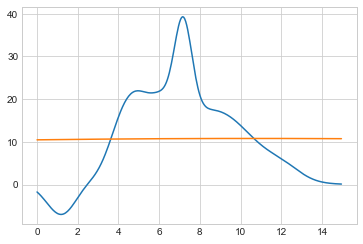

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 227217.1798279378
1th additional RBFlayer 999th epoch MSE Loss: 208.20607130984263
1th additional RBFlayer 1999th epoch MSE Loss: 159.5515784713921
1th additional RBFlayer 2999th epoch MSE Loss: 128.42460789020905
1th additional RBFlayer best loss : 128.39808131136496


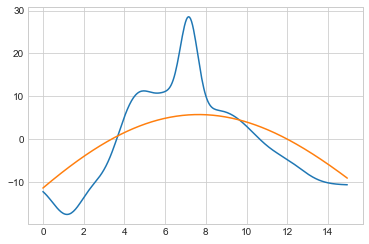

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 90524.30966382593
2th additional RBFlayer 999th epoch MSE Loss: 30.335187280682515
2th additional RBFlayer 1999th epoch MSE Loss: 11.14626124828368
2th additional RBFlayer 2999th epoch MSE Loss: 2.761958782125491
2th additional RBFlayer best loss : 2.7590626378328356
change lr  0.0001
----------------------------------------------


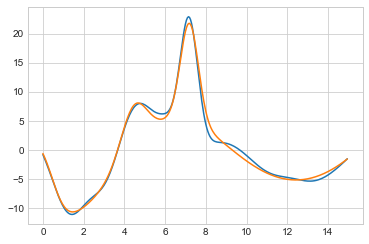

In [134]:
model_single3 = MultiRBFnn(single_target3.size(0), 30, device)
model_single3.train(input_, single_target3, 3000, 0.00001, 5, 12)

0th additional rbflayer
0th additional RBFlayer 0th epoch loss: 3247995.9196596285
0th additional RBFlayer 999th epoch MSE Loss: 294.2719222765544
0th additional RBFlayer 1999th epoch MSE Loss: 293.9105074305191
0th additional RBFlayer 2999th epoch MSE Loss: 293.7872602209968
0th additional RBFlayer best loss : 293.7872602209968


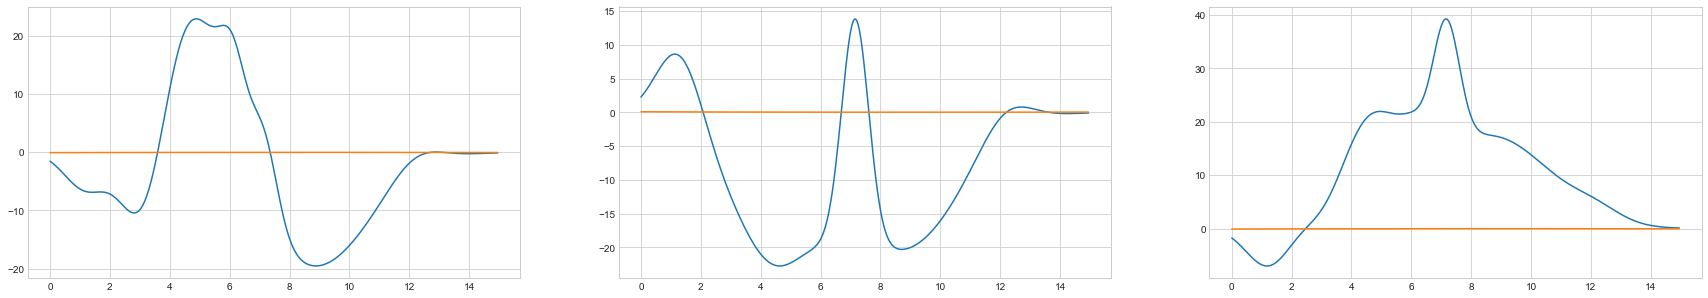

1th additional rbflayer
1th additional RBFlayer 0th epoch loss: 858845.270335571
1th additional RBFlayer 999th epoch MSE Loss: 305.2425254754829
1th additional RBFlayer 1999th epoch MSE Loss: 298.8315162725011
1th additional RBFlayer 2999th epoch MSE Loss: 296.8608925112342
1th additional RBFlayer best loss : 296.8596269282946


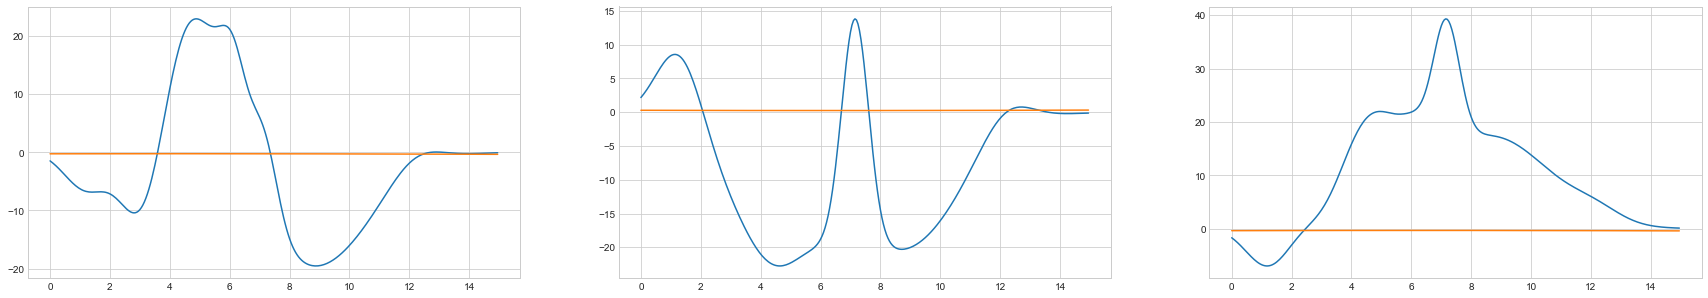

2th additional rbflayer
2th additional RBFlayer 0th epoch loss: 880854.2058813858
2th additional RBFlayer 999th epoch MSE Loss: 299.0911143415396
2th additional RBFlayer 1999th epoch MSE Loss: 297.96804330526385
2th additional RBFlayer 2999th epoch MSE Loss: 297.5702704356348
2th additional RBFlayer best loss : 297.57000440759134


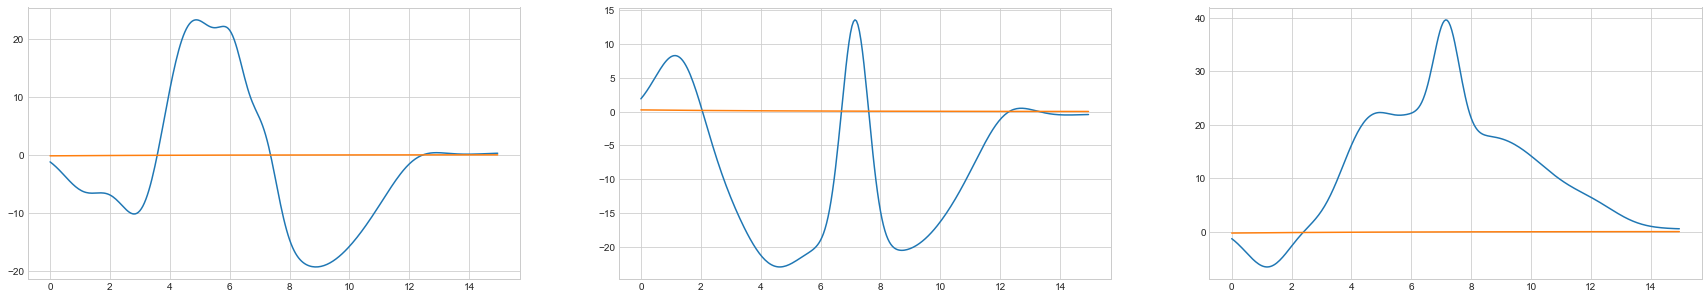

3th additional rbflayer
3th additional RBFlayer 0th epoch loss: 892556.8823184858
3th additional RBFlayer 999th epoch MSE Loss: 258.73697352294704
3th additional RBFlayer 1999th epoch MSE Loss: 247.22593328560632
3th additional RBFlayer 2999th epoch MSE Loss: 241.0727067691093
3th additional RBFlayer best loss : 241.06823838732657


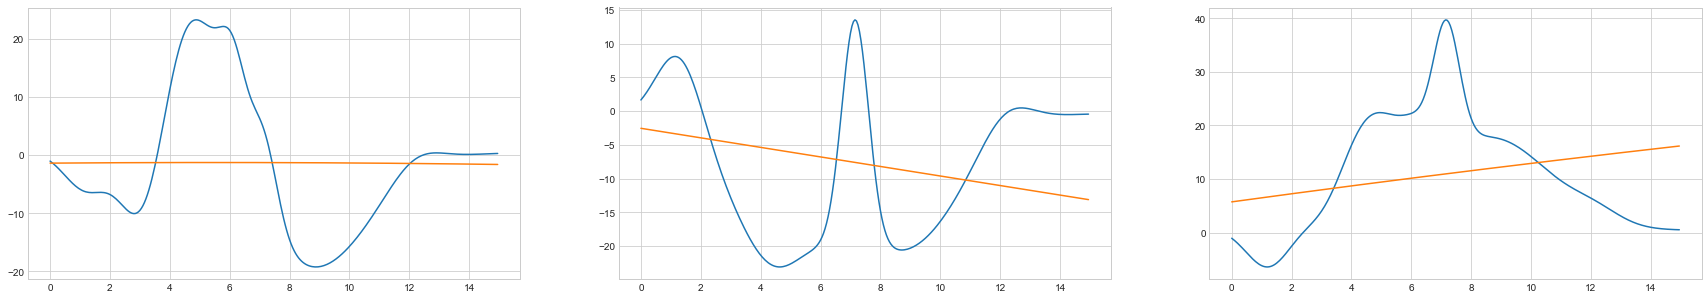

4th additional rbflayer
4th additional RBFlayer 0th epoch loss: 405994.8552146637
4th additional RBFlayer 999th epoch MSE Loss: 193.97552075484646
4th additional RBFlayer 1999th epoch MSE Loss: 156.47686683244737
4th additional RBFlayer 2999th epoch MSE Loss: 144.40096370282953
4th additional RBFlayer best loss : 148.42059701106274


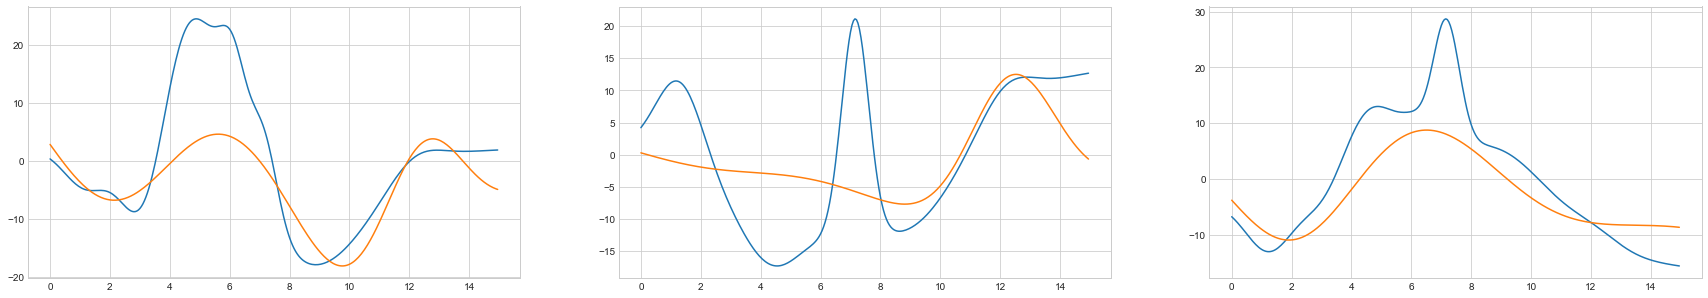

5th additional rbflayer
5th additional RBFlayer 0th epoch loss: 154206.67313418482
5th additional RBFlayer 999th epoch MSE Loss: 133.86460598957868
5th additional RBFlayer 1999th epoch MSE Loss: 129.56412272892837
5th additional RBFlayer 2999th epoch MSE Loss: 121.33727716578545
5th additional RBFlayer best loss : 91.87395962038448
change lr  0.001
----------------------------------------------


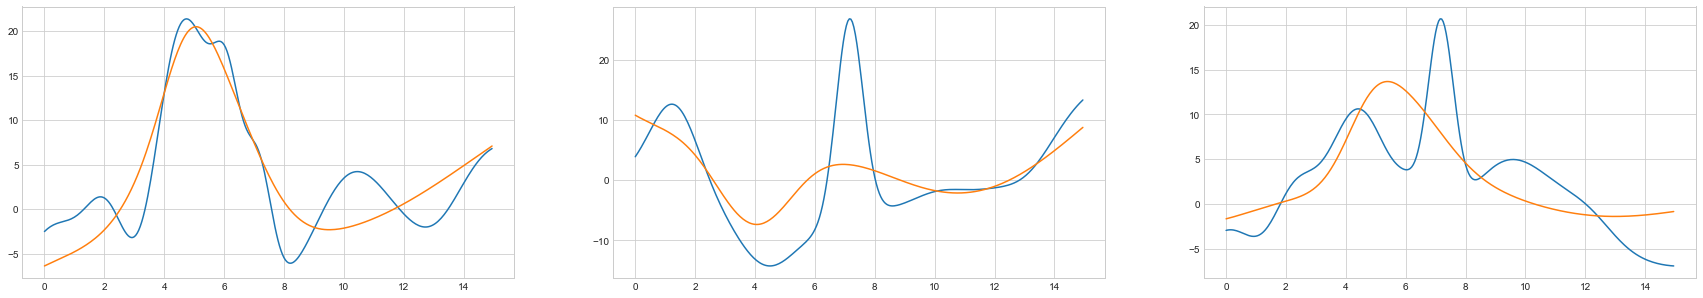

6th additional rbflayer
6th additional RBFlayer 0th epoch loss: 3932.232324840938
6th additional RBFlayer 999th epoch MSE Loss: 95.1028294931104
6th additional RBFlayer 1999th epoch MSE Loss: 92.72606779901602
6th additional RBFlayer 2999th epoch MSE Loss: 92.02552126464302
6th additional RBFlayer best loss : 92.0250965011283


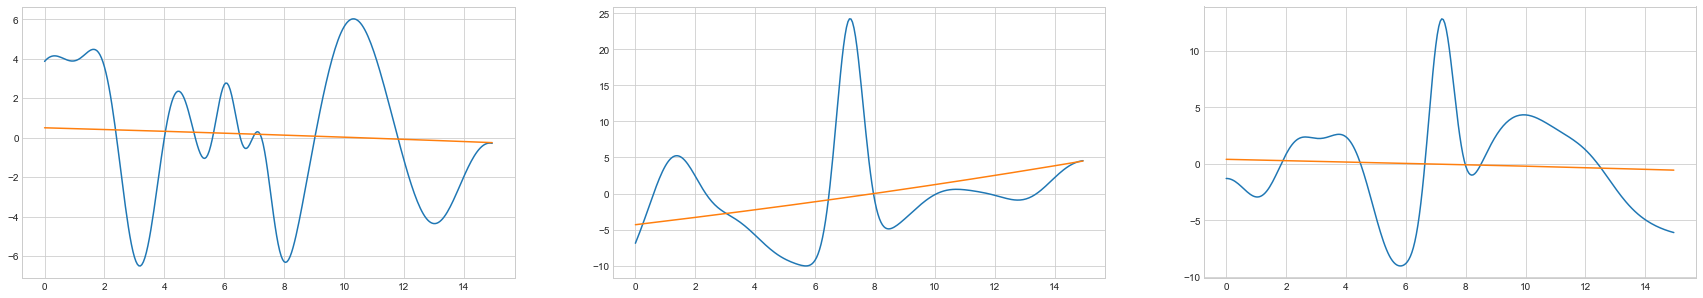

7th additional rbflayer
7th additional RBFlayer 0th epoch loss: 21365.970495882415
7th additional RBFlayer 999th epoch MSE Loss: 92.95736232763467
7th additional RBFlayer 1999th epoch MSE Loss: 92.95735944446878
7th additional RBFlayer 2999th epoch MSE Loss: 92.95735656131208
7th additional RBFlayer best loss : 92.9573565584293


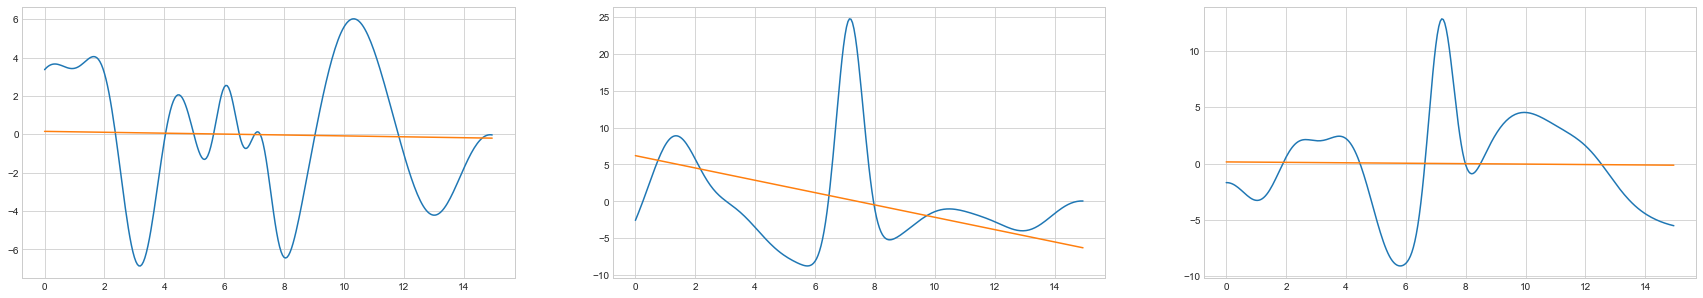

8th additional rbflayer
8th additional RBFlayer 0th epoch loss: 3663.705079090092
8th additional RBFlayer 999th epoch MSE Loss: 91.42975337853107
8th additional RBFlayer 1999th epoch MSE Loss: 91.86778298087778
8th additional RBFlayer 2999th epoch MSE Loss: 91.93021869044902
8th additional RBFlayer best loss : 91.07061464361882


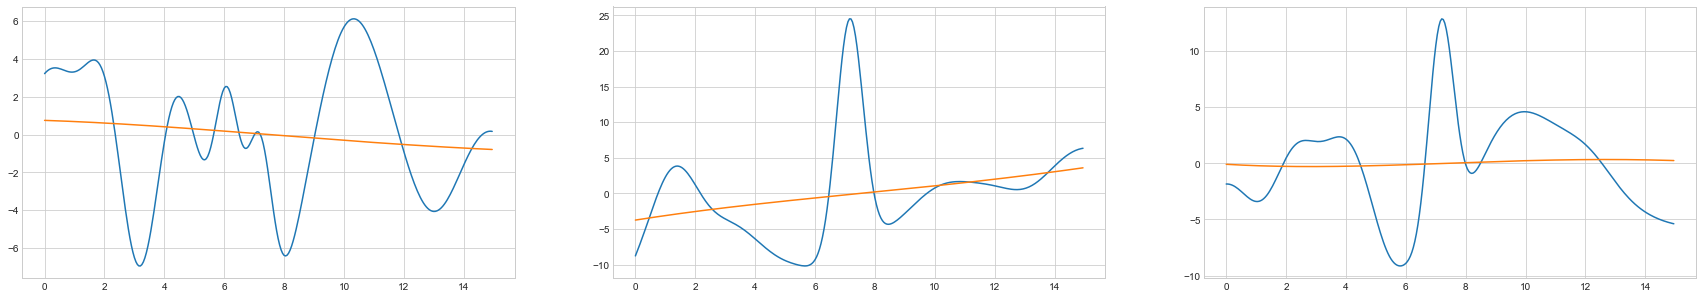

9th additional rbflayer
9th additional RBFlayer 0th epoch loss: 8538.03786802391
9th additional RBFlayer 999th epoch MSE Loss: 102.45220650002321
9th additional RBFlayer 1999th epoch MSE Loss: 102.44996636127371
9th additional RBFlayer 2999th epoch MSE Loss: 102.44772695587366
9th additional RBFlayer best loss : 102.44772471683461


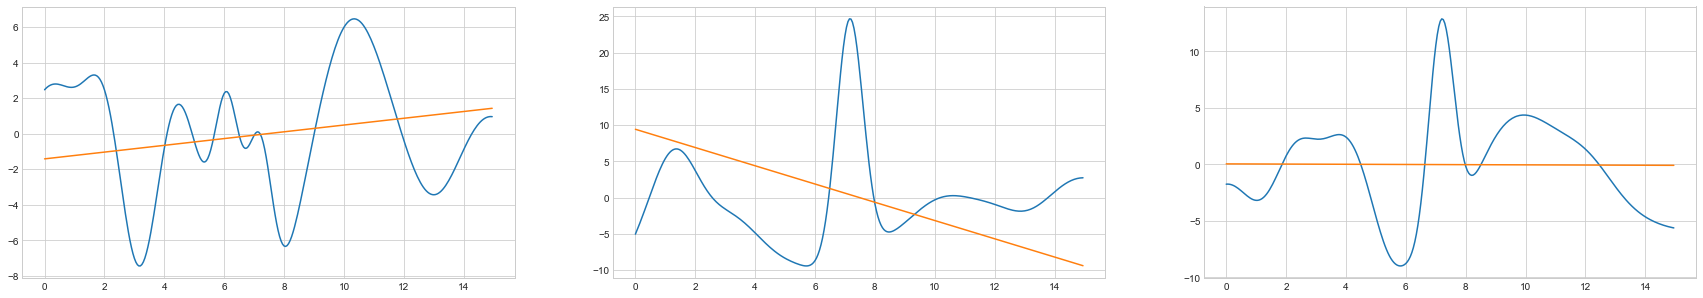

10th additional rbflayer
10th additional RBFlayer 0th epoch loss: 3926.398367045289
10th additional RBFlayer 999th epoch MSE Loss: 90.88802127774106
10th additional RBFlayer 1999th epoch MSE Loss: 90.99518700821883
10th additional RBFlayer 2999th epoch MSE Loss: 91.06452827342817
10th additional RBFlayer best loss : 90.79479739480253


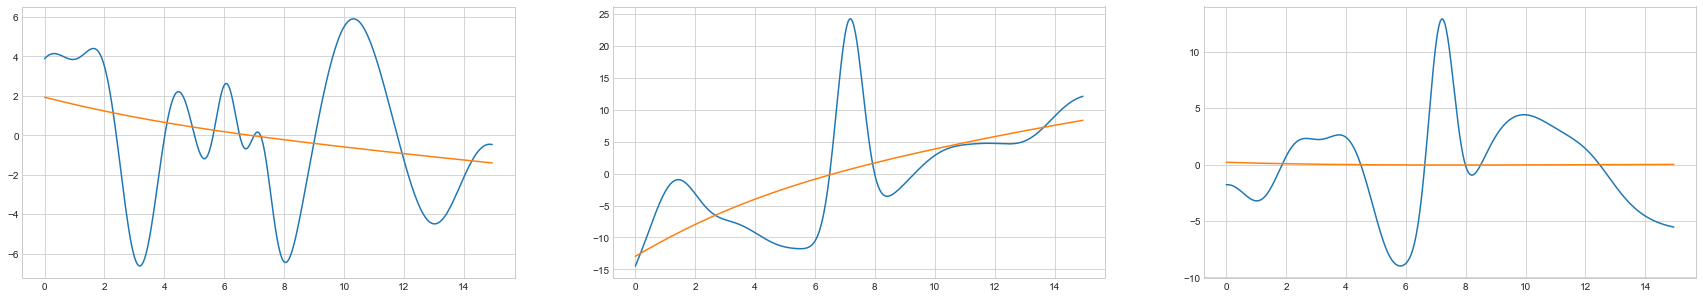

11th additional rbflayer
11th additional RBFlayer 0th epoch loss: 4582.812324520147
11th additional RBFlayer 999th epoch MSE Loss: 90.80322596516429
11th additional RBFlayer 1999th epoch MSE Loss: 90.80320915235815
11th additional RBFlayer 2999th epoch MSE Loss: 90.80319235643834
11th additional RBFlayer best loss : 90.80319233965086


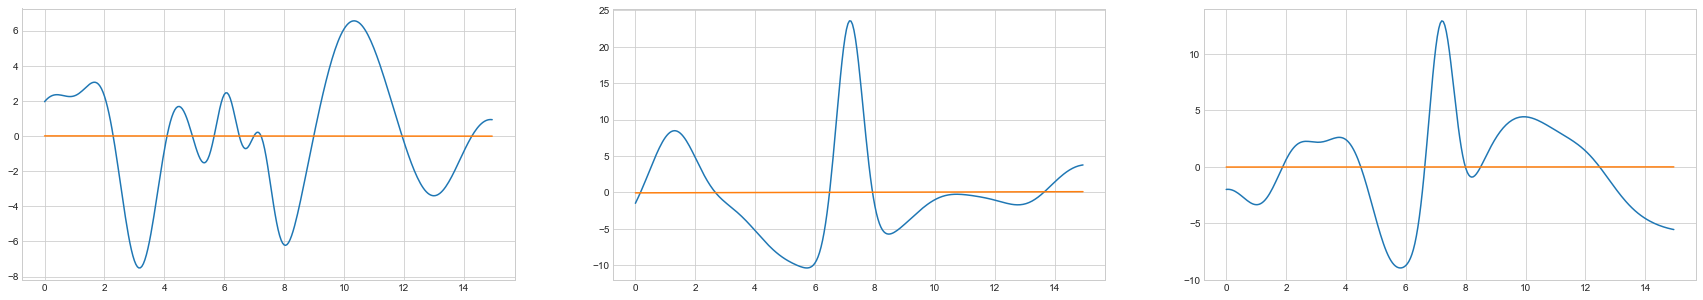

12th additional rbflayer
12th additional RBFlayer 0th epoch loss: 4586.7558263116825
12th additional RBFlayer 999th epoch MSE Loss: 94.74251136463816
12th additional RBFlayer 1999th epoch MSE Loss: 94.69458063694691
12th additional RBFlayer 2999th epoch MSE Loss: 94.64750306832106
12th additional RBFlayer best loss : 94.64745641092563


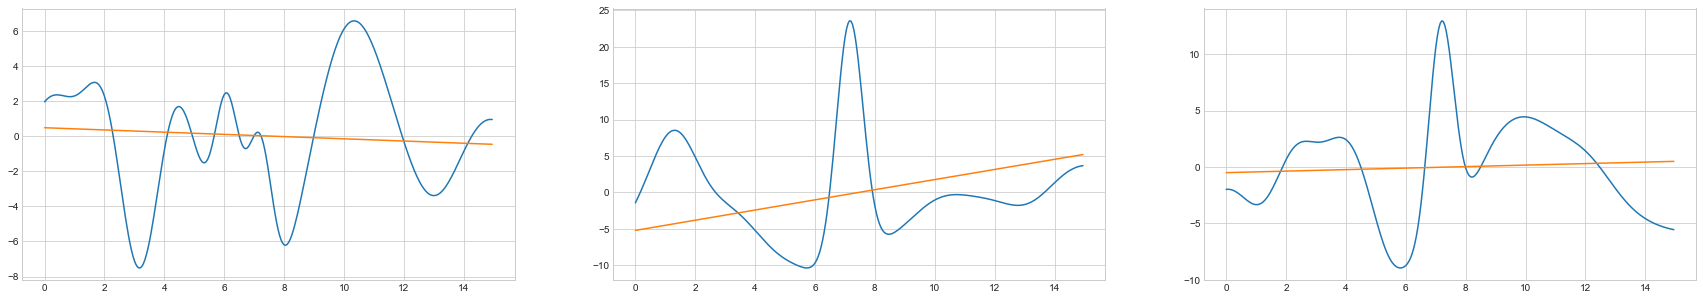

13th additional rbflayer
13th additional RBFlayer 0th epoch loss: 5266.76931928285
13th additional RBFlayer 999th epoch MSE Loss: 97.9105604699173
13th additional RBFlayer 1999th epoch MSE Loss: 97.90756260602741
13th additional RBFlayer 2999th epoch MSE Loss: 97.9045662336043
13th additional RBFlayer best loss : 97.9045632379456


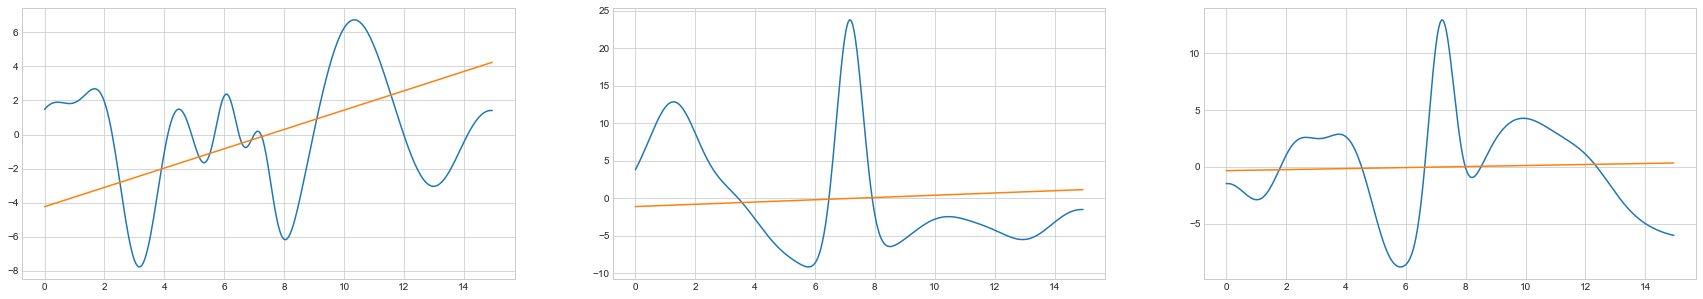

14th additional rbflayer
14th additional RBFlayer 0th epoch loss: 3675.0454450916313
14th additional RBFlayer 999th epoch MSE Loss: 91.01342290860217
14th additional RBFlayer 1999th epoch MSE Loss: 91.1367047487907
14th additional RBFlayer 2999th epoch MSE Loss: 91.26705982548437
14th additional RBFlayer best loss : 90.98030530836049


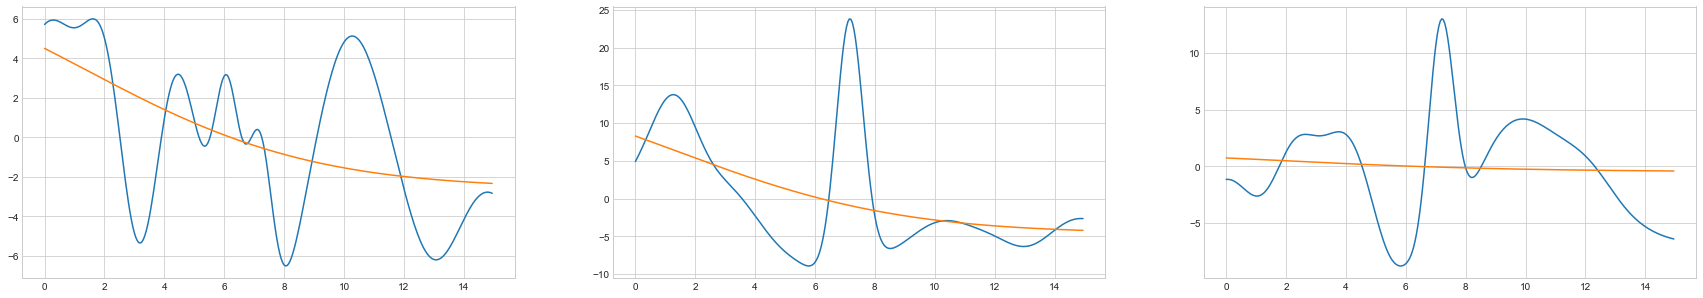

15th additional rbflayer
15th additional RBFlayer 0th epoch loss: 8059.811318737198
15th additional RBFlayer 999th epoch MSE Loss: 91.02935578814177
15th additional RBFlayer 1999th epoch MSE Loss: 91.02935212327627
15th additional RBFlayer 2999th epoch MSE Loss: 91.02934846648249
15th additional RBFlayer best loss : 91.02934846282564


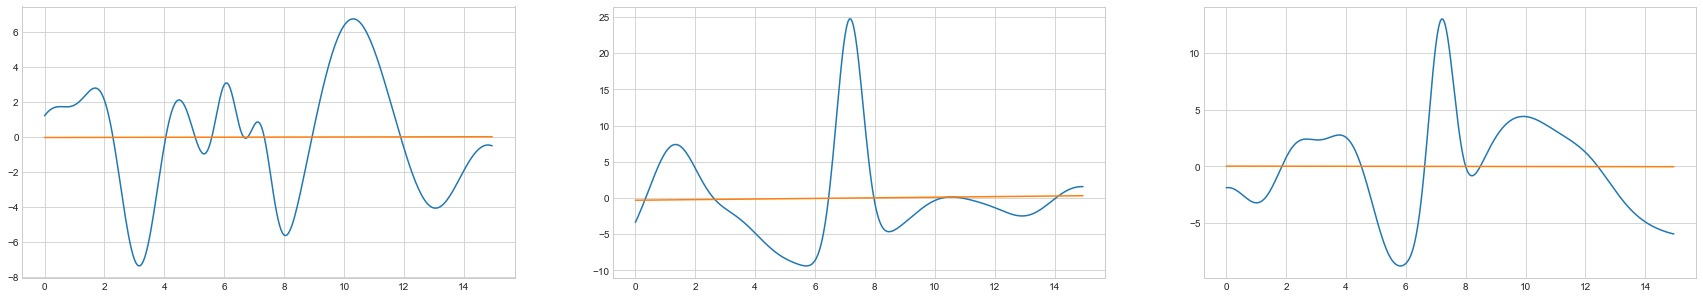

16th additional rbflayer
16th additional RBFlayer 0th epoch loss: 9019.221801545535
16th additional RBFlayer 999th epoch MSE Loss: 129908.665786771
16th additional RBFlayer 1999th epoch MSE Loss: 34453.429633568565
16th additional RBFlayer 2999th epoch MSE Loss: 2087.787692391777
16th additional RBFlayer best loss : 2079.6075972752424


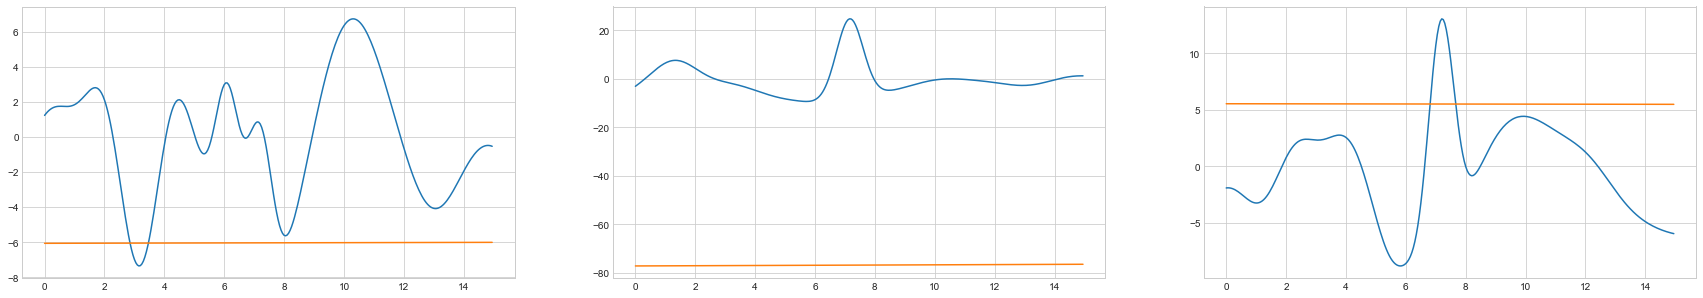

17th additional rbflayer
17th additional RBFlayer 0th epoch loss: 1848638.241535493
17th additional RBFlayer 999th epoch MSE Loss: 91.81703388627834
17th additional RBFlayer 1999th epoch MSE Loss: 91.78001862562712
17th additional RBFlayer 2999th epoch MSE Loss: 91.74452824640078
17th additional RBFlayer best loss : 91.74449349731655


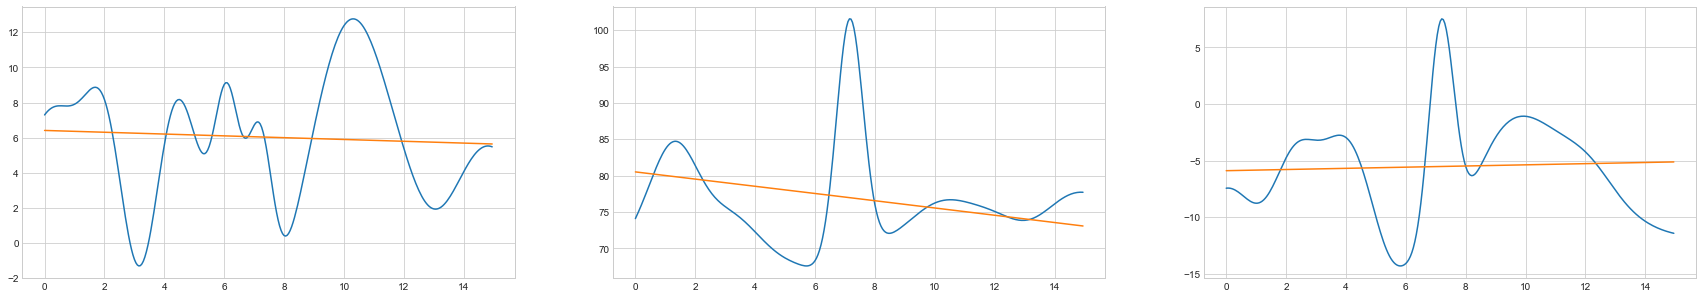

18th additional rbflayer
18th additional RBFlayer 0th epoch loss: 5001.759325540929
18th additional RBFlayer 999th epoch MSE Loss: 102.2980701914857
18th additional RBFlayer 1999th epoch MSE Loss: 99.14821249759086
18th additional RBFlayer 2999th epoch MSE Loss: 96.86742669030814
18th additional RBFlayer best loss : 96.86556492046783


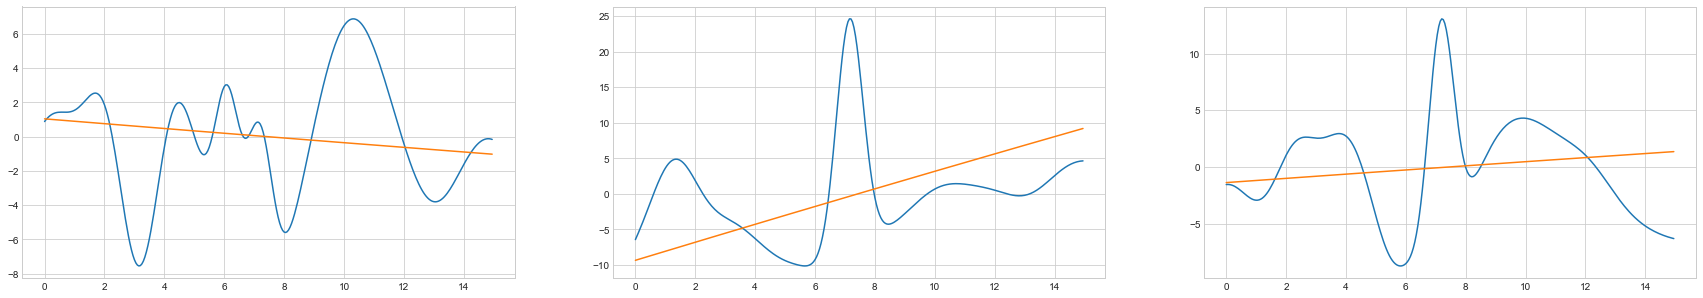

19th additional rbflayer
19th additional RBFlayer 0th epoch loss: 26365.571668326334
19th additional RBFlayer 999th epoch MSE Loss: 101.61721362530878


KeyboardInterrupt: 

In [139]:
model = MultiRBFnn(target.size(0), 50, device)
model.train(input_, target, 3000, 0.0001, 10, 100)